<a href="https://colab.research.google.com/github/pnjha/NLP-Assignments/blob/master/nlp_q4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
pip install tensorflow-gpu==2.0.0-alpha0

     |████████████████████████████████| 332.1MB 54kB/s 
     |████████████████████████████████| 3.0MB 42.0MB/s 
     |████████████████████████████████| 419kB 58.1MB/s 


In [0]:
import unicodedata
import pandas as pd
import numpy as np
import tensorflow as tf
import dill
import pickle
import weakref
from matplotlib.pyplot import *
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
import copy
import math
import seaborn as sns; sns.set()
import keras as keras
from keras.optimizers import SGD
from keras.initializers import RandomUniform
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Embedding, Dense, LSTM, Input, Embedding, TimeDistributed, Flatten, Dropout, Activation, dot, concatenate, Bidirectional
from keras.callbacks import ModelCheckpoint
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

In [0]:
tf.__version__

'2.0.0-alpha0'

In [0]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive


In [0]:
X = pd.read_table('./NLA S20 - Assignment 2 Data/enghin/train.en', names=['src'])
Y_in = pd.read_table('./NLA S20 - Assignment 2 Data/enghin/train.hi', names=['dest_in'])
Y_out = pd.read_table('./NLA S20 - Assignment 2 Data/enghin/train.hi', names=['dest_out'])
lines = pd.concat([X[:400],Y_in[:400],Y_out[:400]], axis=1)
print(len(lines))
# lines = shuffle(lines)
lines.sample(10)

400


src  ...                                           dest_out
314  Raw birth rate and gross reproduction rate has...  ...  अशोधित जन्मदर तथा सकल प्रजनन दर नगरीय तथा ग्रा...
222  If you have the following symptoms then you ma...  ...  यदि आपमें निम्नलिखित लक्षण मौजूद हैं तो आपको ड...
230                  Damage to tendons or neuropathy .  ...                  स्नायुओं को क्षति या न्यूरोपैथी ।
246      Every disease occurs due to a type of virus .  ...  हर रोग एक प्रकार के विषाणु ( वायरस ) से होता है ।
17   The part -LRB- angle -RRB- from where the wate...  ...  एक विशेष लैन्स द्वारा पानी के बाहर जाने के हिस...
70   Generally , easy tumors can be weeded out thro...  ...  सामान्यतः सुसाध्य ट्यूमरों को शल्य-चिकित्सा द्...
198  Keeping infected persons away from school or w...  ...  संक्रमित व्यक्तियों को स्कूल या काम से दूर रखन...
358  Leprosy can affect persons of any age and sex ...  ...  कुष्ठ रोग किसी भी उम्र तथा लिंग के व्यक्तियों ...
241  Studies have proved that dangers of heart atta...  ...  अध्ययनों ने यह प्रमाणित कर दिया है कि दिल का द...
200  Besides the above general symptoms , complaint...  ...  छोटीमाता से ग्रसित गंभीर रोगियों में उपरोक्त स...

[10 rows x 3 columns]

In [0]:
def process_data(data,append_char):
    data = data.apply(lambda x: x.lower())
    data = data.apply(lambda x: x.strip())
    data = data.apply(lambda x: re.sub("'", '', x))
    exclude = set(string.punctuation) # Set of all special characters
    data = data.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
    remove_digits = str.maketrans('', '', digits)
    data = data.apply(lambda x: x.translate(remove_digits))
    if append_char == 1:
        data = data.apply(lambda x : '<sos> '+ x)
    elif append_char == 2:
        data = data.apply(lambda x : x + ' <eos>')
    return data

In [0]:
lines.src = process_data(lines.src,0)
lines.dest_in = process_data(lines.dest_in,1)
lines.dest_out = process_data(lines.dest_out,2)
lines.src.sample(10),lines.dest_in.sample(10),lines.dest_out.sample(10)

(281    the vaccine is available now and is the most p...
 296    the most effective and convenient solution for...
 112    the most credible method of finding out the pr...
 381    female anopheles mosquitoes get born in clean ...
 146    it is attempted that no particle of cancer is ...
 310    raw birth rate of this state in the period of ...
 24                               white surface dries up 
 399    besides this  mouth also starts drying up due ...
 360         all the leprosy patients are not contagious 
 316    generally  birth rate is lower the hilly areas...
 Name: src, dtype: object,
 217    <sos> डेंगू बुखार में कास्टायड दवाइयाँ न ली जा...
 19     <sos> विटामिनए की कमी खसरे तथा कुपोषण की स्थित...
 286    <sos> वयस्क खुराक   वर्ष और अधिक आयु के वयस्को...
 204    <sos> घर में  कूलर में  छत पर खुली टंकियों में...
 145    <sos> अगर कैंसर सीमित क्षेत्र में और प्रारम्भि...
 237    <sos> यदि इलाज न किया गया तो आप प्रभावित अंगों...
 201    <sos> छोटीमाता के रोगियों मे टारनीक्व

In [0]:
X, y_in, y_out = lines.src.values, lines.dest_in.values, lines.dest_out.values 
X_train, X_test, y_in_train, y_in_test, y_out_train, y_out_test = train_test_split(X, y_in, y_out, test_size = 0.2,shuffle=False)

In [0]:
src_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
src_tokenizer.fit_on_texts(X_train)

data_src = src_tokenizer.texts_to_sequences(X_train)
data_src = tf.keras.preprocessing.sequence.pad_sequences(data_src,padding='post')

In [0]:
dest_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')

dest_tokenizer.fit_on_texts(y_in_train)
dest_tokenizer.fit_on_texts(y_out_train)

data_dest_in = dest_tokenizer.texts_to_sequences(y_in_train)
data_dest_in = tf.keras.preprocessing.sequence.pad_sequences(data_dest_in,padding='post')

data_dest_out = dest_tokenizer.texts_to_sequences(y_out_train)
data_dest_out = tf.keras.preprocessing.sequence.pad_sequences(data_dest_out,padding='post')

print(data_dest_in.shape)
print(data_dest_out.shape)

(320, 42)
(320, 42)


In [0]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, lstm_size):
        super(Encoder, self).__init__()
        self.lstm_size = lstm_size
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.lstm_1 = tf.keras.layers.LSTM(lstm_size, return_sequences=True, return_state=True)
        self.lstm_2 = tf.keras.layers.LSTM(lstm_size, return_sequences=True, return_state=True)

    def call(self, sequence, states):
        embed = self.embedding(sequence)
        output, state_h, state_c = self.lstm_1(embed, initial_state=states)
        output, state_h, state_c = self.lstm_2(output, initial_state=[state_h,state_c])
        return output, state_h, state_c

    def init_states(self, batch_size):
        return (tf.zeros([batch_size, self.lstm_size]),
                tf.zeros([batch_size, self.lstm_size]))

In [0]:
class LuongAttention(tf.keras.Model):
    def __init__(self, lstm_size):
        super(LuongAttention, self).__init__()
        self.wa = tf.keras.layers.Dense(lstm_size)

    def call(self, decoder_output, encoder_output):
        score = tf.matmul(decoder_output, self.wa(encoder_output), transpose_b=True)
        attention_weights = tf.nn.softmax(score, axis=2)
        context_vector = tf.matmul(attention_weights, encoder_output)
        return context_vector, attention_weights

In [0]:
class LuongAttentionDot(tf.keras.Model):
    def __init__(self, lstm_size):
        super(LuongAttentionDot, self).__init__()
        self.wa = tf.keras.layers.Dense(lstm_size)

    def call(self, decoder_output, encoder_output):
        score = tf.matmul(decoder_output, encoder_output, transpose_b=True)
        attention_weights = tf.nn.softmax(score, axis=2)
        context_vector = tf.matmul(attention_weights, encoder_output)
        return context_vector, attention_weights

In [0]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, lstm_size):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(lstm_size)
    self.W2 = tf.keras.layers.Dense(lstm_size)
    self.V = tf.keras.layers.Dense(1)

  def call(self, decoder_output, encoder_output):
    
    score = self.V(tf.nn.tanh(self.W1(decoder_output) + self.W2(encoder_output)))
    score = tf.transpose(score,perm=[0,2,1])
    
    attention_weights = tf.nn.softmax(score, axis=2)
    context_vector = tf.matmul(attention_weights, encoder_output)
    return context_vector, attention_weights

In [0]:
class BahdanauAttentionCoverage(tf.keras.Model):
  def __init__(self, lstm_size):
    super(BahdanauAttentionCoverage, self).__init__()
    self.coverage = None
    self.W1 = tf.keras.layers.Dense(lstm_size,name="W1")
    self.W2 = tf.keras.layers.Dense(lstm_size,name="W2")
    self.W3 = tf.keras.layers.Dense(lstm_size,name="W3")
    self.W4 = tf.keras.layers.Dense(lstm_size,name="W4")
    self.W5 = tf.keras.layers.Dense(lstm_size,name="W5")
    self.W6 = tf.keras.layers.Dense(lstm_size,name="W6")
    self.W7 = tf.keras.layers.Dense(lstm_size,name="W7")
    self.V1 = tf.keras.layers.Dense(1,name="V1")
    self.V2 = tf.keras.layers.Dense(1,name="V2")

  def call(self, decoder_output, encoder_output):
    
    if self.coverage is None: 
      self.coverage = decoder_output

    # score = self.V1(tf.nn.tanh(self.W1(decoder_output) + self.W2(encoder_output) + self.W3(self.coverage)))
    score = self.V1(tf.nn.tanh(self.W1(decoder_output) + self.W2(encoder_output)))
    score = tf.transpose(score,perm=[0,2,1])
    
    # self.coverage = self.V1(tf.nn.tanh(self.W4(decoder_output) + self.W5(encoder_output) + self.W6(self.coverage)))
    # self.coverage = tf.reshape(self.coverage, tf.shape(encoder_output).numpy())
    # print(self.coverage.shape, decoder_output.shape, encoder_output.shape)


    attention_weights = tf.nn.softmax(score, axis=2)
    context_vector = tf.matmul(attention_weights, encoder_output)
    # print(score.shape,decoder_output.shape,encoder_output.shape,attention_weights.shape,context_vector.shape)
    return context_vector, attention_weights


In [0]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, lstm_size, attn_type):
        super(Decoder, self).__init__()

        if attn_type == 'LuongAttention':
          self.attention = LuongAttention(lstm_size)
        elif attn_type == 'LuongAttentionDot':
          self.attention = LuongAttentionDot(lstm_size)
        elif attn_type == 'BahdanauAttention':
          self.attention = BahdanauAttention(lstm_size)
        elif attn_type == 'BahdanauAttentionCoverage':
          self.attention = BahdanauAttentionCoverage(lstm_size)
        
        self.lstm_size = lstm_size
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.lstm_1 = tf.keras.layers.LSTM(lstm_size, return_sequences=True, return_state=True)
        self.lstm_2 = tf.keras.layers.LSTM(lstm_size, return_sequences=True, return_state=True)
        self.wc = tf.keras.layers.Dense(lstm_size, activation='tanh')
        self.ws = tf.keras.layers.Dense(vocab_size)

    def call(self, sequence, state, encoder_output):

        embed = self.embedding(sequence)
        
        lstm_out, state_h, state_c = self.lstm_1(embed, initial_state=state)
        lstm_out, state_h, state_c = self.lstm_2(lstm_out, initial_state=[state_h,state_c])
        context, alignment = self.attention(lstm_out, encoder_output)

        lstm_out = tf.concat([tf.squeeze(context, 1), tf.squeeze(lstm_out, 1)], 1)
        lstm_out = self.wc(lstm_out)
        logits = self.ws(lstm_out)

        return logits, state_h, state_c, alignment

In [0]:
BATCH_SIZE = 40
EMBEDDING_SIZE = 256
LSTM_SIZE = 256

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((data_src, data_dest_in, data_dest_out))
dataset = dataset.shuffle(20).batch(BATCH_SIZE)
print(dataset)

<BatchDataset shapes: ((None, 44), (None, 42), (None, 42)), types: (tf.int32, tf.int32, tf.int32)>


In [0]:
def get_model(attn_type):
  src_vocab_size = len(src_tokenizer.word_index) + 1
  dest_vocab_size = len(dest_tokenizer.word_index) + 1

  encoder = Encoder(src_vocab_size, EMBEDDING_SIZE, LSTM_SIZE)
  decoder = Decoder(dest_vocab_size, EMBEDDING_SIZE, LSTM_SIZE,attn_type)
  return encoder, decoder

In [0]:
def loss_func(targets, logits):
    crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    mask = tf.math.logical_not(tf.math.equal(targets, 0))
    mask = tf.cast(mask, dtype=tf.int64)
    loss = crossentropy(targets, logits, sample_weight=mask)

    return loss

In [0]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.01,initial_accumulator_value=0.1)
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.03)

In [0]:
def train_step(model,source_seq, target_seq_in, target_seq_out, en_initial_states):
    loss = 0
    encoder = model["encoder"]
    decoder = model["decoder"]
    with tf.GradientTape() as tape:
        en_outputs = encoder(source_seq, en_initial_states)
        en_states = en_outputs[1:]
        de_state_h, de_state_c = en_states
        
        for i in range(target_seq_out.shape[1]):          
            decoder_in = tf.expand_dims(target_seq_in[:, i], 1)
            logit, de_state_h, de_state_c, _ = decoder(decoder_in, (de_state_h, de_state_c), en_outputs[0])
            loss += loss_func(target_seq_out[:, i], logit)

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return loss / target_seq_out.shape[1]

In [0]:
def train_model(attn_type,NUM_EPOCHS):
  encoder, decoder = get_model(attn_type)
  model = {"encoder":encoder,"decoder":decoder}
  loss_list = []
  ep_list = []

  en_initial_states = encoder.init_states(BATCH_SIZE)
  for e in range(NUM_EPOCHS):
  
      for batch, (source_seq, target_seq_in, target_seq_out) in enumerate(dataset.take(-1)):
          loss = train_step(model, source_seq, target_seq_in,target_seq_out, en_initial_states)
      
      ep_list.append(e+1)
      loss_list.append(loss.numpy())
      print('Epoch {} Loss {:.8f}'.format(e + 1, loss.numpy()))
  return encoder, decoder, loss_list, ep_list

In [0]:
def predict(model,test_source_text):
    
    encoder = model["encoder"]
    decoder = model["decoder"]
    src_tokenizer = model["src_tokenizer"]
    dest_tokenizer = model["dest_tokenizer"]

    test_source_seq = src_tokenizer.texts_to_sequences([test_source_text])

    en_initial_states = encoder.init_states(1)
    en_outputs = encoder(tf.constant(test_source_seq), en_initial_states)

    de_input = tf.constant([[dest_tokenizer.word_index['<sos>']]])
    de_state_h, de_state_c = en_outputs[1:]
    out_words = []
    alignments = []

    while True:
        de_output, de_state_h, de_state_c, alignment = decoder(de_input, (de_state_h, de_state_c), en_outputs[0])
        de_input = tf.expand_dims(tf.argmax(de_output, -1), 0)
        try:
          out_words.append(dest_tokenizer.index_word[de_input.numpy()[0][0]])
        except:
          out_words.append('<unk>')
        alignments.append(alignment.numpy())

        if out_words[-1] == '<eos>' or len(out_words) >= 50:
            break

    out_words = ' '.join(out_words)
    return np.array(alignments), out_words

In [0]:
def calculate_bleu_score(actual_string, predicted_string):
    actual_string = copy.deepcopy(actual_string)
    predicted_string = copy.deepcopy(predicted_string)
    reference = re.split("\s",actual_string.strip())
    candidate = re.split("\s",predicted_string.strip())
    try:
      reference.remove('<eos>')
      candidate.remove('<sos>')
    except:
      pass
    smoothie = SmoothingFunction().method4
    score = sentence_bleu(reference, candidate, smoothing_function=smoothie)
    return score

In [0]:

def plot_graph(xlist,ylist,xname,yname):
  x = np.array(xlist)
  y = np.array(ylist)
  d = {xname: x, yname: y}
  data = pd.DataFrame(d)
  sns.lineplot(x=xname, y=yname,data = data)
  plt.show()

In [0]:
def get_prediction(X,y,model):
  for index,line in enumerate(X):
    alignment, output = predict(model,line)
    print("source: ",line)
    print("actual: ",y[index])
    print("predicted: ",output)
    print("BLEU Score: ",calculate_bleu_score(output,y[index]))
    ax = sns.heatmap(alignment[:,0,0,:],linewidths=.2,cmap="YlGnBu")
    plt.show()

Epoch 1 Loss 3.27495217
Epoch 2 Loss 2.98464441
Epoch 3 Loss 2.79641056
Epoch 4 Loss 2.76089382
Epoch 5 Loss 2.74164534
Epoch 6 Loss 2.72739220
Epoch 7 Loss 2.71612477
Epoch 8 Loss 2.70851731
Epoch 9 Loss 2.70218205
Epoch 10 Loss 2.69658351
Epoch 11 Loss 2.69158030
Epoch 12 Loss 2.68690300
Epoch 13 Loss 2.68241525
Epoch 14 Loss 2.67804646
Epoch 15 Loss 2.67374468
Epoch 16 Loss 2.66945839
Epoch 17 Loss 2.66512156
Epoch 18 Loss 2.66064334
Epoch 19 Loss 2.65600157
Epoch 20 Loss 2.65126109
Epoch 21 Loss 2.64596462
Epoch 22 Loss 2.64006305
Epoch 23 Loss 2.63430738
Epoch 24 Loss 2.62868762
Epoch 25 Loss 2.62267637
Epoch 26 Loss 2.61548185
Epoch 27 Loss 2.60913777
Epoch 28 Loss 2.61327648
Epoch 29 Loss 2.59734035
Epoch 30 Loss 2.60746598
Epoch 31 Loss 2.60694504
Epoch 32 Loss 2.59136081
Epoch 33 Loss 2.58338237
Epoch 34 Loss 2.57177496
Epoch 35 Loss 2.56272650
Epoch 36 Loss 2.55149102
Epoch 37 Loss 2.54239345
Epoch 38 Loss 2.53324318
Epoch 39 Loss 2.52358747
Epoch 40 Loss 2.51478648
Epoch 41 

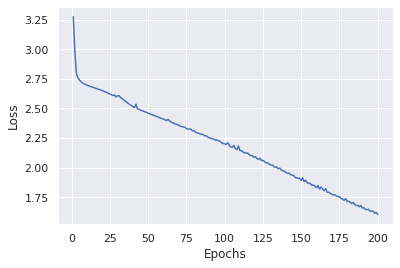

In [166]:
# attn_type = 'BahdanauAttention'
attn_type = 'LuongAttentionDot'
attn_type = 'LuongAttention'
attn_type = 'BahdanauAttentionCoverage'

NUM_EPOCHS = 200
encoder, decoder, loss_list,epoch_list = train_model(attn_type,NUM_EPOCHS)
model = {"encoder":encoder, "decoder":decoder, "attn_type":attn_type, "src_tokenizer":src_tokenizer, "dest_tokenizer":dest_tokenizer}

plot_graph(epoch_list,loss_list,"Epochs","Loss")

In [0]:
nameoffile = "q4"
with open(nameoffile, "wb") as dill_file:
    dill.dump(model, dill_file)

model = {}
with open(nameoffile, "rb") as dill_file:
  model = dill.load(dill_file)

source:  it is difficult to comment on the tendencies and styles of the decrement in the death rate due to lack of information on death rate related to uttarakhand in particular 
actual:  <sos> विशेष कर उत्तराखण्ड के सम्बन्ध में मृत्यु दर सम्बन्धी सूचनाओं के अभाव से मृत्यु दर में कमी की प्रवृत्ति एवं तरीकों पर टिप्पणी करना कठिन है ।
predicted:  वर्ष में में पहले में पहले में महिला में में कैंसर में में अवधि में वर्ष में वर्ष में अधिक अधिक अधिक अधिक में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


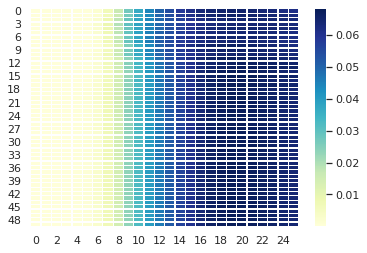

source:  according to the estimates of sample registration system lrb s    rrb the death rate was estimated  on the population of every  during the year of  which is lower than the national average of  
actual:  <sos> सैम्पल पंजीकरण प्रणाली   एसआरएस  के अनुमानों के अनुसार वर्ष  के दौरान उत्तराखण्ड की अशोधित मृत्यु दर प्रत्येक  की जनसंख्या पर  अनुमानित थी जो कि राष्ट्रीय औसत  से कम है ।
predicted:  वर्ष में में पहले में पहले में महिला में कैंसर में कैंसर में वर्ष में वर्ष में अधिक अधिक अधिक अधिक में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


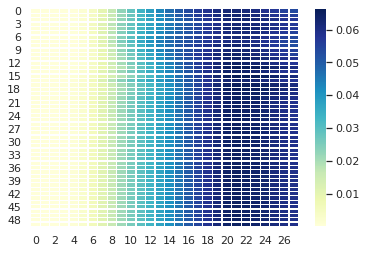

source:  the infant mortality rate of the state was  every  live births in the year of  which is very less than the national rate lrb  rrb 
actual:  <sos> राज्य की शिशु मृत्यु दर वर्ष  में प्रत्येक  जीवित जन्म पर  थी  जो कि राष्ट्रीय दर     से बहुत कम है ।
predicted:  वर्ष प्रजनन से पहले परीक्षण का परीक्षण का कैंसर में क्षेत्र में में वर्ष में वर्ष की वर्ष में वर्ष की कैंसर में वर्ष की कैंसर में कैंसर में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष
BLEU Score:  0


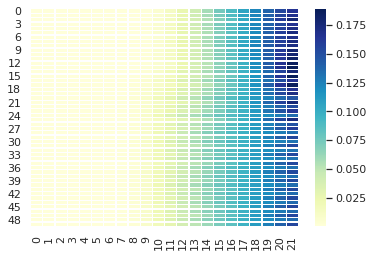

source:  two third deaths out of the total infant mortality number occurs during the period of infancy itself 
actual:  <sos> शिशु मृत्यु की कुल संख्या में से लगभग दो तिहाई मृत्यु नवजात शिशु काल में ही हो जाती है ।
predicted:  एक जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच
BLEU Score:  0


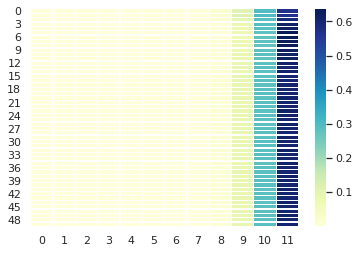

source:  infant mortality rate in uttarakhand is  per  live births 
actual:  <sos> उत्तराखण्ड में बाल मृत्यु दर प्रत्येक  जीवित जन्म पर  है ।
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए सुरक्षा लगना । <eos>
BLEU Score:  0.19112328397109352


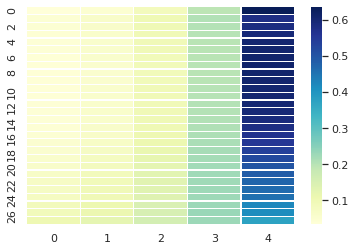

source:  data related to maternal mortality rate of the state is not available 
actual:  <sos> वर्तमान में राज्य की मातृ मृत्यु दर सम्बंधी आंकड़े उपलब्ध नहीं है ।
predicted:  जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के
BLEU Score:  0


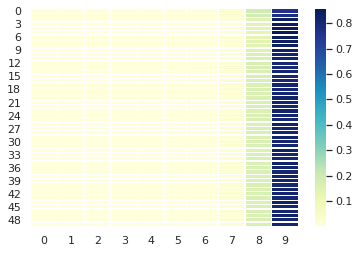

source:  considering odd physical situations of the state it can be said that the maternal mortality rate in the state would be very high 
actual:  <sos> राज्य की विषम भौगोलिक परिस्थितियों को देखते हुये यह कहा जा सकता है कि यहाँ पर मातृ मृत्यु दर काफी अधिक होगी ।
predicted:  एक जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के जाँच जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच
BLEU Score:  0


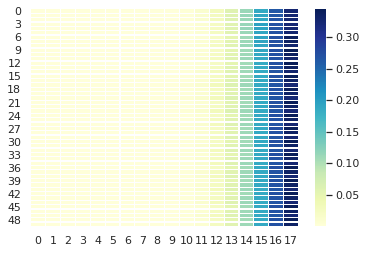

source:  noncommunicable disease is becoming a big cause of death with changes occurring in the life style due to modernization and urbanization 
actual:  <sos> आधुनिकीकरण तथा नगरीयकरण के कारण जीवन शैली में हुए परिवर्तनों से असंचारी रोग भी मृत्यु का एक प्रमुख कारण बन रहे हैं ।
predicted:  एक जाँच के कारण जाँच के कारण एक व्यक्ति के कारण जाँच के व्यक्ति जाँच के व्यक्ति जाँच के कारण जाँच के लिए जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण
BLEU Score:  0


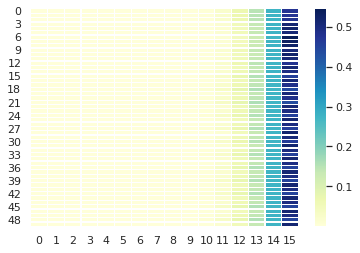

source:  the goal of reproductive and child health welfare programme is to bring about decline in the maternal mortality rate and infant mortality rate 
actual:  <sos>  प्रजनन एवं बाल स्वास्थ्य कार्यक्रम का उद्देश्य माताओं की मृत्यु दर एवं बच्चों की मृत्यु दर में कमी लाना है । 
predicted:  एक जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच
BLEU Score:  0


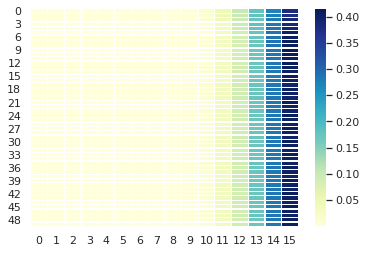

source:  this program is being run to give special importance to the participation of men with relation to reproductive and child health welfare programme  to provide complete knowledge of protected and effective contraceptive methods to men and women  to make medical facilities available to the pregnant women during pregnancy and to help parents get healthy new born babies 
actual:  <sos> प्रजनन एवं बाल स्थास्थ कार्यक्रम के सम्बन्ध में पुरूषों की भागीदारी को विशेष महत्व देने  पुरूष एवं महिला को सुरक्षित एवं असरदार गर्भनिरोधक की विधियों का पूर्ण ज्ञान पहुँचाने  गर्भवती महिला को गर्भावस्था तथा प्रसव के दौरान चिकित्सकीय सुविधायें उपलब्ध कराने तथा दम्पति को स्वस्थ नवजात शिशु प्राप्त करने हेतु यह कार्यक्रम चलाया जा रहा है ।
predicted:  वर्ष में में पहले में पहले में महिला में कैंसर में कैंसर में वर्ष के लिए अवधि की अवधि की अवधि में वर्ष में वर्ष में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


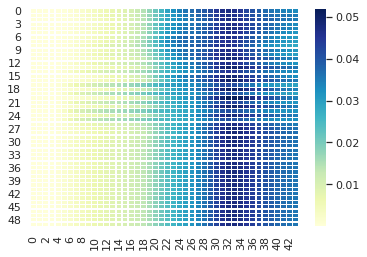

source:  the goal of health programs is to increase the rate of parent security to   percent till     percent till   and  percent till  
actual:  <sos> स्वास्थ्य कार्यक्रमों का लक्ष्य दम्पति सुरक्षा दर को वर्ष  तक  प्रतिशत  वर्ष  तक  एवं  तक  प्रतिशत तक बढ़ाना है ।
predicted:  कारण जाँच के कारण जाँच के कारण एक जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण
BLEU Score:  0


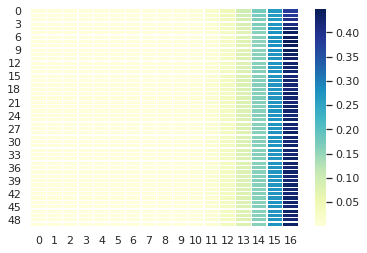

source:  the rate of childbirth security to  percent till    percent till  and institutional childbirths has increased to the maximum 
actual:  <sos> सुरक्षा प्रसव की दर को वर्ष  तक  प्रतिशत  वर्ष  तक  प्रतिशत तथा संस्थागत प्रसवों की संख्या को अधिक से अधिक बढ़ाना है ।
predicted:  कारण कैंसर के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के व्यक्ति व्यक्ति के लिए व्यक्ति की व्यक्ति की व्यक्ति की जाँच हो है । <eos>
BLEU Score:  0.17352228696404481


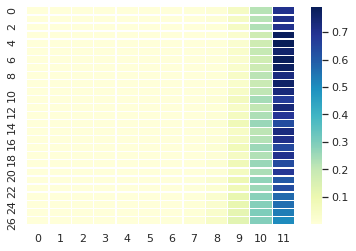

source:  main works under the reproductive and child health programme 
actual:  <sos> प्रजनन एवं बाल स्वास्थ्य कार्यक्रम के अंतर्गत मुख्य कार्य ।
predicted:  जाँच के कारण कारण के कारण कारण जाँच के लिए कारण जाँच से जाँच से लिए लिए जाँच से जाँच से लिए जाँच के लिए जाँच है <eos>
BLEU Score:  0


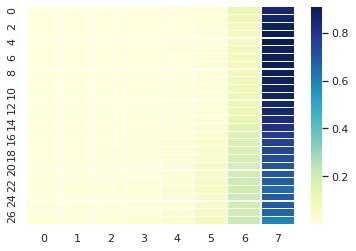

source:  main works being run under the program are as follows 
actual:  <sos> कार्यक्रम के अन्तर्गत चलाये जा रहे मुख्य कार्य निम्न प्रकार हैं ।
predicted:  जाँच के लिए व्यक्ति के लिए लिए व्यक्ति की व्यक्ति की व्यक्ति की जाँच हो है <eos>
BLEU Score:  0


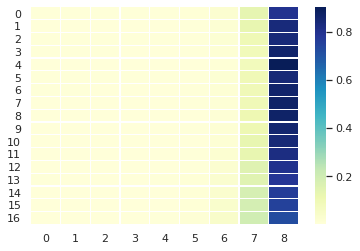

source:  organisation of r    camps 
actual:  <sos> आरसीएच शिविरों का आयोजन ।
predicted:  । <eos>
BLEU Score:  0.19879212680993805


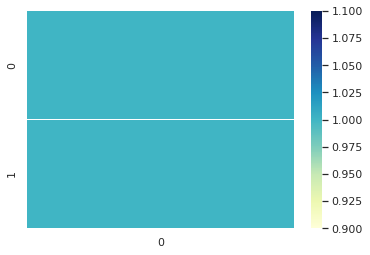

source:  organisation of r    outdoor sessions 
actual:  <sos> आरसीएच आउटरीय सेशनों का आयोजन ।
predicted:  । <eos>
BLEU Score:  0.19953087735062713


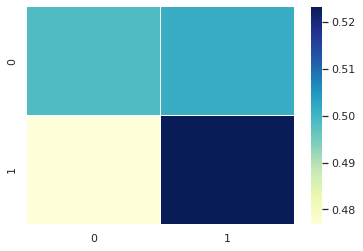

source:  appointment of women health workers on contract 
actual:  <sos> संविदा पर महिला स्वास्थ्य कार्यकर्मियों की तैनाती ।
predicted:  समय इन लिए लिए लिए नाखून का ताजे सेवन । <eos>
BLEU Score:  0.19817632389021378


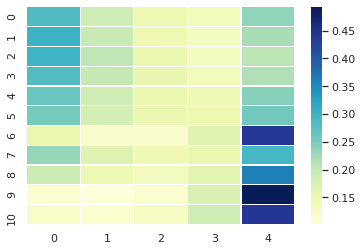

source:  comprehensive construction work and repairing of health units 
actual:  <sos> बृहत निर्माण कार्य एव स्वास्थ्य इकाईयों की मरम्मत नवीनीकरण ।
predicted:  समय इन लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए बुखार । <eos>
BLEU Score:  0.19552795980276136


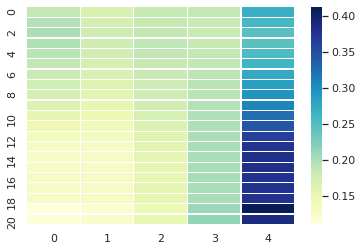

source:  urban reproductive and child health programme 
actual:  <sos> नगरीय प्रजनन एवं बाल स्वास्थ्य कार्यक्रम ।
predicted:  में लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए सुरक्षा लगना । <eos>
BLEU Score:  0.19913749124569236


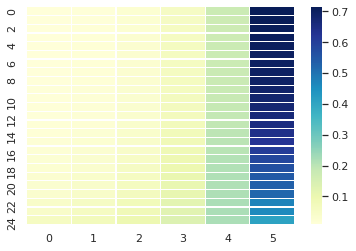

source:  appointment of supplementary a    on contract 
actual:  <sos> संविदा पर अतरिक्त एएनएम की तैनाती ।
predicted:  को लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए बुखार । <eos>
BLEU Score:  0.19913749124569236


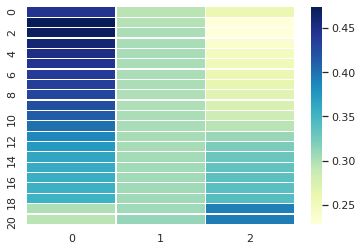

source:  appointment of  supplementary a    on contract basis in the unserved and rural areas has been made to increase the immunisation of mothers and children and the acceptability of contraceptives 
actual:  <sos> असेवित एवं ग्रामीण क्षेत्रो में  अतिरिक्त एएनएम की संविदा के आधार पर तैनाती  माताओं एवं बच्चों के प्रतिरक्षण एवं गर्भ निरोधकों के ग्राह्यता को बढ़ाने हेतु की गयी है ।
predicted:  वर्ष पहले से जाँच का परीक्षण का परीक्षण का कैंसर का कैंसर में क्षेत्र में वर्ष से वर्ष से वर्ष से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर
BLEU Score:  0


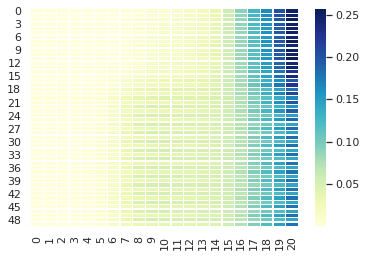

source:  on the directions of the government of india service is being made available at  phcs and  chcs with the goal to provide secure childbirth from  oclock at night to  oclock in the morning at phcs and chcs 
actual:  <sos> प्रास्वाकेन्द्रों एवं सास्वाकेन्द्रों पर रात्रि  बजे से प्रात  बजे तक सुरक्षित प्रसव उपलब्ध कराने के उद्देश्य से भारत सरकार के दिशानिदेशानुसार  प्रास्वाकेन्द्रों एवं  सास्वा केन्द्रों पर सेवा उपलब्ध करायी जा रही हैं ।
predicted:  वर्ष में में पहले में परीक्षण का कैंसर में कैंसर में में वर्ष में वर्ष में वर्ष में वर्ष में कैंसर में कैंसर में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में
BLEU Score:  0


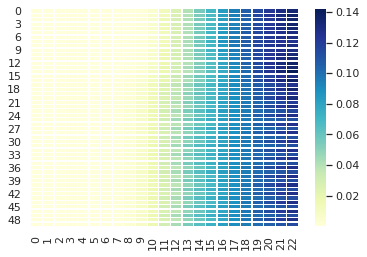

source:   untrained midwives have been trained in uttarakhand in the year of  and  to provide services of safe labor to pregnant mothers 
actual:  <sos> गर्भवती माताओं को सुरक्षित प्रसव की सेवा उपलब्ध कराने हेतु वर्ष  एवं वर्ष  में उत्तराखण्ड में  अप्रशिक्षित दाईयों को प्रशिक्षित किया गया ।
predicted:  वर्ष में में पहले में पहले में अन्तराष्ट्रीय में में क्षति में में संख्या है <eos>
BLEU Score:  0


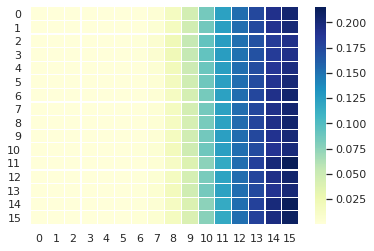

source:   untrained midwives have been trained in the year of  
actual:  <sos> वर्ष  में  अप्रशिक्षित दाईयों को प्रशिक्षित किया गया ।
predicted:  में कारण जाँच के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए सुरक्षा न । <eos>
BLEU Score:  0.1940679506664638


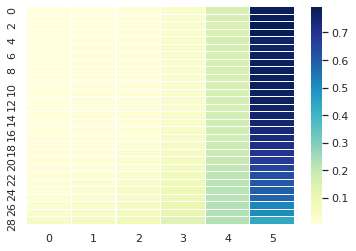

source:   safe maternity counsellors lrb women medical officer rrb were accepted to be appointed by the government of india on a contract basis under the e    scheme 
actual:  <sos> ईएजी कार्यक्रम के अन्तर्गत भारत सरकार से  सुरक्षित मातृत्व परामर्शदाता  महिला चिकित्साधिकारी  को संविदा के आधार पर तैनात किये जाने की स्वीकृति हुई थी ।
predicted:  वर्ष में में पहले में परीक्षण में कैंसर में कैंसर में में वर्ष में वर्ष में वर्ष में कैंसर में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


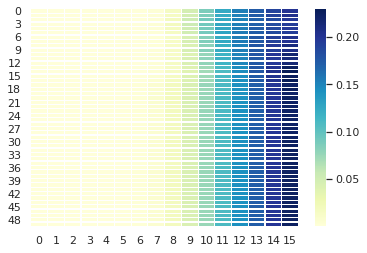

source:  after the advertisements in newspapers for appointment three women medical officers were selected out of which only  women medical officer has reported her contribution at agastyamuni chc of district rudraprayag 
actual:  <sos> तैनाती हेतु समाचार पत्रों में विज्ञापन के पश्चात  महिला चिकित्साधिकारियों का चयन किया गया था जिसमें से मात्र  महिला चिकित्साधिकारी ने सास्वाकेन्द्र अगस्तमुनि जनपद रूदप्रयाग में अपनी योगदान सूचना दी है ।
predicted:  वर्ष एक जाँच का परीक्षण का परीक्षण का कैंसर का कैंसर से क्षेत्र से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से
BLEU Score:  0


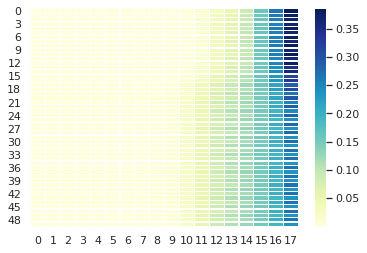

source:  care of the health of women and children and vaccination is being done on a village council level by organising an outreach session on a defined day lrb saturday rrb by women health workers at the level of each village council in the state 
actual:  <sos> राज्य में प्रत्येक ग्रामसभा स्तर पर महिला स्वास्थ्य कार्यकर्मी द्वारा माह के एक निश्चित दिवस  शानिवार  को आउटरीच सत्र का आयोजन कर  महिलाओं एवं बच्चों के स्वास्थ्य की देखभाल एवं टीकाकरण ग्रामसभा स्तर पर किया जा रहा है ।
predicted:  वर्ष में में पहले में पहले में किसी पहले में में में जाँच में में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


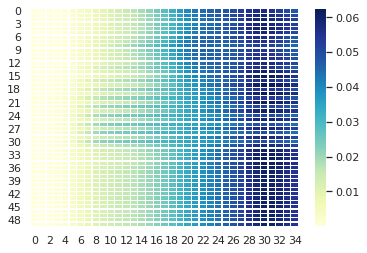

source:  the said program has been scrapped by the govt  of india since july   
actual:  <sos> भारत सरकार द्वारा उक्त कार्यक्रम को माह जुलाई  से समाप्त कर दिया गया है ।
predicted:  से पहले जाँच का परीक्षण परीक्षण के कारण सभी जाँच से जाँच से लिए लिए जाँच से जाँच से लिए जाँच से जाँच से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से सुरक्षा से कैंसर से कैंसर से सुरक्षा से सुरक्षा से
BLEU Score:  0


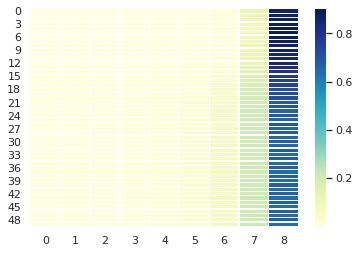

source:  but the above mentioned program is being run in the state with the help of women health workers 
actual:  <sos> किन्तु राज्य में उपरोक्त कार्यक्रम महिला स्वास्थ्य कार्यकर्मी के सहयोग से चलाया जा रहा है ।
predicted:  वर्ष में में दिनों पहले परीक्षण का परीक्षण में कैंसर में में यह में में में जाँच से वर्ष में वर्ष में कैंसर में कैंसर में कैंसर में वर्ष में वर्ष में वर्ष में वर्ष में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में
BLEU Score:  0


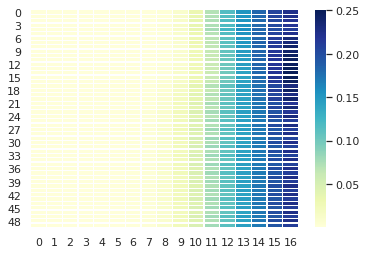

source:  medicines are being bought at the state level under the rch program 
actual:  <sos> आरसीएच कार्यक्रम के अन्तर्गत राज्य स्तर से औषाधियों का क्रय किया जा रहा है ।
predicted:  जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के
BLEU Score:  0


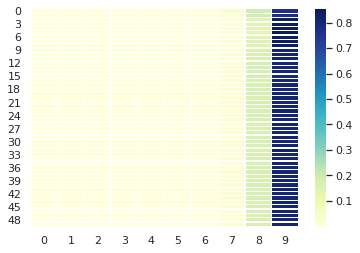

source:  rch kits are being provided directly to the districts by the government of india 
actual:  <sos> आरसीएच किट भारत सरकार से सीधे जनपदों को उपलब्ध कराये जाते है ।
predicted:  एक जाँच से परीक्षण का परीक्षण परीक्षण के कारण जाँच से क्षेत्र से जाँच से जाँच से जाँच से जाँच से जाँच से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर
BLEU Score:  0


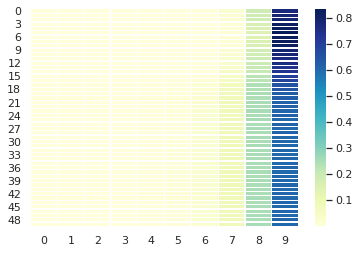

source:  for equipments bought at the level of the state the provision is to purchase after the recommendation of the executive committee constituted at the state level by the purchase committee constituted at the level of the head office 
actual:  <sos> राज्य स्तर से क्रय किये जाने वाले उपकरणों हेतु राज्य स्तर पर गठित कार्यकारिणी समिति के अनुमोदन के पश्‍चात मुख्यालय स्तर पर गठित क्रय समिति द्वारा नियमानुसार क्रय किये जाने का प्राविधान है ।
predicted:  वर्ष में में पहले में पहले में कैंसर में कैंसर में में वर्ष में वर्ष में वर्ष में वर्ष में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


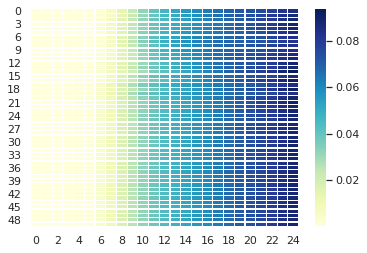

source:  special work has been done in districts in the year of  for propagation of nsv lrb without cut  without stitch rrb method to increase the participation men in population stabilisation 
actual:  <sos> जनसंख्या स्थिरीकरण में पुरूषों की सहभगिता बढ़ाये जाने हेतु एनएसवी  बिना चीरा बिना टांका  पद्धति के प्रचारप्रसार हेतु वर्ष  में जनपदों में विशेष कार्य किया गया ।
predicted:  वर्ष में में पहले में पहले में महिला में में क्षति है है <eos>
BLEU Score:  0


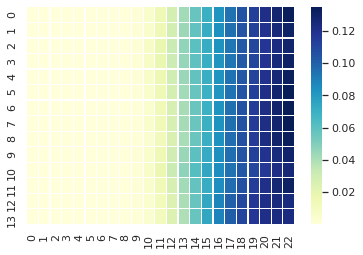

source:  population stabilisation  installation of stable rn hoarding  wall paintings  orientation of the members of the panchayati raj and medical and paramedical staff from the medical department and other media exhibition etc  were done 
actual:  <sos> जनसंख्या स्थिरीकरण स्थायी आरन होर्डिग की स्थापना  वॉल पेंटिंग्स  पंचायती राज सदस्यों का ओरियन्टेशन तथा चिकित्सा विभाग के मेडिकल एवं पैरामेडिकल स्टाफ एवं अन्य मीडिया प्रदर्शन आदि किया गया ।
predicted:  एक जाँच के कारण जाँच के कारण एक एक व्यक्ति के कारण जाँच के व्यक्ति जाँच के व्यक्ति जाँच के कारण जाँच के लिए जाँच के कारण जाँच के कारण जाँच के कारण जाँच के व्यक्ति जाँच के कारण जाँच के लिए जाँच के कारण जाँच के कारण जाँच के
BLEU Score:  0


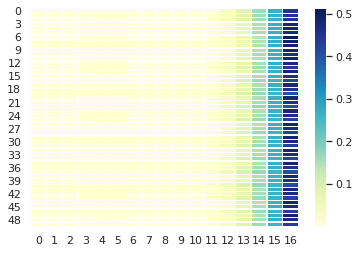

source:  leprosy is a bacteria born contagious disease 
actual:  <sos> कुष्ठ रोग एक जीवाणु से उत्पन्न होने वाला छूत का रोग है ।
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए बुखार । <eos>
BLEU Score:  0.19112328397109352


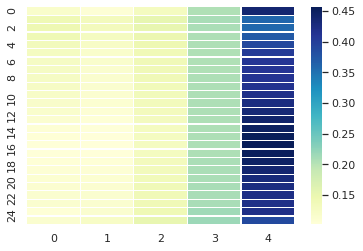

source:  the name of this bacteria is microbacterium leprae 
actual:  <sos> इस जीवाणु का नाम माइकोबेक्टीरियम लैप्री है ।
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए बुखार । <eos>
BLEU Score:  0.19817632389021378


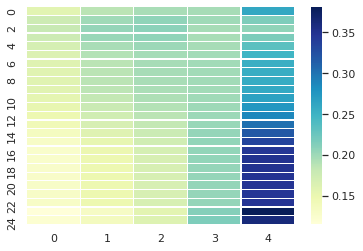

source:  microbacterium leprae affects mainly the nervous system and the skin 
actual:  <sos> माइकोबेक्टीरियम लैप्री मुख्यतया तंत्रिका तंत्र तथा त्वचा को प्रभावित करता है ।
predicted:  में पहले पहले पहले बाद सभी लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए जाँच है <eos>
BLEU Score:  0


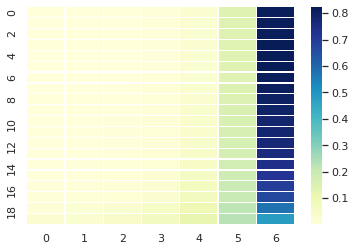

source:  incubation period of leprosy is three years on an average and this disease grows very slowly 
actual:  <sos> कुष्ठ रोग का संक्रमण काल  इनक्यूवेशन पीरियड  औसतन तीन वर्ष है और यह रोग बहुत धीरे  धीरे बढ़ता है ।
predicted:  जाँच के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के लिए व्यक्ति के लिए व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के
BLEU Score:  0


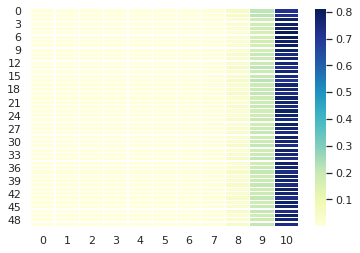

source:  leprosy can affect persons of any age and sex equally 
actual:  <sos> कुष्ठ रोग किसी भी उम्र तथा लिंग के व्यक्तियों को समान रूप से प्रभावित कर सकता है ।
predicted:  कैंसर के लिए लिए लिए व्यक्ति से मिली जाँच हैं <eos>
BLEU Score:  0


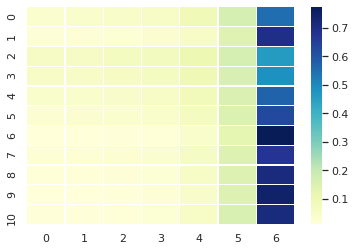

source:  the m    medicine cures the patient completely by eradicating the leprosy bacteria and prevents the disease from spreading in the society 
actual:  <sos> एमडीटी औषधि कुष्ठ रोग जीवाणु को समाप्त कर रोगी को पूर्णतया रोगमुक्त कर देती है तथा समाज में रोग फैलने से बचाती है ।
predicted:  में में पहले में पहले में अन्तराष्ट्रीय में सभी लैन्स में में अवधि में वर्ष में अधिक अधिक अधिक अवधि में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


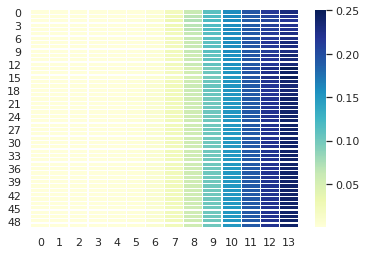

source:  all the leprosy patients are not contagious 
actual:  <sos> समस्त कुष्ठ रोगी संक्रामक नहीं होते ।
predicted:  के लिए लिए लिए कारण जाँच के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए जाँच है <eos>
BLEU Score:  0


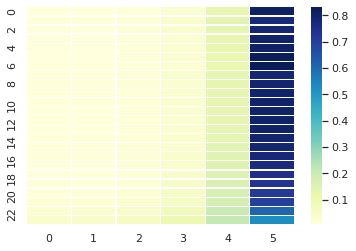

source:  most of the patients are noncontagious who can not spread the disease  only  to  percent patients are contagious 
actual:  <sos> अधिकांश रोगी असंक्रामक होते हैं जो रोग नहीं फैला सकते  मात्र  से  प्रतिशत रोगी ही संक्रामक होते हैं ।
predicted:  वर्ष में में पहले में पहले में महिला में में पहले में में अवधि में वर्ष में अधिक अधिक अधिक अधिक में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


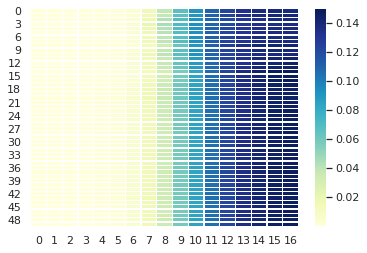

source:  leprosy is comparatively much less contagious than other diseases such as measles    etc 
actual:  <sos> कुष्ठ रोग अन्य रोगों जैसे खसरा  टीबी आदि की तुलना में बहुत ही कम संक्रामक है ।
predicted:  कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के व्यक्ति व्यक्ति के लिए व्यक्ति की व्यक्ति की व्यक्ति की जाँच हो है । <eos>
BLEU Score:  0.18429333166740366


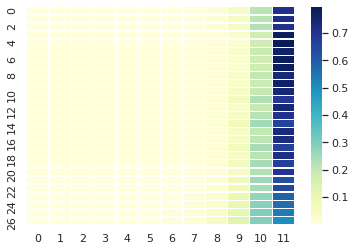

source:  about  percent of the people have the resistance capability to fight leprosy thereby this disease can not happen to them 
actual:  <sos> लगभग  प्रतिशत लोगों में कुष्ठ रोग से लड़ने की प्रतिरोधात्मक क्षमता होती है जिससे उन्हें यह रोग नहीं हो सकता ।
predicted:  एक जाँच के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच
BLEU Score:  0


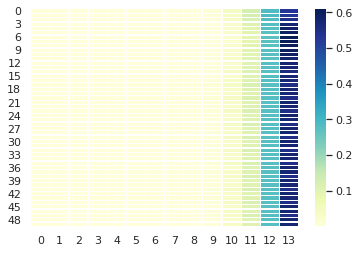

source:  the main symptoms and identification of leprosy are as follows 
actual:  <sos> कुष्ठ रोग के मुख्य लक्षण एवं पहचान निम्नलिखित हैं ।
predicted:  से पहले जाँच का परीक्षण परीक्षण के कारण सभी जाँच से जाँच से लिए लिए जाँच से जाँच से लिए जाँच से जाँच से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से
BLEU Score:  0


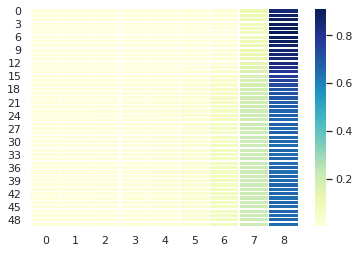

source:  a light yellow or discolored reddish spot or stain on skin of the body that has numbness    the spot has no feeling of pain  inflammation  itching or piercing or cold and hot 
actual:  <sos> शरीर में चमड़ी पर  चमड़ी के रंग से फीका  पीला या लाल सा बदरंग दागघब्बा  जिसमें सुन्नपन हो  अर्थात न दर्द हो  न जलन हो  न खुजली एवं न चुभन हो और न ही ठंडा व गरम का अनुभव हो ।
predicted:  वर्ष में में पहले में पहले में महिला में में कैंसर में में अवधि में वर्ष में वर्ष में अधिक अधिक अधिक अधिक में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0.15927572643859828


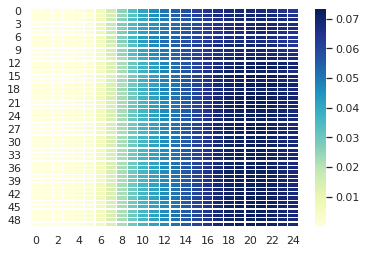

source:  oily shine on the skin 
actual:  <sos> चमड़ी पर तैलीय चमक हो ।
predicted:  और लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए बुखार । <eos>
BLEU Score:  0.19953087735062713


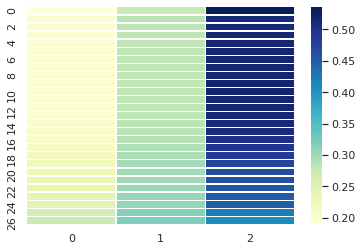

source:  thickness of cyst on skin  eyebrows  chin  ears 
actual:  <sos> चमड़ी पर  भौहों पर  ठोड़ी पर  कानों पर सूजन  मोटापन या गाँठ हो ।
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए बुखार । <eos>
BLEU Score:  0.18429333166740366


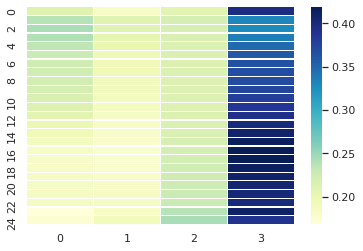

source:  do not do any hard work for three months after the operation of hernia 
actual:  <sos> हर्निया के आपरेशन के बाद तीन महीनों तक कोई मेहनत  मशक्कत का काम न करें ।
predicted:  कारण जाँच के कारण भी के कारण कारण के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच
BLEU Score:  0


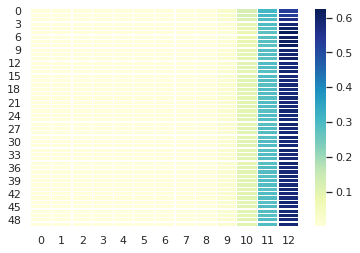

source:  thrilling sensation  numbness or dryness in hands or feet 
actual:  <sos> हाथ पैरों में झंझनाहट  सुन्नपन व सूखापन हो ।
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए सुरक्षा । <eos>
BLEU Score:  0.19552795980276136


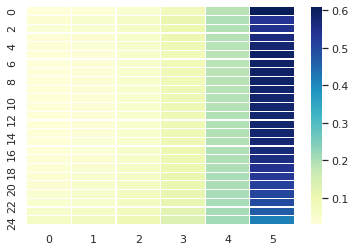

source:  occurrence of deformation in the fingers of hands or feet 
actual:  <sos> हाथ पैरों की अंगुलियों में विकृति आ रही हो ।
predicted:  जाँच के लिए लिए व्यक्ति से चलाया है । <eos>
BLEU Score:  0.19552795980276136


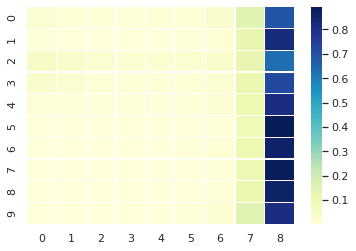

source:  initiation and spread of leprosy 
actual:  <sos> कुष्ठ रोग की शुरूआत व प्रसार ।
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए बुखार । <eos>
BLEU Score:  0.19913749124569236


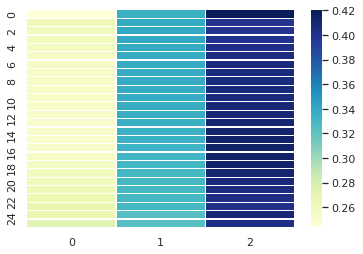

source:  leprosy often starts with a spot or freckle on the body that is numb 
actual:  <sos> प्रायः कुष्ठ रोग की शुरूआत शरीर पर चकत्ते या दाग से हो सकती है जो सुन्न होता है ।
predicted:  जाँच के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के लिए व्यक्ति की व्यक्ति की व्यक्ति की जाँच की जाँच हो है । <eos>
BLEU Score:  0.18305025818318518


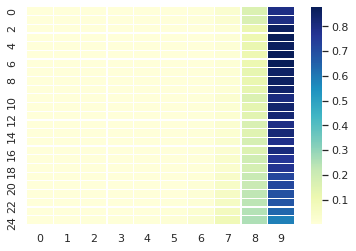

source:  if this gets treated in the initial stage then the disease is cured completely and the disability does not get aroused in it that is the main reason of social excommunication 
actual:  <sos> यदि इस प्राथमिक अवस्था में ही इसका इलाज करा लिया जाये तो रोग पूरी तरह से ठीक हो जाता है और उसमें वह विकलांगता पैदा नहीं होने पाती जो सामाजिक बहिष्कार का मुख्य कारण है ।
predicted:  वर्ष पहले से पहले परीक्षण का परीक्षण का कैंसर में कैंसर में में यह में यह यह यह यह यह यह यह कैंसर में वर्ष की कैंसर में कैंसर में वर्ष की कैंसर में कैंसर में वर्ष की कैंसर में कैंसर में वर्ष की कैंसर में कैंसर में कैंसर की
BLEU Score:  0


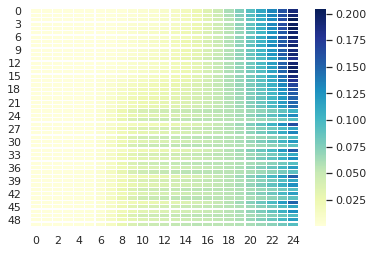

source:  if the treatment is not done due to careless or lack of right information about leprosy then the disease keeps on growing 
actual:  <sos> कुष्ट रोग की सही जानकारी न होने अथवा लापरवाही के कारण इलाज न कराया जाये तो रोग बढ़ता ही जाता है ।
predicted:  कारण जाँच के कारण जाँच के कारण भी परीक्षण के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण
BLEU Score:  0


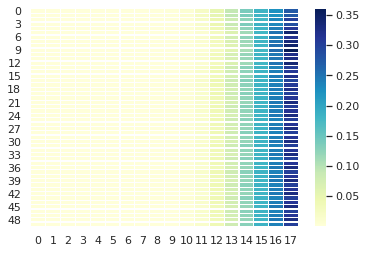

source:  fingers start becoming malformed  wounds erupt in hands and feet and the face starts looking ugly 
actual:  <sos> अंगुलियाँ टेढ़ी होने लगती हैं  हाथ पैरों में घाव हो जाते हैं व चेहरा भद्दा लगने लगता है ।
predicted:  में में पहले में पहले में अन्तराष्ट्रीय में सभी पहले में में अवधि में वर्ष में अधिक अधिक अधिक अवधि में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0.18068537884315472


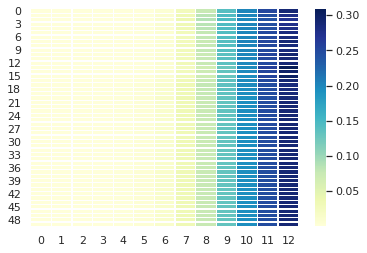

source:  most of the people reach the doctor for advice in this stage 
actual:  <sos> ज्यादातर लोग इसी अवस्था में चिकित्सक की सलाह लेने पहुँचते हैं ।
predicted:  पहले जाँच का परीक्षण का परीक्षण के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण
BLEU Score:  0


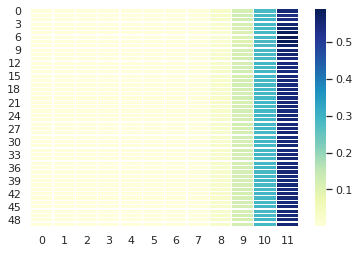

source:  wounds and ulcer form because of no care for the numb and insensitive parts of the leprosy patients 
actual:  <sos> कुष्ठ रोगी के सुन्न एवं असंवेदनशील अंगों की देखभाल न होने के फलस्वरूप घाव एवं अल्सर बन जाते हैं ।
predicted:  कारण जाँच के कारण एक व्यक्ति के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण
BLEU Score:  0


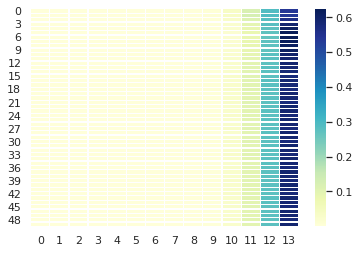

source:  complete treatment is possible even in the stage of wound and ulcer but the disability and deformity that occurred due to lateness in treatment can not be brought back to the previous state through medicines 
actual:  <sos> घाव एवं अल्सर की अवस्था में भी रोगी का पूर्ण इलाज संभव है परन्तु इलाज में देरी हो जाने के कारण जो विकलांगता और विरूपता आ चुकी है उसे दवा के जरिये दूर करके फिर पहले जैसी स्थिति नहीं लाई जा सकती ।
predicted:  वर्ष में में पहले में पहले में महिला में में कैंसर में में अवधि के लिए अवधि की अवधि के लिए अवधि की अवधि में अधिक अधिक अधिक अधिक अधिक में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


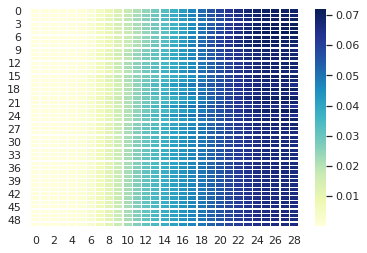

source:  yes  the hands and feet of the disabled person can be formed in such a way through simple operations so that the patient can work again and run his livelihood 
actual:  <sos> हाँ  विकलांग व्यक्ति का मामूली ऑपरेशन करके हाथ पैरों को इस प्रकार बनाया जा सकता है कि रोगी फिर से काम धन्धे कर सके और अपनी जीविका चला सके ।
predicted:  वर्ष प्रजनन से पहले परीक्षण का परीक्षण में कैंसर में कैंसर में में वर्ष में वर्ष की वर्ष में वर्ष की कैंसर में कैंसर में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष
BLEU Score:  0


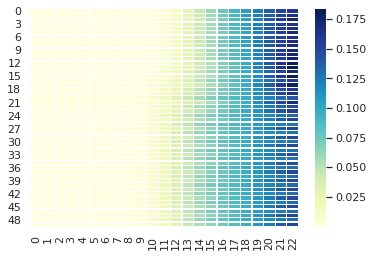

source:  malaria spreads through the bite of female anopheles mosquito 
actual:  <sos> मलेरिया रोगाणु मादा एनाफिलीज मच्छर के काटने से फैलता है ।
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए सुरक्षा है <eos>
BLEU Score:  0


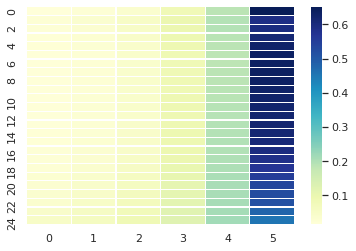

source:  female anopheles mosquitoes get born in clean water and bites at night 
actual:  <sos> मादा एनाफिलीज मच्छर साफ पानी में पैदा होते हैं और रात में काटते हैं ।
predicted:  धीरे धीरे धीरे लेकिन खाली अवधि के लिए लिए बाद दिनों कारण प्रसार है <eos>
BLEU Score:  0


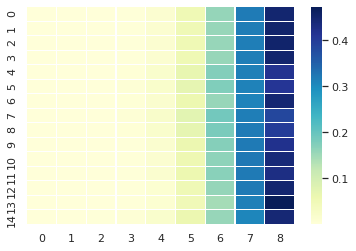

source:  fever along with shivering and cold comes often the third day 
actual:  <sos> कंपकपी एवं जाड़े के साथ प्रायः तीसरे दिन बुखार आता है ।
predicted:  धीरे धीरे लेकिन खाली सभी अवधि के लिए लिए बाद दिनों लिए लिए प्रसार में कमजोरी कमजोरी चिकित्सालय पाया है <eos>
BLEU Score:  0


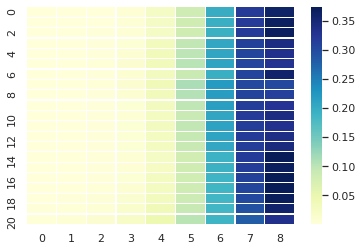

source:  you must change water collected in pots at home once a week 
actual:  <sos> घर के बर्तनों में एकत्रित पानी को सप्ताह में psp एक बार अवश्य बदलें ।
predicted:  धीरे है <eos>
BLEU Score:  0


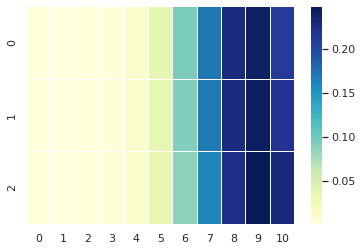

source:  use mosquito nets while sleeping or apply mustard oil on open parts of the body 
actual:  <sos> सोते समय मच्छरदानी प्रयोग करें अथवा सरसों नीम का तेल शरीर के खुले अंगों पर लगायें ।
predicted:  कारण के लिए लिए व्यक्ति के लिए भी जाँच में में भी भी होते है <eos>
BLEU Score:  0


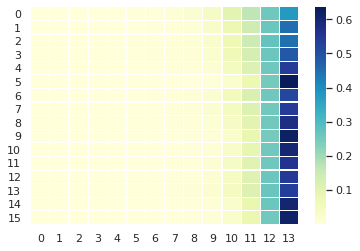

source:  install fine nets on windows of house 
actual:  <sos> घर की खिड़कियों दरवाजों रोशनदानों पर महीन जाली लगवायें ।
predicted:  में बाद लिए कारण परीक्षण के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए जाँच का लिए लिए जाँच है <eos>
BLEU Score:  0


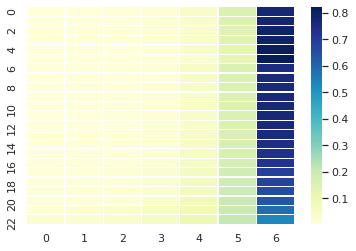

source:  do not let water collect near yourself 
actual:  <sos> अपने आसपास पानी इकट्ठा न होने दें ।
predicted:  कैंसर के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए कम । <eos>
BLEU Score:  0.19817632389021378


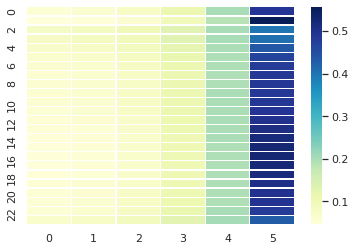

source:  if this is not possible then pour some petrolubricants oil on the collected water 
actual:  <sos> यदि ऐसा संभव न हो तो इकट्ठे पानी पर जले मोबिल डीजल मिट्टी के तेल की कुछ मात्रा डालें ।
predicted:  जाँच शरीर के कारण व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति जाँच हो है । <eos>
BLEU Score:  0.18184804078107475


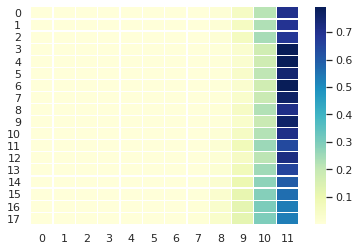

source:  the disease of measles can take a very serious form in developing countries because the death rate due to this is more than  percent 
actual:  <sos> विकासशील देशों में मीजल्स की बीमारी काफी गंभीर रूप ले सकती है  क्योंकि इसके कारण होने वाली मृत्यु दर  प्रतिशत से अधिक है ।
predicted:  कैंसर एक जाँच के कारण जाँच के कारण परीक्षण के कारण जाँच के कारण जाँच के जाँच एक जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के
BLEU Score:  0


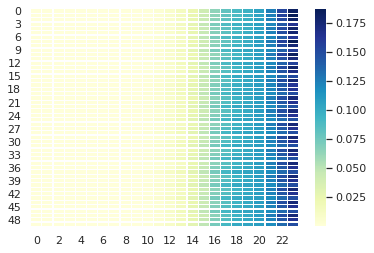

source:  therefore it is recommended to administer its vaccination to the children at the earliest possible 
actual:  <sos> इसलिये जितनी जल्दी हो सके बच्चों को इसका टीका लगवाने की सिफारिश की जाती है ।
predicted:  में में पहले में पहले में महिला में में सभी क्षति में में संख्या है <eos>
BLEU Score:  0


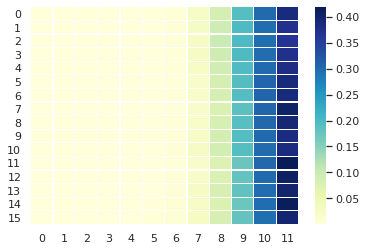

source:  besides the antibody level of mothers and doses of vaccination  considering the incidents of the disease it is recommended by the world health organisation to administer the vaccine of measles to the children at the age of nine months 
actual:  <sos> माँ के एंटीबॉडी स्तर और टीके की खुराक के अलावा  बीमारी की घटनाओं को देखते हुए विश्‍व स्वास्थ्य संगठन द्वारा बच्चों को नौ महीने की उम्र मे मीजल्स का टीका लगवाने की सिफारिश की जाती है ।
predicted:  वर्ष में में पहले में परीक्षण का कैंसर में कैंसर में में वर्ष में वर्ष में वर्ष की कैंसर में कैंसर में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में
BLEU Score:  0


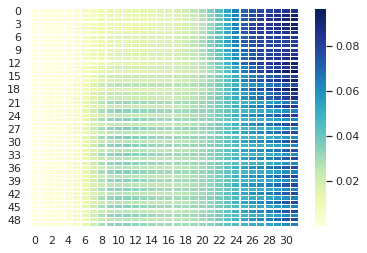

source:  among the indications and symptoms of measles are included  fever  common symptoms of cold  conjunctivitis  cough  stains inside mouths and the red papules erupting on the skin 
actual:  <sos> मीजल्स के संकेतों एवं लक्षणों मे शामिल हैं  बुखार  सर्दी के सामान्य लक्षण  कंजेक्टीवाइटिस  खाँसी  मुँह के अंदर दाग और त्वचा पर निकलने वाले लाल दानें ।
predicted:  वर्ष में में पहले में पहले में कैंसर में में कैंसर में में अवधि में वर्ष में वर्ष में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


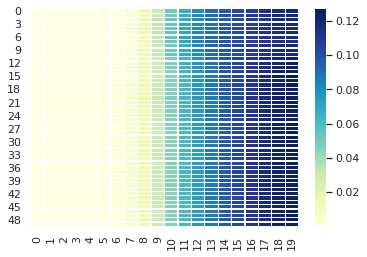

source:  besides this  loose motion  stomach ache and lack of hunger like symptoms may also be show up during the contraction 
actual:  <sos> इसके अलावा  संक्रमण के दौरान दस्त  पेट दर्द और भूख कम हो जाने जैसे लक्षण भी दिखाई दे सकते हैं ।
predicted:  एक जाँच के कारण जाँच के कारण एक जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण
BLEU Score:  0


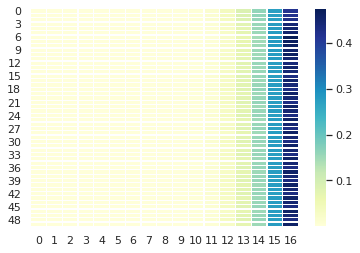

source:  in comparison with children the symptoms of measles shows up more seriously in adolescents  its incubation period is about  days and almost no symptoms of this disease shows up from outside during this period 
actual:  <sos> मीजल्स के लक्षण  बच्चों की तुलना में किशोरों में अधिक गंभीर रूप में दिखाई देते हैं  इसकी उद्‍भवन अवधि  इनक्यूबेशन अवधि  लगभग  से  दिन होती है और इस अवधि के दौरान बाहर से इस बीमारी के लगभग कोई लक्षण दिखाई नहीं देते ।
predicted:  वर्ष में में पहले में पहले में अन्तराष्ट्रीय में कैंसर में में में अवधि के लिए अवधि के लिए अवधि की अवधि में वर्ष में अधिक अधिक अधिक में में में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


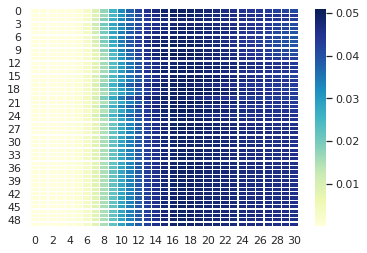

source:  during the period of  to  days  at first a local contraction occurs due to the virus in the breathing passage and then the contagion spreads into other parts of the body as well 
actual:  <sos>  से  दिन की अवधि के दौरान वायरस के कारण सबसे पहले उपरी श्‍वासोच्छवास मार्ग मे स्थानीय  लोकल  संक्रमण हो जाता है और फिर यह संक्रमण शरीर के अन्य हिस्सों मे भी फैल जाता है ।
predicted:  वर्ष में में पहले में पहले में महिला में कैंसर में कैंसर में वर्ष के लिए अवधि की अवधि के लिए अवधि की अवधि में वर्ष में वर्ष में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


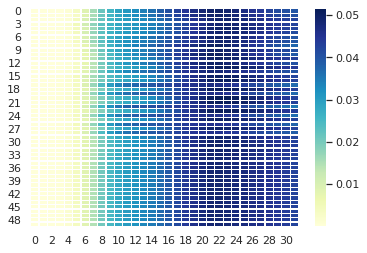

source:  after this having spread through the whole of the blood circulation the virus takes the form of primary disease 
actual:  <sos> इसके बाद यह वायरस पूरे रक्तप्रवाह में फैलकर प्राइमरी बीमारी का रूप ले लेता है ।
predicted:  एक जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच
BLEU Score:  0


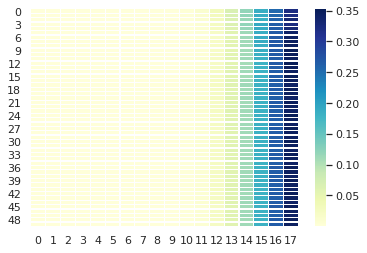

source:  the period between the entrance of the bacteria and the start of the disease 
actual:  <sos> वैक्टीरिया वायरस के प्रवेश और बीमारी के आरंभ के बीच की अवधि ।
predicted:  एक जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच
BLEU Score:  0


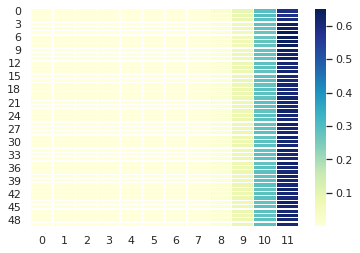

source:  mumps or contagious perotitis is a kind of serious contagious disease in which a swelling emerges in one or both of saliva glands near the jaws and starts paining 
actual:  <sos> मम्पस्  गलसुआ  या संक्रामक पेराटाइटिस एक तरह की गंभीर संक्रामक बीमारी है  जिसमें जबड़े के आसपास मौजूद एक या दोनों लार ग्रंथियों मे सूजन आ जाती है और दर्द होने लगता है ।
predicted:  एक एक जाँच के कारण जाँच के कारण जाँच के कारण एक जाँच के जाँच जाँच के जाँच एक जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच
BLEU Score:  0


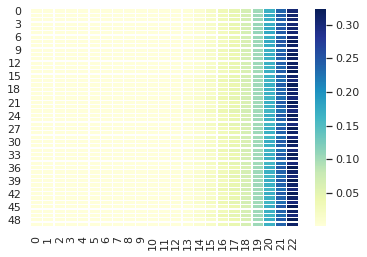

source:  saliva glands are present inside the cheeks in front of the ears and respectively on the lower surface of the mouth 
actual:  <sos> लार ग्रंथियाँ कान के सामने की तरफ गालों के भीतर और क्रमशः मुँह की निचली सतह पर मौजूद होती हैं ।
predicted:  वर्ष में में पहले में पहले में अन्तराष्ट्रीय में में क्षति में में संख्या है है और वर्ष के लिए अवधि की अवधि की अवधि में अधिक अधिक अधिक अधिक अधिक में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


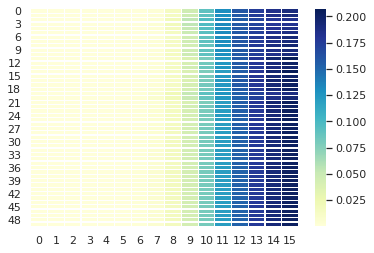

source:  besides this  mouth also starts drying up due to mumps 
actual:  <sos> इसके अलावा  मम्पस बीमारी  के कारण मुँह भी सूखने लगता है ।
predicted:  जाँच के लिए लिए व्यक्ति से चलाया है । <eos>
BLEU Score:  0.18968126713037053


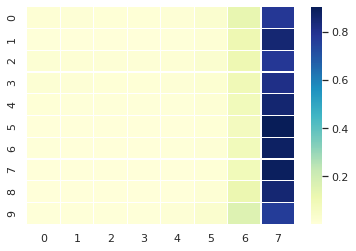

source:  the treatment of cataract is possible through surgery only 
actual:  <sos> मोतियाबिंद का उपचार केवल शल्यचिकित्सा द्वारा ही सम्भव है ।
predicted:  जाँच के कारण जाँच के कारण कारण के लिए कारण जाँच के लिए कारण जाँच के लिए लिए जाँच से जाँच से लिए जाँच से जाँच से लिए जाँच की लिए जाँच है <eos>
BLEU Score:  0


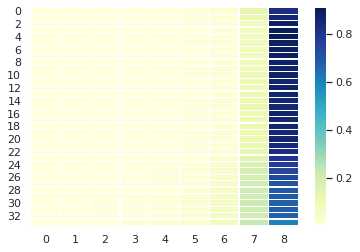

source:  complete lens capsule is taken out in the method of intra capsular cataract extraction  after the operation spectacles are used posttest 
actual:  <sos> इन्ट्रा कैनसूलर कैटरेक्ट एक्सट्रेक्शन  intra capsular cataract extraction  विधि में पूरा लैन्स कैपस्यूल निकाला जाता है  ऑपरेशन के बाद जाँच के उपरान्त चश्में का प्रयोग किया जाता है ।
predicted:  में में प्रजनन में पहले में पहले में पहले में में अवधि के लिए अवधि के लिए अवधि की अवधि में वर्ष में अधिक अधिक अधिक अधिक में में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


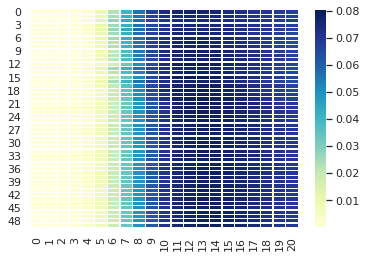

source:  during operation lens is implanted at front of the iris  the frontal part of the eye 
actual:  <sos> ऑपरेशन के दौरान लैन्स प्रत्यारोपण आँख के अगले भाग  आइरिस के आगे किया जाता है ।
predicted:  वर्ष में में पहले में पहले में अन्तराष्ट्रीय में में क्षति में में संख्या है है और वर्ष के लिए अवधि की अवधि की अवधि में अधिक अधिक अधिक अधिक अधिक में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


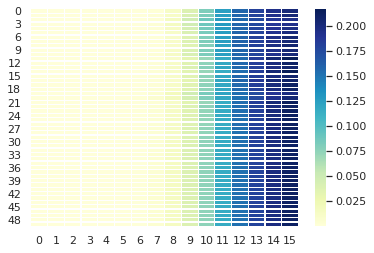

source:  in the extra capsular cataract method  the part of the frontal capsule and the whole of the lens matter is extracted and the posterior part of the capsule is left intact 
actual:  <sos> इक्स्ट्रा कैनसूलर कैटरेक्ट एक्सट्रेक्शन विधि में सामने वाला कैपस्यूल का हिस्सा तथा पूरा लैन्स मैटर निकाल लिया जाता है और पीछे वाला कैपस्यूल सुरक्षित छोड़ दिया जाता है ।
predicted:  में में प्रजनन में पहले में अन्तराष्ट्रीय में अन्तराष्ट्रीय में में क्षति है <eos>
BLEU Score:  0


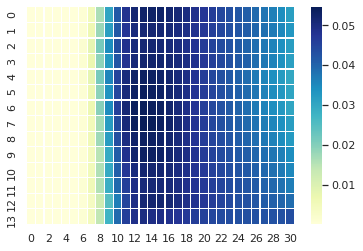

source:  lens is fitted in the capsular bag 
actual:  <sos> कैपस्यूलर बैग में लैन्स फिट किया जाता है ।
predicted:  में पहले पहले पहले बाद सभी लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए जाँच है <eos>
BLEU Score:  0


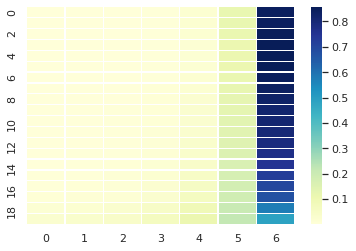

source:  in the s     lrb small incision cataract surgery rrb method   mm tunnel is formed while the rest of the method follows like that of the ecceiol 
actual:  <sos> sics  small incision cataract surgry  विधि में  मिमी की एक टनल बनाई जाती है शेष विधि ecce–iol की तरह होती है ।
predicted:  में में प्रजनन में पहले में अन्तराष्ट्रीय में पहले में में में में अवधि के लिए अवधि के लिए अवधि के लिए अवधि के लिए अवधि के लिए अवधि के लिए अवधि के लिए अवधि के लिए अवधि के लिए अवधि के लिए अवधि के लिए अवधि के लिए अवधि
BLEU Score:  0


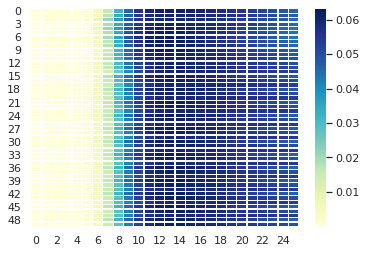

source:  no stitches are applied in the s     lrb small incision cataract surgery rrb method 
actual:  <sos> sics  small incision cataract surgry  विधि में टाँके नही लगाये जाते हैं ।
predicted:  में में पहले ग्रंथी में पहले में अवधि के लिए अवधि के लिए पहले में अन्तराष्ट्रीय में खाली खाली में अवधि में बोतलों में ऊपर में अधिक अधिक अधिक अवधि में ऊपर में ऊपर में ऊपर में ऊपर में ऊपर में ऊपर में ऊपर में ऊपर में ऊपर में ऊपर
BLEU Score:  0


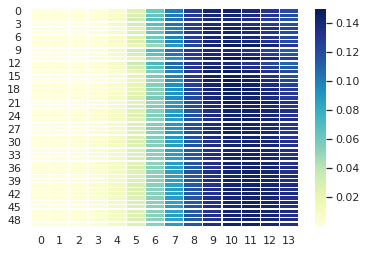

source:  in black cataract the eye nerves dilapidates gradually  it happens due to extra water pressure in the eye or because of not enough blood reaching in the eye nerves 
actual:  <sos> काला मोतियाबिंद में नेत्र तंत्रिका धीरे धीरे नष्ट होती है आँख में पानी का दबाव ज्यादा होने की वजह से या नेत्र तंत्रिका में रक्त पर्याप्त मात्रा में न पहुँचने की वजह से ऐसा होता है ।
predicted:  वर्ष में में पहले में पहले में महिला में कैंसर में कैंसर में वर्ष के लिए अवधि की अवधि के लिए अवधि की अवधि में वर्ष में वर्ष में अधिक अधिक अधिक अधिक अधिक में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


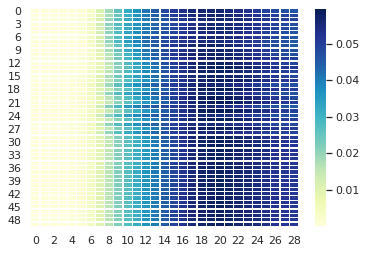

source:  the blindness caused by the black cataract can be prevented if it is identified soon and its regular treatment and tests continue 
actual:  <sos> काले मोतियाबिंद से होने वाली अधंता अंधता को रोका जा सकता है यदि इसका पता जल्दी लग जाए तथा इसका नियमित इलाज व जाँच होती रहे ।
predicted:  वर्ष में में पहले में पहले में अन्तराष्ट्रीय में कैंसर में में अवधि में वर्ष में वर्ष में अधिक अधिक अधिक अधिक में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0.17352228696404481


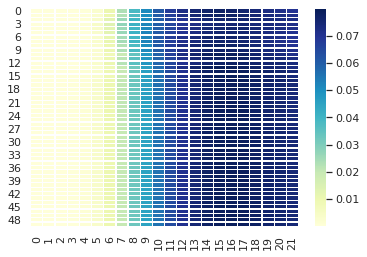

source:  when the extra pressure is more in the eyes 
actual:  <sos> जब आँखों में अतिरिक्त दबाव ज्यादा हो ।
predicted:  जाँच के कारण व्यक्ति के कारण कारण के कारण व्यक्ति के कारण जाँच के लिए कारण जाँच के लिए कारण जाँच के लिए जाँच से जाँच से जाँच से लिए जाँच हो है <eos>
BLEU Score:  0


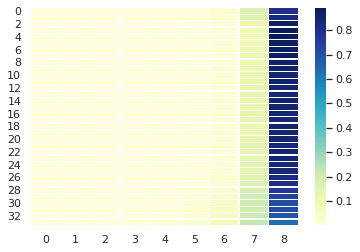

source:  if somebody suffers from black cataract in the family 
actual:  <sos> यदि परिवार में किसी को काला मोतियाबिंद हो ।
predicted:  जाँच के लिए व्यक्ति के लिए व्यक्ति के लिए व्यक्ति जाँच की व्यक्ति की व्यक्ति की जाँच हो है <eos>
BLEU Score:  0


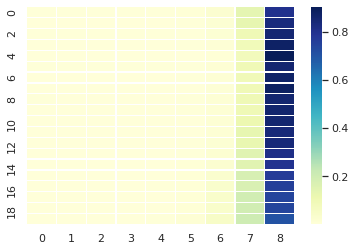

source:  in most of the patients the part of the water channel from the eyes are open yet for some reasons the water gets lessened 
actual:  <sos> अधिकांश मरीजों में आँख से पानी जाने का हिस्सा खुला होता है फिर भी कुछ कारणवस कारणवश पानी कम जाता है ।
predicted:  वर्ष में में पहले में पहले में महिला में में कैंसर में में अवधि में वर्ष में अधिक अधिक अधिक अधिक में में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


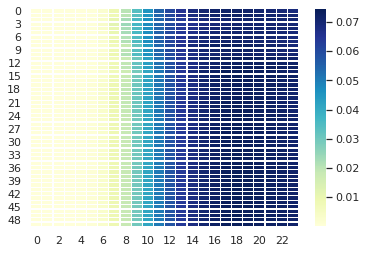

source:  internal pressure keeps on increasing and the eye nerves dilapidates  gradually the patient can not see things around  eyesight might also be lost if treatment is not done in time 
actual:  <sos> अंदर का दबाव बढ़ता जाता है और नेत्र तंत्रिका नष्ट होती है  धीरे  धीरे मरीज अगलबगल की चीजें नहीं देख पाता है  अगर समय पर इलाज न किया जाए तो नजर भी जा सकती है ।
predicted:  वर्ष में में पहले में पहले में महिला में कैंसर में वर्ष में वर्ष के लिए अवधि की अवधि की अवधि में वर्ष में वर्ष में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


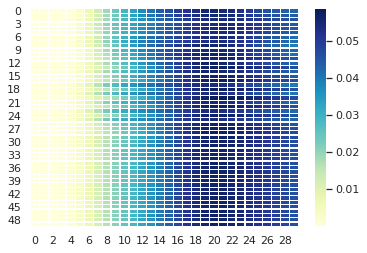

source:  main symptoms on appearance of which a patient should consult a doctor 
actual:  <sos> प्रमुख लक्षण जिनके प्रकट होने पर रोगी को डॉक्टर से जाँच करानी चाहिए ।
predicted:  पहले से जाँच का परीक्षण का परीक्षण के कारण जाँच से क्षेत्र से कैंसर से जाँच से कैंसर से जाँच से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर
BLEU Score:  0


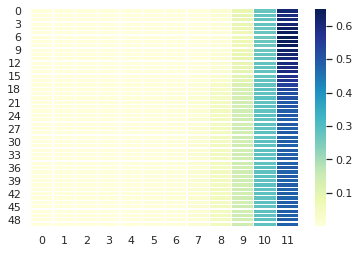

source:  seeing rainbow like colorful ovals in light 
actual:  <sos> रोशनी मे इंद्र धनुष के समान रंगीन गोले दिखाई देना ।
predicted:  में पहले पहले जाँच के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए जाँच है <eos>
BLEU Score:  0


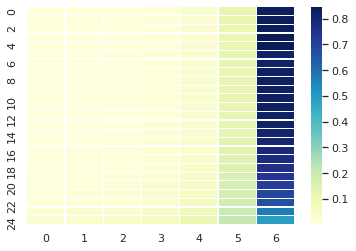

source:  we will check the eye nerves with special lens or equipment to find how much of damage has occurred 
actual:  <sos> विशेष लैन्स या यंत्र के द्वारा नेत्र तंत्रिका की जाँच करेंगे की कितनी क्षति पहुँची है ।
predicted:  वर्ष में में पहले में पहले में महिला में में कैंसर में में अवधि में वर्ष में वर्ष में अधिक अधिक अधिक अधिक में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


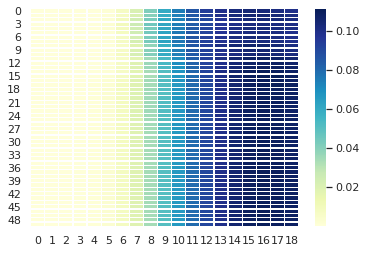

source:  field test  in which the capacity to see things on the sides while looking straight is tested 
actual:  <sos> फिल्ड टेस्ट जिसमें सामने देखते हुए साइड की चीजें देख सकने की क्षमता की जाँच होती है ।
predicted:  वर्ष में में पहले में पहले में महिला में में पहले में में अवधि में वर्ष में अधिक अधिक अधिक अवधि के लिए अवधि के लिए अवधि की अवधि में वर्ष में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


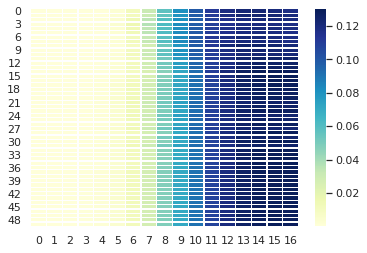

source:  the part lrb angle rrb from where the water passes out can be seen through a special lens 
actual:  <sos> एक विशेष लैन्स द्वारा पानी के बाहर जाने के हिस्से  एंगल  को देख सकते हैं ।
predicted:  वर्ष में में दिनों पहले परीक्षण का परीक्षण में कैंसर में में यह में में में जाँच से वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में
BLEU Score:  0


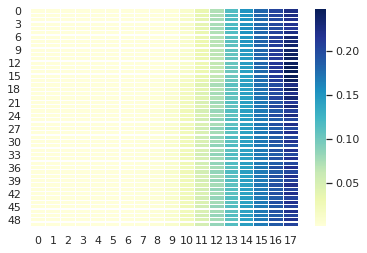

source:  with the lack of vitamina the cornea becomes weak and a wound appears through which at last causes blindness 
actual:  <sos> विटामिनए की कमी से कॉर्नियल कमजोर तथा घाव हो जाते हैं जिससे अन्त में अन्धापन होता है ।
predicted:  कैंसर जाँच के कारण व्यक्ति के व्यक्ति के लिए व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति जाँच के व्यक्ति जाँच के लिए जाँच की जाँच की जाँच की जाँच हो है । <eos>
BLEU Score:  0.18429333166740366


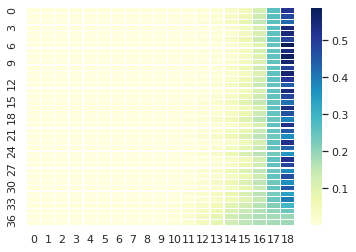

source:  the lack of vitamina is even more imminent in states of measles and malnutrition 
actual:  <sos> विटामिनए की कमी खसरे तथा कुपोषण की स्थिति में और अधिक होती है ।
predicted:  कैंसर कैंसर के लिए व्यक्ति से रूप से जन्म से कैंसर हो है । <eos>
BLEU Score:  0.18968126713037053


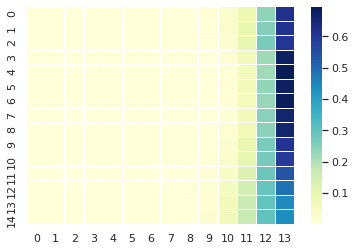

source:  nyctalopia may occur due to lack of vitamina 
actual:  <sos> विटामिनए की कमी से रतौंधी हो सकती है ।
predicted:  जाँच के लिए लिए व्यक्ति से चलाया है । <eos>
BLEU Score:  0.1969244213551724


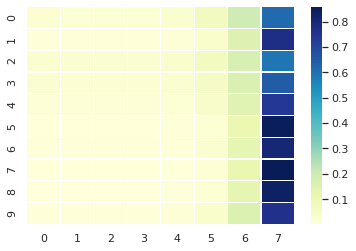

source:  absorption of vitamina during lack of vitamina in food  continuous diarrhoea and malnutrition 
actual:  <sos> खाने में विटामिनए की मात्रा की कमी लगातार दस्त तथा कुपोषण में विटामिनए का अवशोषण  absorption  कम होना ।
predicted:  कैंसर कैंसर के लिए कैंसर से कैंसर से कैंसर की जाँच हो है । <eos>
BLEU Score:  0.18068537884315472


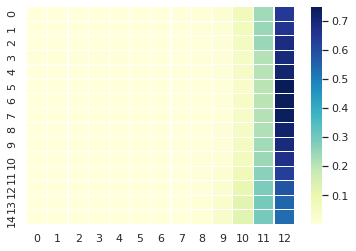

source:  demand of vitamina during and after measles 
actual:  <sos> खसरे के समय व बाद में विटामिनए की मांग का अधिक होना ।
predicted:  परिणाम इन कष्ट है <eos>
BLEU Score:  0


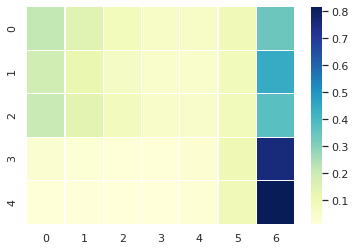

source:  it is visible in dim light 
actual:  <sos> कम रोशनी में दिखाई देता है ।
predicted:  कैंसर के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए जाँच । <eos>
BLEU Score:  0.19913749124569236


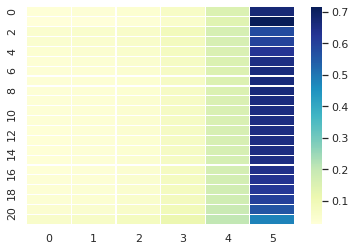

source:  white surface dries up 
actual:  <sos> स्वेत पटल सूखा हो जाता है ।
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए बुखार । <eos>
BLEU Score:  0.19913749124569236


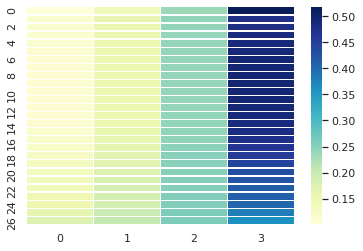

source:  bitot s spots  white spots shows up on white surface 
actual:  <sos> बिटोटस स्पॉट्स  श्वेत श्‍वेत पटल पर श्वेत श्‍वेत धब्बे दिखाई देते हैं ।
predicted:  धीरे धीरे लेकिन खाली संख्या है <eos>
BLEU Score:  0


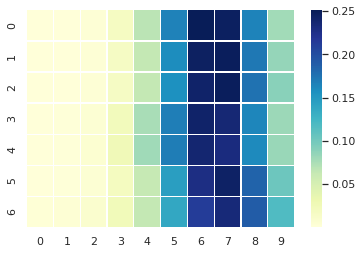

source:  use gram leaves  fenugreek or methi leaves  spinach  cabbage  coriander  papaya  mango in diet to prevent nyctalopia 
actual:  <sos> रतौंधी से बचने के लिए चौलाई  चने का साग  मैथी का साग  पालक  बन्दगोभी  धनिया  गाजर  पपीता  आम आदि का सेवन करें ।
predicted:  में में पहले ग्रंथी में पहले में पहले में अवधि के लिए अवधि है <eos>
BLEU Score:  0


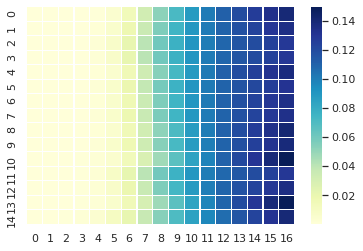

source:  encouraging mother for milk 
actual:  <sos> माँ को दूध के लिए प्रोत्साहित करना ।
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए बुखार । <eos>
BLEU Score:  0.19817632389021378


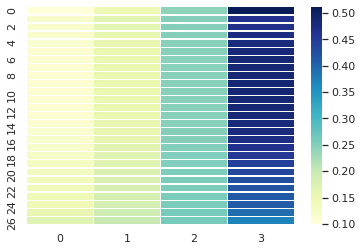

source:  applying vaccine at the time of measles 
actual:  <sos> खसरे का समय पर टीका लगाना ।
predicted:  कैंसर के लिए लिए लिए कारण अपना परीक्षण का लिए लिए लिए जाँच हो । <eos>
BLEU Score:  0.19913749124569236


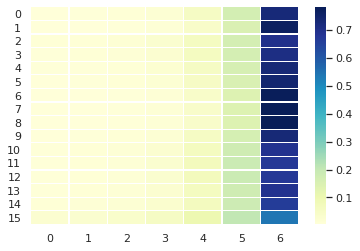

source:  giving doses of vitamina lrb  mn i   rrb during measles and at an interval of  months till  years lrb  mn i   rrb 
actual:  <sos> विटामिनए की खुराक   लाख आईयू   खसरे के टीके समय तथा  वर्ष तक   लाख आईयू   माह के अन्तराल पर देना ।
predicted:  एक एक जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के जाँच एक जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के
BLEU Score:  0


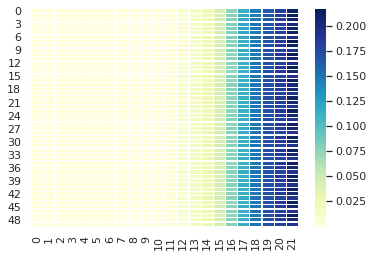

source:  it is necessary that children are given nutritious food so that they are saved from the malnutrition caused corneal blindness 
actual:  <sos> बच्चों को पौष्टिक आहार दिये जाने की आवश्यकता है ताकि कुपोषण से होने वाले कॉर्नियल ब्लाइन्डनेस से बचाया जा सकें ।
predicted:  वर्ष में में पहले में पहले में महिला में में पहले में में अवधि के लिए अवधि की अवधि के लिए अवधि की अवधि में वर्ष में अधिक अधिक अधिक अधिक में में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


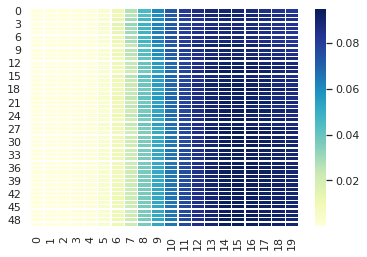

source:  for conjunctival cataract caused by rubella vaccination is required on time 
actual:  <sos> रूबेला के कारण होने वाले कन्जानाईटल कैटरेक्ट के लिये समय पर टीकाकरण किये जाने की आवश्यकता है ।
predicted:  पहले से पहले परीक्षण का परीक्षण में कैंसर में क्षेत्र में यह यह यह यह जाँच से वर्ष में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर
BLEU Score:  0


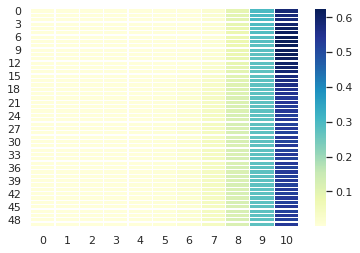

source:  about  to  percent of children become blind with one eye due to injuries in the eyes 
actual:  <sos> आँखों में चोट के लगने के कारण लगभग  से  प्रतिशत बच्चें एक आँख से अन्धे हो जाते हैं ।
predicted:  एक जाँच के कारण जाँच के कारण एक व्यक्ति के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण
BLEU Score:  0


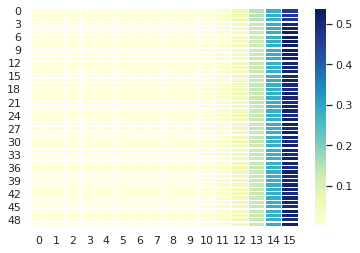

source:  it is required that people are educated about the safety of eyes so that blindness caused by crackers  industrial accidents and road traffic accidents could be escaped 
actual:  <sos> आँखों की सुरक्षा के बारे में लोगों को शिक्षित किये जाने की आवश्यकता है ताकि पटाखें औद्योगिक दुर्घटनायें एवं रोड ट्रेफिक दुर्घटनायों से होने वाली अन्धता को बचाया जा सके ।
predicted:  वर्ष में में पहले में पहले में अन्तराष्ट्रीय में कैंसर में में अवधि में वर्ष में वर्ष में अधिक अधिक अधिक में में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


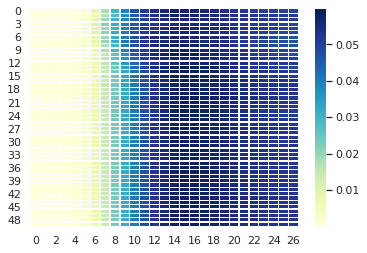

source:  to save eyes from diseases it is necessary to pay attention towards environmental sanitation and treatment is needed on time 
actual:  <sos> रोगों से आँखों के बचाव के लिये environmental senitation की ओर ध्यान दिये जाने की आवश्यकता है तथा उपचार समय पर किये जाने की जरूरत है ।
predicted:  कैंसर एक जाँच के कारण जाँच के कारण परीक्षण के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण
BLEU Score:  0


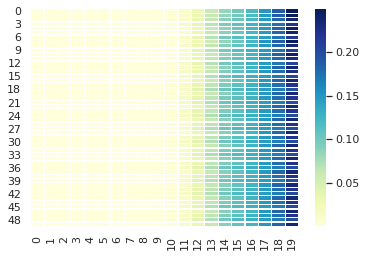

source:  gradual and painless lessening of vision in one or both of the eyes in a month or year 
actual:  <sos> धीरेधीरे तथा बिना दर्द के एक या दोनों आँखों में एक माह या वर्ष में दृष्टि में धीरेधीरे कमी आना ।
predicted:  एक जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के जाँच जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच
BLEU Score:  0


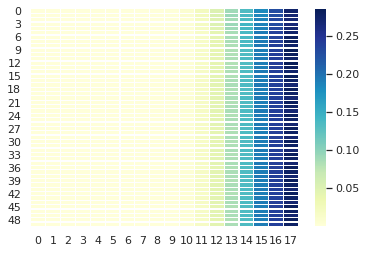

source:  pupil getting gray or white 
actual:  <sos> भूरा  gray  या सफेद पुतली  प्यूपिल  होना ।
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए बुखार । <eos>
BLEU Score:  0.19259074009082888


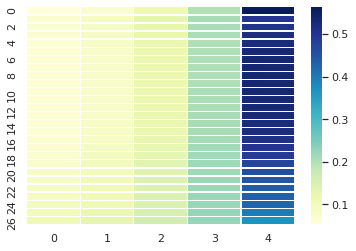

source:  when the rays of light do not fall on the retina or falls at the front or back of the retina 
actual:  <sos> जब प्रकाश की किरणें दृष्टि पटल  रेटिना  पर नही पड़ती हैं या तो रेटिना के आगे या रेटिना के पीछे पड़ती है ।
predicted:  वर्ष पहले से पहले परीक्षण का परीक्षण का कैंसर में क्षेत्र में क्षेत्र में वर्ष में वर्ष से वर्ष से कैंसर से कैंसर से कैंसर से कैंसर में कैंसर की कैंसर से कैंसर में कैंसर की कैंसर से कैंसर में कैंसर की कैंसर से कैंसर में कैंसर की कैंसर से
BLEU Score:  0


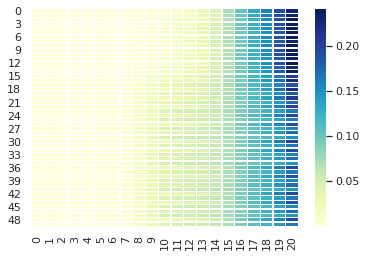

source:  when the rays of light gets collected before the retina 
actual:  <sos> जब प्रकाश की किरणें रेटिना से पहले एकत्रित हो जाती हैं ।
predicted:  जाँच के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के लिए व्यक्ति की व्यक्ति की व्यक्ति से जाँच हो है । <eos>
BLEU Score:  0.19259074009082888


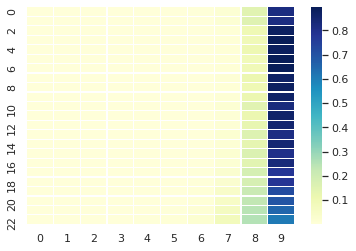

source:  fungus is also a kind of being that lives in our body and harms our body 
actual:  <sos> फंगस भी हमारे शरीर में रहने वाला ऐसा एक जीव है जो हमारे शरीर को नुकसान पहुँचाता है ।
predicted:  कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच
BLEU Score:  0


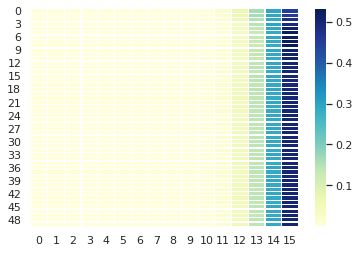

source:  fungus creates its abode in damped places like under the nail of our toe 
actual:  <sos> फंगस नमी वाली जगह जैसे हमारे पैर के अंगूठे के नाखून के नीचे अपना घर बना लेते हैं ।
predicted:  में में पहले में पहले में अन्तराष्ट्रीय में लैन्स में में क्षति है <eos>
BLEU Score:  0


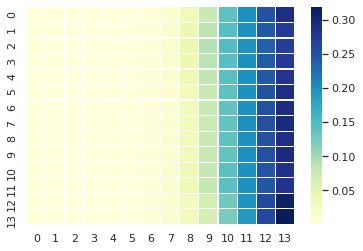

source:  it is called onikomysis 
actual:  <sos> जिसे ओनिकोमाइसिस कहते हैं ।
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए बुखार । <eos>
BLEU Score:  0.19879212680993805


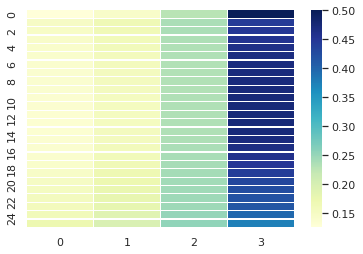

source:  the patient can see nearby things clearly but there occurs problem seeing things at a distance 
actual:  <sos> मरीज नजदीक की चीजें साफ देख सकता है परन्तु दूर की चीजें देखने में परेशानी होती है ।
predicted:  वर्ष में में पहले में पहले में महिला में में कैंसर में में अवधि में वर्ष में अधिक अधिक अधिक अधिक में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


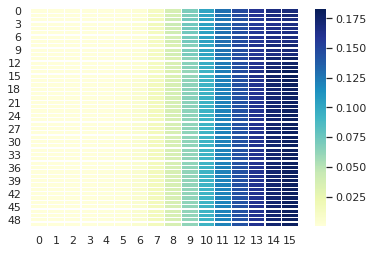

source:  the patient brings things near to the eyes to see things clearly 
actual:  <sos> मरीज चीजों को देखने के लिये आँख के पास लाता है ।
predicted:  में में पहले में पहले में अन्तराष्ट्रीय में सभी लैन्स में में अवधि में वर्ष में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


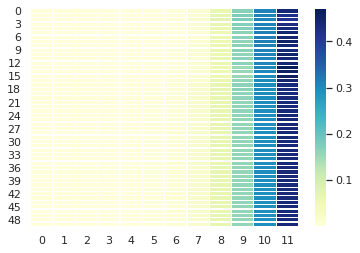

source:  student tries to sit very near to the blackboard in the classroom 
actual:  <sos> क्लास में विद्यार्थी श्यामपट के काफी नजदीक बैठने की कोशिश करता हैं ।
predicted:  में में पहले में पहले में अन्तराष्ट्रीय में सभी सभी क्षति है <eos>
BLEU Score:  0


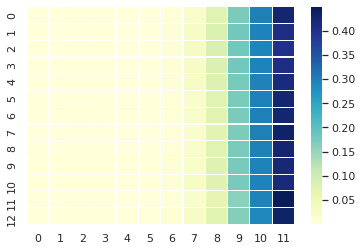

source:  when the rays of light collects at the back of the eye  this is seen mostly in the young children 
actual:  <sos> जब प्रकाश की किरणें रेटिना के पीछे एकत्रित होती है यह ज्यादातर जवान बच्चों में देखा जाता है ।
predicted:  एक एक जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के जाँच जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण
BLEU Score:  0


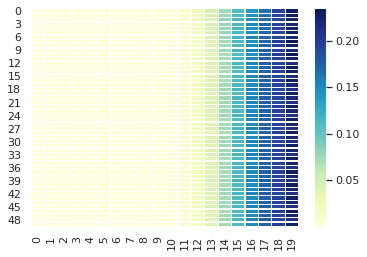

source:  headache  heaviness in the eyes  problem in reading 
actual:  <sos> सिर दर्द  आँखों में भारीपन  पढ़ने में परेशानी ।
predicted:  से पहले पहले परीक्षण का क्षमता परीक्षण की लिए लिए जाँच से लिए लिए जाँच से लिए जाँच से लिए सुरक्षा को सुरक्षा को सुरक्षा को सुरक्षा को सुरक्षा को सुरक्षा को सुरक्षा से बुखार न है <eos>
BLEU Score:  0


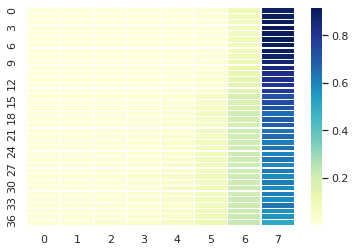

source:  due to weakness in the muscles of the eyes lens can not change its shape  the rays of light falls behind the retina while reading or doing things at a close distance  this is found at an age of  years or above 
actual:  <sos> आँख की मांसपेशियों की कमजोरी के कारण लैन्स अपना आकार नही बदल पाता पढ़ते या नजदीकी काम करते समय प्रकाश की किरणें रेटिना के पीछे पड़ती हैं यह  वर्ष और उससे ऊपर की उम्र में पाई जाती है ।
predicted:  वर्ष में में पहले में पहले में महिला में कैंसर में कैंसर में वर्ष के लिए अवधि की अवधि के लिए अवधि की अवधि में वर्ष में अधिक अधिक अधिक अधिक में में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


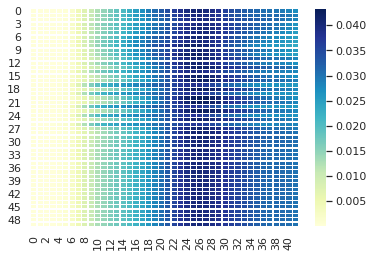

source:  shadowiness in readingwriting at a distance or doing things nearby 
actual:  <sos> दूर पढ़नेलिखने व कोई भी नजदीकी काम करने में धुंधलापन ।
predicted:  में पहले से पहले परीक्षण का कैंसर में कैंसर में संख्या है <eos>
BLEU Score:  0


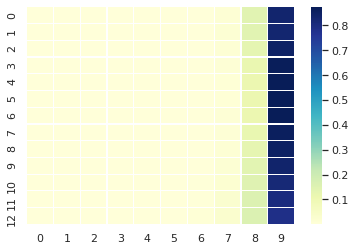

source:  if a ray of light can not concentrate at the front or back of the eye it causes shadowiness 
actual:  <sos> यदि कोई रोशनी की किरण आँख के पर्दे के आगे या पीछे किसी एक बिन्दु पर केन्द्रित नही हो पाती जिससे कि धुंधला दिखता है ।
predicted:  एक एक जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के जाँच जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण
BLEU Score:  0


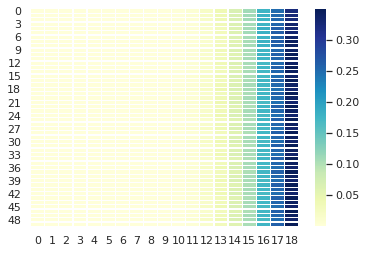

source:  shadowiness in seeing things nearby or at a distance  headache  reddening of eyes 
actual:  <sos> दूर अथवा नजदीक देखने में धुंधलापन सर में दर्द होना आँख का लाल होना ।
predicted:  में में पहले में पहले में अन्तराष्ट्रीय में लैन्स में में क्षति है <eos>
BLEU Score:  0


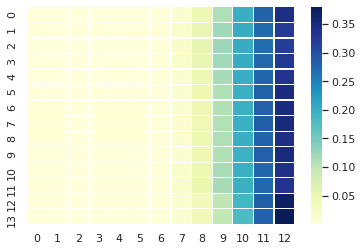

source:  cylindrical glasses have to be worn always 
actual:  <sos> सिलिंडरिकल ग्लासेस को हमेशा पहनना है ।
predicted:  में पहले पहले पहले बाद सभी सभी सभी सभी लिए लिए लिए लिए लिए लिए लिए जाँच है <eos>
BLEU Score:  0


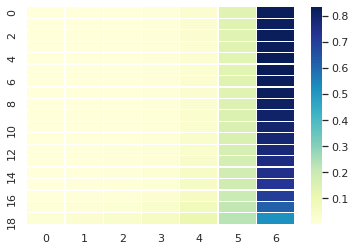

source:  cancer is a lifestyle generated disease 
actual:  <sos> कैंसर एक जीवन शैली से उत्पन्न होने वाली बीमारी है ।
predicted:  समय इन लिए लिए बचाव का नाखून का सेवन हैं <eos>
BLEU Score:  0


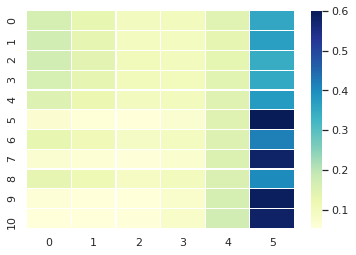

source:  cancer erupts by our wrong practices  thoughts  behavior and diet 
actual:  <sos> कैंसर हमारे गलत अचार  विचार व्यवहार और आहार से उत्पन्न होता है ।
predicted:  में ग्रंथी से पहले पहले परीक्षण में में सभी सभी जाँच में में अवधि में कैंसर में कैंसर में कैंसर में अधिक कैंसर में अधिक कैंसर में अधिक कैंसर में अधिक कैंसर में अधिक कैंसर में अधिक कैंसर में अधिक कैंसर में अधिक कैंसर में अधिक कैंसर में अधिक कैंसर
BLEU Score:  0


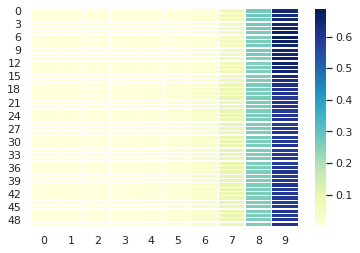

source:  smoking excessive cigarette causes more of windpipe cancer 
actual:  <sos> अधिक सिगरेट पीने से फेफड़ों  स्वॉस की नलियों का कैंसर अधिक होता है ।
predicted:  में पहले जाँच के कारण कारण परीक्षण के लिए लिए जाँच से जाँच से लिए लिए जाँच से लिए लिए जाँच है <eos>
BLEU Score:  0


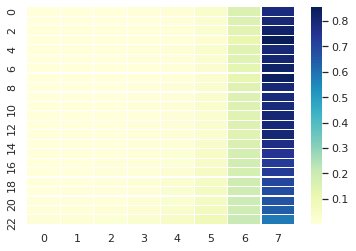

source:  we progress towards development and getting rid of diseases 
actual:  <sos> जैसेजैसे हम विकास की ओर अग्रसर हो रहे है एवं संक्रामक रोगों पर निजात पा रहे हैं ।
predicted:  में ग्रंथी से पहले पहले परीक्षण में पता की सभी संख्या है <eos>
BLEU Score:  0


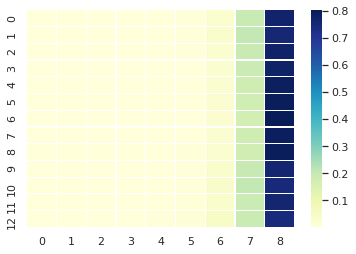

source:  due to changes in our lifestyle the number of cancer and heart patients are increasing 
actual:  <sos> वैसेवैसे अपने जीवन की शैली में बदलाव के कारण कैंसर व हदय रोगियों की संख्या में वृद्धि हो रही है ।
predicted:  वर्ष में से पहले परीक्षण का परीक्षण में कैंसर में क्षेत्र में में वर्ष में वर्ष की कैंसर में यह कैंसर में वर्ष की कैंसर में कैंसर में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में
BLEU Score:  0.17956076853248887


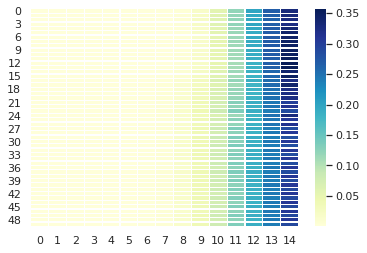

source:  this disease is number one in japan  in developed countries  this disease in at number  and in developing countries this disease is at number  
actual:  <sos> जापान में यह बीमारी नम्बर एक पर है विकसित देशों में यह बीमारी दूसरे नम्बर पर  और विकासशील देशों में यह तीसरे नम्बर पर है ।
predicted:  वर्ष में में पहले में पहले में कैंसर में कैंसर में में वर्ष में वर्ष में वर्ष में वर्ष में कैंसर में कैंसर में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में अधिक अधिक कैंसर में में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


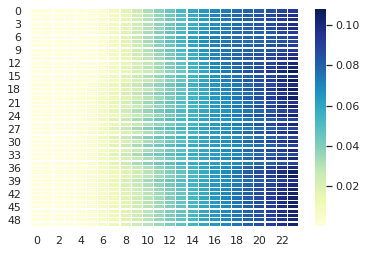

source:  one out of every eight persons can at any time become victim of cancer 
actual:  <sos> भारत में आठ में से एक व्यक्ति अपने उमर में कभी भी कैंसर से पीड़ित हो सकता है ।
predicted:  एक जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच
BLEU Score:  0


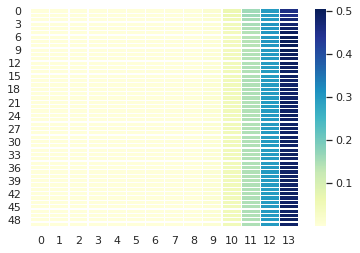

source:  this disease found in different types at different locations in our country due to difference in the lifestyle  customs and religion 
actual:  <sos> हमारे देश में जीवन शैली  रीतीरीवाज  धर्म भिन्न होने के कारण यह बीमारी अलगअलग जगह में विभिन्न प्रकार से पायी जाती है ।
predicted:  वर्ष में में पहले में पहले में कैंसर में कैंसर में में वर्ष में वर्ष में वर्ष में वर्ष में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


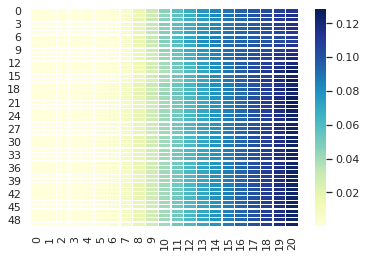

source:  all the data in the country has been calculated  ovarian cancer and breast cancer is found in  percent of the women in cities 
actual:  <sos> देश के सभी आंकडों का आंकलन कर देखा गया है शहरों में  प्रतिशत महिलाओं में बच्चेदानी के मुँह का कैंसर व स्तन कैंसर पाये जाते हैं ।
predicted:  वर्ष पहले से पहले परीक्षण का परीक्षण का कैंसर में कैंसर में में यह में यह यह यह यह यह यह यह वर्ष की वर्ष में वर्ष की कैंसर में कैंसर में वर्ष की कैंसर में कैंसर में वर्ष की कैंसर में कैंसर में वर्ष की कैंसर में कैंसर में
BLEU Score:  0.17261970532895454


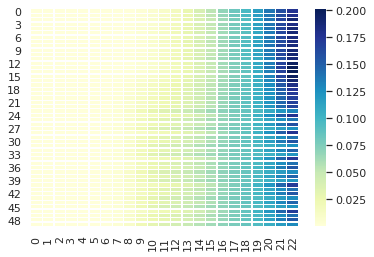

source:  it is between  and  percent among the rural women 
actual:  <sos> ग्रामीण महिलाओं में यह दोनों  से  प्रतिशत के बीच में है ।
predicted:  जाँच के कारण व्यक्ति के लिए व्यक्ति के लिए व्यक्ति जाँच के लिए व्यक्ति की व्यक्ति की लिए जाँच की लिए जाँच हो है <eos>
BLEU Score:  0


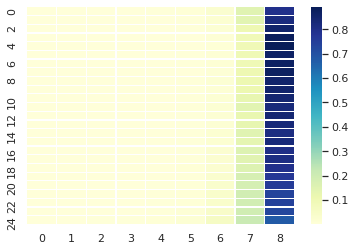

source:  lungs and breathing pipe cancer is found more due to smoking and pollution and the possibility of cancer of the mouth and stomach is more with gutkha  pan parag  tobacco and tobacco powder 
actual:  <sos> पुरूषों में धूम्रपान एवं प्रदूषण से फेफड़े व श्वाँस साँस की नली का कैंसर अधिक पाया जाता है तथा गुटका  पान पराग  खैनी  सुरती से मुँह व पेट का कैंसर होने की अधिक सम्भावना पायी गयी है ।
predicted:  सकल प्रजनन में दिनों पहले पहले में में दर्द में में क्षति में में संख्या है <eos>
BLEU Score:  0


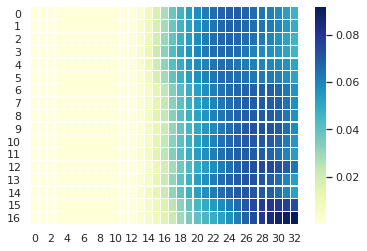

source:  what is cancer 
actual:  <sos> कैंसर क्या है 
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए बुखार । <eos>
BLEU Score:  0


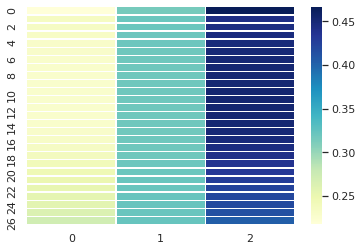

source:  cancer is name of a disease 
actual:  <sos> कैंसर एक बीमारी का नाम है ।
predicted:  समय इन उल्टी में दूर होता <eos>
BLEU Score:  0


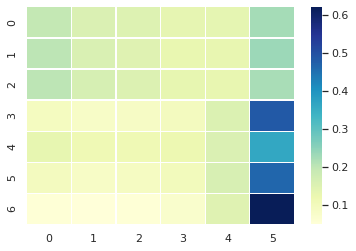

source:  in cancer cells multiply by itself and ignores the rules of the body 
actual:  <sos> कैंसर में शरीर में कोशिका अपने आप ही गुणात्मक तरीके से वृद्वि करती है और शरीर के नियमों को अनदेखा करती है ।
predicted:  कारण जाँच के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच
BLEU Score:  0


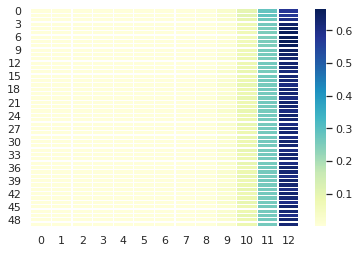

source:  cells also reach other parts of the body 
actual:  <sos> कोशिका शरीर के दूसरे भागों में भी पहुँच जाती है ।
predicted:  ऊतकों है <eos>
BLEU Score:  0


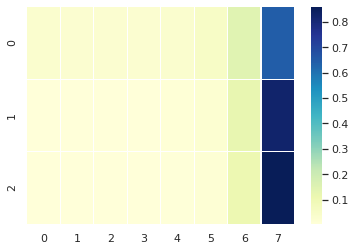

source:  cell takes the form of a cyst or wound  and destroys all the systems coming in contact with it 
actual:  <sos> कोशिका एक गिल्टी या घाव का रूप ले लेती है  और अपने सम्पर्क में आने वाली सभी तन्त्रों को नष्ट कर देती है ।
predicted:  कैंसर एक जाँच के कारण जाँच के कारण परीक्षण के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण
BLEU Score:  0


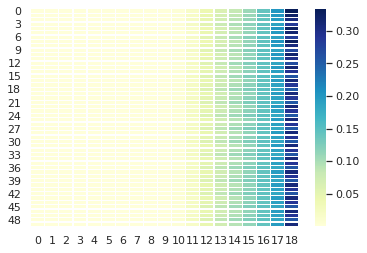

source:  cancer is a group of more than  diseases 
actual:  <sos> कैंसर  से अधिक बीमारीयों का एक समूह है ।
predicted:  ऊतकों है <eos>
BLEU Score:  0


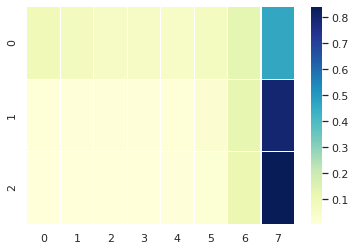

source:  although each of the disease is different from the other but basically all the types of cancers occurs as a result of anomaly in some cells 
actual:  <sos> हालांकि हर बीमारी एक दूसरे से काफी भिन्न होती है  परन्तु मूलतः सभी कैंसर शरीर की कुछ कोशिकाओं में अव्यवस्था के परिणामस्वरुप होते हैं ।
predicted:  कैंसर एक जाँच के कारण जाँच के कारण परीक्षण के कारण जाँच के कारण जाँच के जाँच एक जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के
BLEU Score:  0


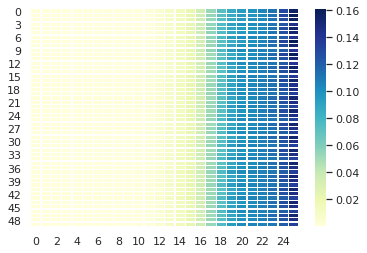

source:  generally  easy tumors can be weeded out through surgery and there is no possibility of its coming up again 
actual:  <sos> सामान्यतः सुसाध्य ट्यूमरों को शल्यचिकित्सा द्वारा निकाला जा सकता है और इनके फिर से होने की संभावना नही होती ।
predicted:  वर्ष में में पहले में पहले में अन्तराष्ट्रीय में में क्षति के लिए अवधि के लिए अवधि के लिए अवधि के लिए अवधि के लिए पहले में में कैंसर में कैंसर में अधिक अधिक अधिक में में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


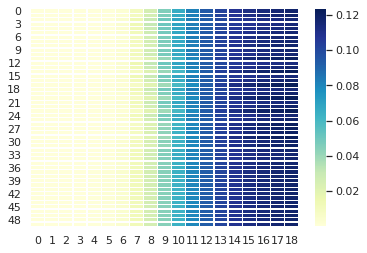

source:  difficult tumors are cancer 
actual:  <sos> असाध्य ट्यूमर कैंसर होते हैं ।
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए बुखार । <eos>
BLEU Score:  0.19953087735062713


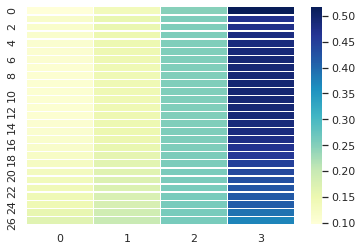

source:  difficult tumors can destroy nearby tissues and parts 
actual:  <sos> असाध्य ट्यूमर निकट के ऊतकों और अंगों को नष्ट कर सकते हैं ।
predicted:  जाँच के लिए कारण जाँच के लिए लिए कारण जाँच से जाँच से लिए लिए जाँच हो । <eos>
BLEU Score:  0.19112328397109352


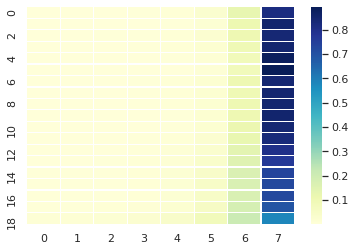

source:  cancer cells can spread into other areas through which new tumors can get born 
actual:  <sos> कैंसर की कोशिकाएँ शरीर के अन्य भागों में फैल सकती हैं या रोगव्यापि कर सकती हैं  जिससे नए ट्यूमर पैदा हो सकते हैं ।
predicted:  एक जाँच के लिए व्यक्ति के लिए व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति जाँच की व्यक्ति की जाँच हो है । <eos>
BLEU Score:  0.17639910709395284


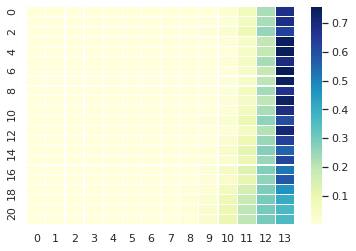

source:  as cancer can spread  it is necessary that the doctor should immediately find whether the tumor is formed and that it is cancer 
actual:  <sos> कैंसर चूँकि फैल सकता है  अतः आवश्यक है कि चिकित्सक तुरन्त यह पता कर लें कि क्या ट्यूमर बन गया है  और यह कैंसर है ।
predicted:  वर्ष में में पहले में पहले में कैंसर में कैंसर में में वर्ष में वर्ष में वर्ष में वर्ष में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


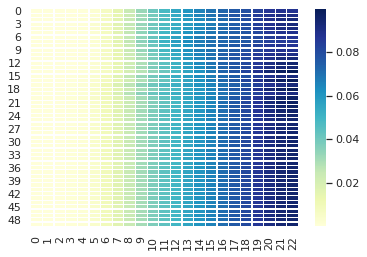

source:  the treatment of cancer can start as soon as it is found 
actual:  <sos> कैंसर का पता चलते ही इसका इलाज आरम्भ किया जा सकता है ।
predicted:  एक जाँच के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के लिए व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति
BLEU Score:  0


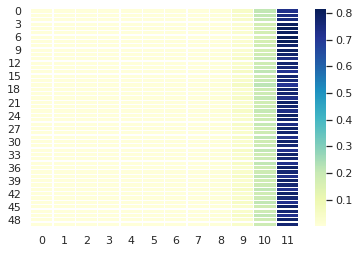

source:  several symptoms shows up due to cancer that gives the impressions of cancer 
actual:  <sos> कैंसर के कारण ऐसे अनेक लक्षण दिखलाई पड़ने लगते हैं जो कैंसर होने का आभास देते हैं ।
predicted:  वर्ष में में पहले परीक्षण में में कैंसर में में क्षति में में वर्ष में वर्ष में कैंसर में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


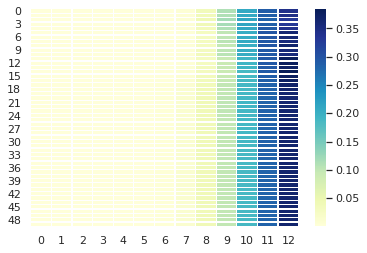

source:  details of some important symptoms are given below 
actual:  <sos> कुछ महत्वपूर्ण लक्षणों का विवरण नीचे दिया जा रहा है ।
predicted:  जाँच के लिए लिए व्यक्ति के लिए लिए व्यक्ति की व्यक्ति की लिए जाँच हो है <eos>
BLEU Score:  0


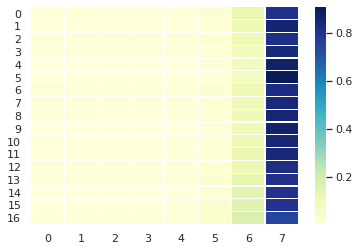

source:  if there is an oxalate stone in the kidney what preventions could be advantageous 
actual:  <sos> गुर्दे में ऑक्जेलेट पत्थरी रही हो तो आगे किनकिन चीजों से परहेज बरतना फायदेमंद हो सकता है 
predicted:  वर्ष में में पहले में पहले में अन्तराष्ट्रीय में में क्षति में में संख्या है है और वर्ष के लिए अवधि की अवधि की अवधि में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


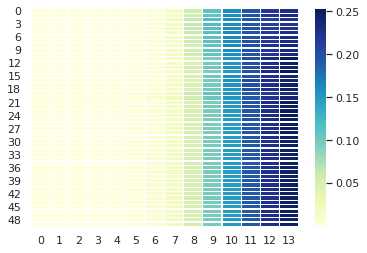

source:  any wound that do not heal in enough time 
actual:  <sos> कोई भी घाव जो काफी समय से भरता नहीं हो ।
predicted:  जाँच के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के लिए व्यक्ति के लिए कारण जाँच के लिए कारण जाँच के लिए जाँच जाँच के लिए जाँच से जाँच से लिए जाँच हो है <eos>
BLEU Score:  0


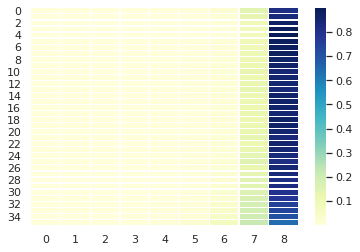

source:  cyst or swelling on breast or any other part of the body 
actual:  <sos> स्तन पर या शरीर में अन्य कहीं गाँठ या सूजन ।
predicted:  कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के लिए व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति
BLEU Score:  0


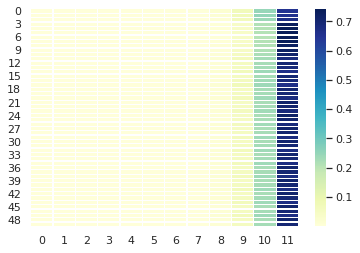

source:  abnormal passing of blood or pus from any part or organ of body 
actual:  <sos> शरीर के किसी भाग या अंग से असामान्य रूप से रक्त या मवाद आना ।
predicted:  खुराक कैंसर के लिए व्यक्ति से रूप में जन्म हो है । <eos>
BLEU Score:  0.18827362913939635


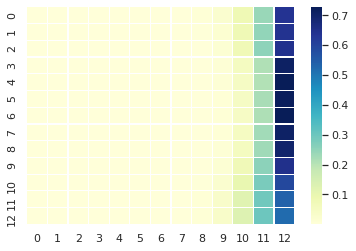

source:  continuous prolonged bouts of cough or occurrence of heaviness in speech 
actual:  <sos> लगातार काफी समय तक खाँसी आना या आवाज भारी होना ।
predicted:  भी आयु के लिए लिए जाँच से कैंसर होता है <eos>
BLEU Score:  0


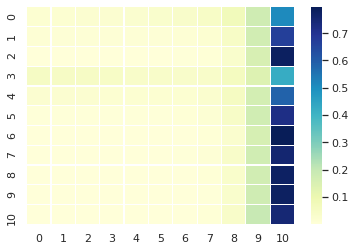

source:  pain in swallowing food or during toilet  continuous indigestion or constipation 
actual:  <sos> खाना निगलने या शौच में कष्ट होना  लगातार अपच या कब्ज रहना ।
predicted:  में में पहले पहले में पहले में सभी सभी सभी क्षति है <eos>
BLEU Score:  0


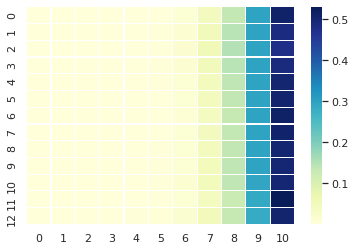

source:  change in general habits of bowels 
actual:  <sos> आँतों की सामान्य आदतों में परिवर्तन ।
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए सुरक्षा है <eos>
BLEU Score:  0


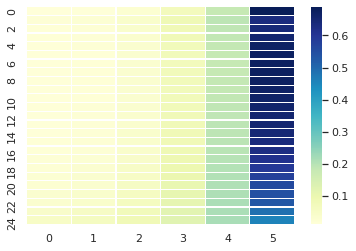

source:  sudden change in the size  color or shape of moles or warts 
actual:  <sos> तिल या मस्से के आकार  रंग या रुप में अचानक परिवर्तन ।
predicted:  प्रजनन में दिनों पहले पहले में परीक्षण में में कैंसर में में संख्या है है <eos>
BLEU Score:  0


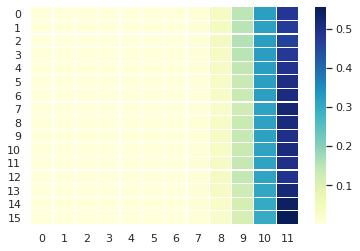

source:  however  such symptoms erupts not just because of cancer  there can be other reasons as well for these 
actual:  <sos> वैसे  ऐसे लक्षण केवल कैंसर के कारण ही पैदा नहीं होते  इनके और कारण भी हो सकते हैं ।
predicted:  पहले पहले से जाँच का परीक्षण का परीक्षण का कैंसर का कैंसर से भी से जाँच से जाँच से कैंसर से कैंसर से कैंसर में कैंसर से कैंसर में कैंसर में कैंसर से कैंसर में कैंसर से कैंसर से कैंसर में कैंसर से कैंसर से कैंसर से कैंसर में से
BLEU Score:  0


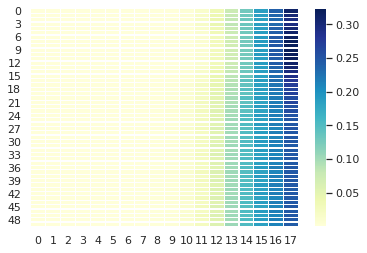

source:  therefore one should not take it as cancer just on its appearance 
actual:  <sos> अतः इन्हें देखते ही कैंसर नहीं मान लेना चाहिये ।
predicted:  में में पहले में पहले परीक्षण में में कैंसर में में संख्या है <eos>
BLEU Score:  0


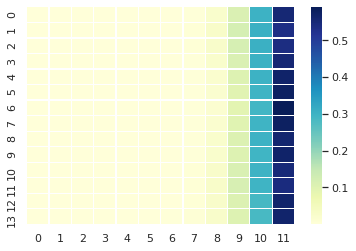

source:  show these to the doctor if these symptoms stay for two weeks 
actual:  <sos> दो सप्ताह तक इन लक्षणों के बने रहने पर इन्हें चिकित्सक को दिखलाएँ ।
predicted:  में में पहले में परीक्षण में में कैंसर में में क्षति है <eos>
BLEU Score:  0


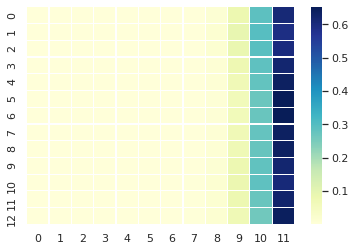

source:  there is no doubt that immediate identification of most of the cancer diseases lrb  percent rrb is possible 
actual:  <sos> इसमें कोई शक नहीं कि भारत में पाए जाने वाले अधिकतर कैंसर     प्रतिशत  रोगों की शीघ्र पहचान संभव है ।
predicted:  कारण जाँच के कारण जाँच के कारण भी परीक्षण के कारण भाग के कारण भाग क्षेत्र के कारण भाग के कारण भाग परीक्षण के कारण भाग के कारण भाग के कारण भाग परीक्षण के कारण भाग परीक्षण के कारण भाग से भाग से जाँच से जाँच से जाँच से कम
BLEU Score:  0


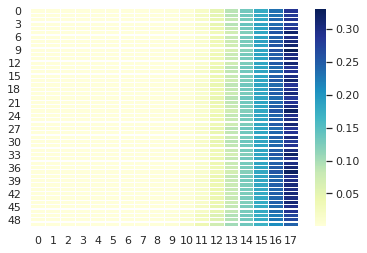

source:  the need is to increase the knowledge about it and for every one to take care of oneself 
actual:  <sos> आवश्यकता है  इसके बारे में जानकारी बढ़ाने तथा हर व्यक्ति को अपना स्वंय ध्यान रखने की ।
predicted:  वर्ष में से पहले परीक्षण का परीक्षण में कैंसर में में यह में में में में जाँच से कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में
BLEU Score:  0


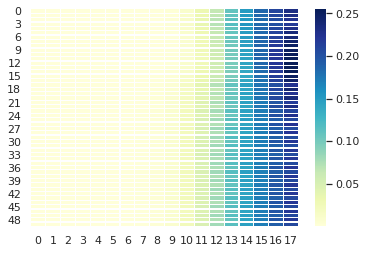

source:  after identifying cancer early  total treatment is now possible for  percent of cancer patients 
actual:  <sos> कैंसर को शीघ्र पहचानकर     प्रतिशत कैंसर रोगियों को जड़ से ठीक करना अब संभव है ।
predicted:  कारण जाँच के कारण जाँच के कारण भी परीक्षण के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण
BLEU Score:  0


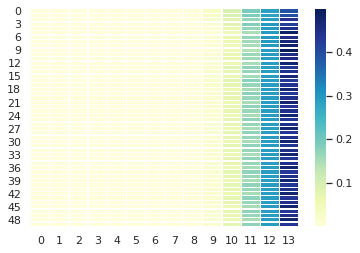

source:  not only this  the cost of early identification and immediate treatment is also much lower than late treatment 
actual:  <sos> यही नहीं शीघ्र पहचान और तुरन्त उपचार की लागत भी देर से उपचार के मुकाबले में बहुत कम है ।
predicted:  कैंसर एक जाँच के कारण परीक्षण के कारण परीक्षण के कारण जाँच के कारण क्षेत्र के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण
BLEU Score:  0


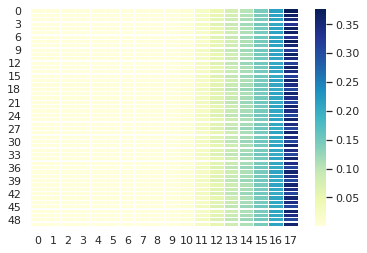

source:  besides being aware of the symptoms of cancer  all the men and the women should get themselves tested regularly 
actual:  <sos> कैंसर के लक्षणों से सचेत होने के अतिरिक्त सभी महिलाओं एवं पुरूषों को नियमित रुप से अपनी जाँच करवानी चाहिए ।
predicted:  एक जाँच कैंसर के कारण एक व्यक्ति के कारण एक व्यक्ति के व्यक्ति जाँच के व्यक्ति जाँच के लिए जाँच के लिए जाँच के कारण जाँच के कारण जाँच के व्यक्ति जाँच के व्यक्ति जाँच के लिए जाँच के लिए जाँच के कारण जाँच के व्यक्ति एक जाँच के व्यक्ति
BLEU Score:  0


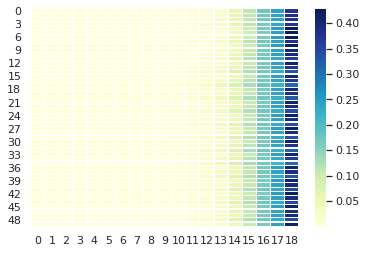

source:  some types of cancers can be identified by general tests before any symptoms appear 
actual:  <sos> सामान्य परीक्षणों द्वारा कुछ प्रकार के कैंसर रोगों का पता किसी चिन्ह के प्रकट होने के पहले ही किया जा सकता है ।
predicted:  एक जाँच के कारण व्यक्ति के कारण एक व्यक्ति के कारण व्यक्ति के व्यक्ति जाँच के व्यक्ति जाँच के लिए जाँच के लिए जाँच के कारण जाँच के कारण जाँच के व्यक्ति जाँच के व्यक्ति जाँच के लिए जाँच के लिए जाँच के कारण जाँच के कारण जाँच के व्यक्ति
BLEU Score:  0


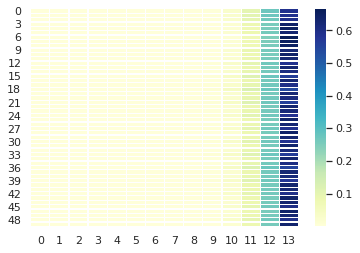

source:  doctors can find out cancer diseases of mouth  breast  cervix  skin  large intestine  rectum  prostate gland  testicle etc  even before any signs appear 
actual:  <sos> किसी चिन्ह के प्रकट होने के पहले ही चिकित्सक मुख  स्तन  गर्भाशयग्रीवा  सर्विक्स   त्वचा  बड़ी आंत  मलाशय  पुरस्थग्रंथी  प्रोटेस्ट   अण्डकोश  टेस्टिकल  आदि कैंसर रोगों का पता लगा सकते हैं ।
predicted:  वर्ष में में पहले में पहले में महिला में कैंसर में वर्ष में वर्ष के लिए अवधि की अवधि की अवधि में वर्ष में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


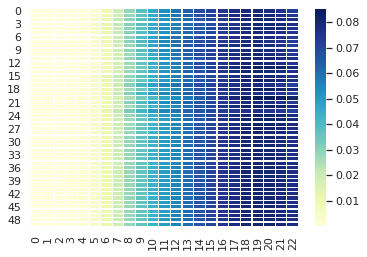

source:  cancer of the cervix is a common cancer of occurring among women 
actual:  <sos> ग्रीवा का कैंसर स्त्रियों में होने वाला एक आम कैंसर हैं ।
predicted:  खुराक कैंसर के लिए व्यक्ति से रूप में जन्म हो है । <eos>
BLEU Score:  0.19259074009082888


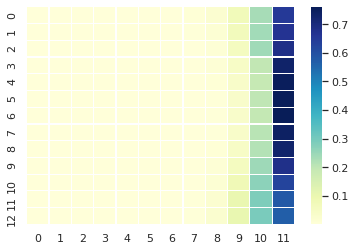

source:  among all the cancers occurring in india  percent is that of cervix 
actual:  <sos> भारत में औरतों में होने वाले कुल कैंसर रोगों में  प्रतिशत कैंसर गर्भाशयग्रीवा के होते हैं ।
predicted:  एक जाँच के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति व्यक्ति के लिए व्यक्ति के लिए व्यक्ति के लिए व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति व्यक्ति के लिए व्यक्ति के लिए व्यक्ति के कारण व्यक्ति के कारण व्यक्ति
BLEU Score:  0


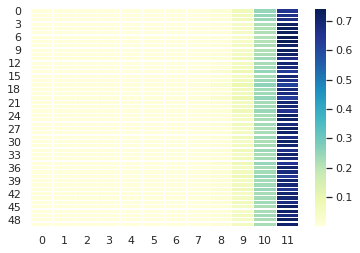

source:  lymph nodes are connected to lymph arteries and form a white liquid that is called lymph 
actual:  <sos> लसीका ग्रन्थियाँ लसीका धमनियों द्वारा एक दूसरे से जुड़ी हुई होती हैं और एक सफेद तरल द्रव बनाती हैं जिसे लसीका कहते हैं ।
predicted:  वर्ष में में पहले में परीक्षण में कैंसर में में क्षति में में वर्ष में वर्ष में वर्ष में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


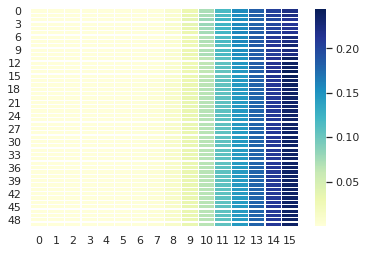

source:  the web of lymph arteries is spread throughout the body like blood arteries 
actual:  <sos> लसीका धमनियों का जाल रक्त धमनियों की तरह पूरे शरीर में फैला होता है ।
predicted:  एक जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच
BLEU Score:  0


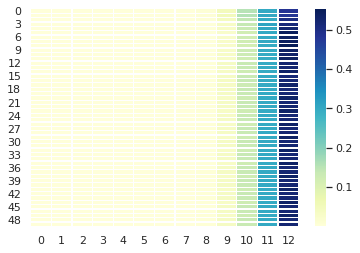

source:  lymph nodes try to keep cancer cells to itself by filtering them 
actual:  <sos> लसीका ग्रंथियाँ कैंसर कोशिकाओं को छानकर अपने तक सीमित रखने का प्रयत्‍न करती हैं ।
predicted:  कारण जाँच के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच
BLEU Score:  0


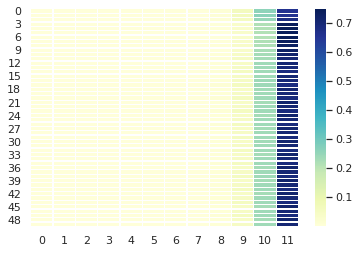

source:  on advancement of the cancer it is not able to do this and cancer spreads from one part of the body to other part by lymph 
actual:  <sos> कैंसर बढ़ जाने पर वह ऐसा नहीं कर पातीं और लसीका द्वारा कैंसर शरीर के एक भाग से दूसरे भाग तक फैलने लगता है ।
predicted:  कैंसर एक जाँच के कारण जाँच के कारण परीक्षण के कारण जाँच के कारण जाँच के जाँच एक जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के
BLEU Score:  0


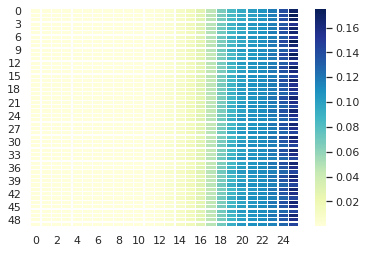

source:  that is why surgeons usually weed out the lymph nodes nearby the cervix also 
actual:  <sos> इसी कारण शल्य चिकित्सक आमतौर पर गर्भाशयग्रीवा के आसपास की लसीका ग्रंथियों को भी निकाल लेते हैं ।
predicted:  वर्ष में में पहले में प्रजनन में कैंसर में में क्षति में में संख्या है है और वर्ष के लिए अवधि की अवधि की अवधि में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


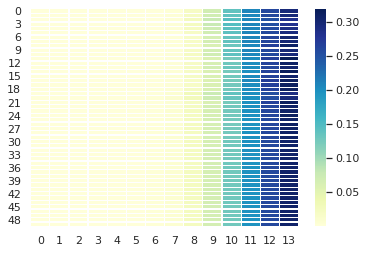

source:  cervical cancer can spread through blood circulation 
actual:  <sos> गर्भाशयग्रीवा का कैंसर रक्त प्रवाह के द्वारा भी फैल सकता है ।
predicted:  आसपास के लिए लिए लिए बचाव का नाखून होता । <eos>
BLEU Score:  0.19259074009082888


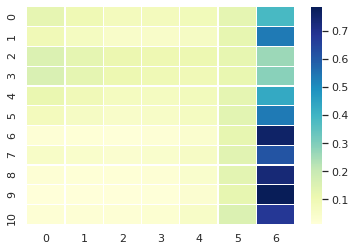

source:  for changes in skin  particularly any kind of growth in moles or warts  you should get tested regularly 
actual:  <sos> त्वचा में खासकर तिल या मस्से किसी प्रकार की नई वृद्वि या परिवर्तन के लिए आप नियमित रुप से जाँच करवाए ।
predicted:  वर्ष प्रजनन से पहले परीक्षण का परीक्षण में कैंसर में क्षेत्र में में वर्ष में वर्ष की वर्ष में यह यह यह कैंसर की कैंसर में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में
BLEU Score:  0


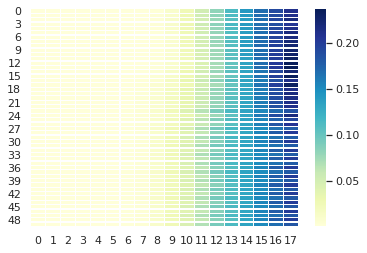

source:  any kind of changes should be shown to the doctor immediately 
actual:  <sos> किसी भी परिवर्तन को तुरंत चिकित्सक को दिखलाएँ ।
predicted:  जाँच के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के लिए व्यक्ति की व्यक्ति की व्यक्ति की जाँच की जाँच हो है । <eos>
BLEU Score:  0.1969244213551724


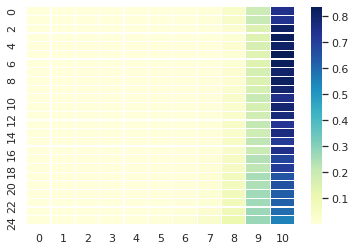

source:  a doctor should also test the skin during general medical checkup 
actual:  <sos> सामान्य डॉक्टरी जाँच के दौरान डॉक्टर को त्वचा की भी जाँच करनी चाहिए ।
predicted:  एक जाँच के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के व्यक्ति व्यक्ति के लिए जाँच के लिए जाँच के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति
BLEU Score:  0


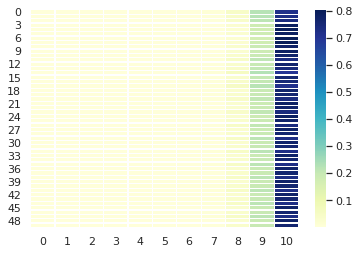

source:  regular medical checkup is important for early detection of cancer of the large intestine and the rectum 
actual:  <sos> बडी आंत और मलाशय के कैंसर का शीघ्र पता लगाने के लिए नियमित डॉक्टरी जाँच करवाना महत्वपूर्ण है ।
predicted:  एक जाँच से जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के
BLEU Score:  0


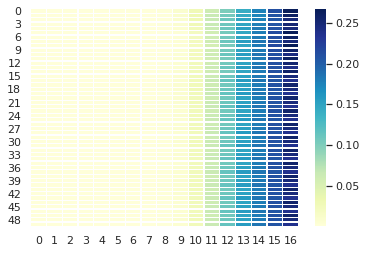

source:  a doctor can find out about the disease by inserting gloved finger in the rectum 
actual:  <sos> मलाशय की जाँच करने के लिए चिकित्सक दस्ताना चढ़ी हुई अंगुली मलाशय में डालकर  रोग का पता लगा सकता है ।
predicted:  एक जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच
BLEU Score:  0


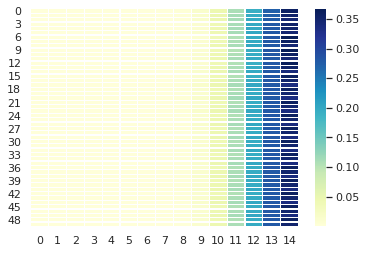

source:  annual test of everybody after the age of  years is necessary 
actual:  <sos>  वर्ष की आयु के बाद  हर व्यक्ति की वार्षिक जाँच आवश्यक है ।
predicted:  खुराक शरीर के लिए व्यक्ति से रूप में जन्म हो है । <eos>
BLEU Score:  0.18827362913939635


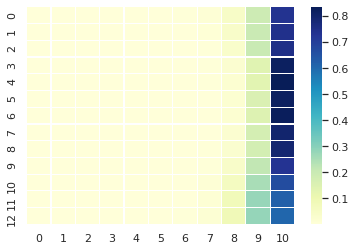

source:  blood can occur with the faeces due to cancer of the large intestine 
actual:  <sos> बड़ी आंत के कैंसर के कारण मल के साथ रक्त आ सकता है ।
predicted:  एक जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच
BLEU Score:  0


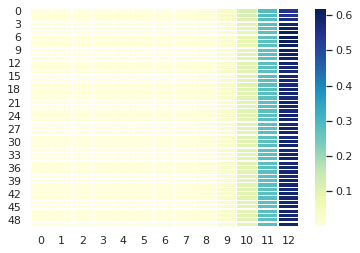

source:  a comprehensive test is mandatory for confirmed diagnosis  the doctor should do a sigmoidoscopy lrb telescopic test of the rectum rrb of the rectum and the large intestine in a period of  to  years for persons crossing the age of  years 
actual:  <sos> निश्‍चित निदान के लिए विस्तृत जाँच आवश्यक है  वर्ष की आयु पार कर लेने वाले व्यक्ति के मलाशय और बड़ी आंत की जाँच करने के लिए डॉक्टर को  से  वर्ष की अवधि में सिग्माइडोस्कोपी  मलाशय की दूरबीन जाँच  करनी चाहिए ।
predicted:  वर्ष में में पहले में पहले में परीक्षण में कैंसर में कैंसर में वर्ष में वर्ष की अवधि में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष
BLEU Score:  0


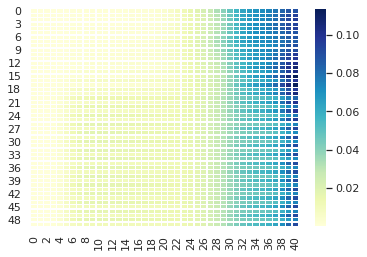

source:  the most credible method of finding out the prostate cancer in its initial stage is the test of gloved finger by the doctor 
actual:  <sos> डॉक्टर द्वारा पुरस्थ ग्रंथी के कैंसर का आंरभिक स्थिति में पता लगाने का अत्यंत विश्‍वसनीय तरीका चढ़ी हुई उंगली का परीक्षण है ।
predicted:  वर्ष में में पहले में पहले में अन्तराष्ट्रीय में में क्षति के लिए अवधि के लिए अवधि के लिए अवधि के लिए पहले में में कैंसर में कैंसर में अधिक अधिक अधिक में में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


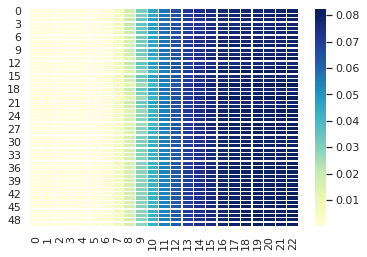

source:  an annual checkup of everybody above the age of  years must be done 
actual:  <sos>  साल से अधिक आयु के सभी व्यक्तियों की वार्षिक जाँच अवश्य की जानी चाहिए ।
predicted:  एक जाँच के कारण व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति जाँच हो है । <eos>
BLEU Score:  0.18690518620528904


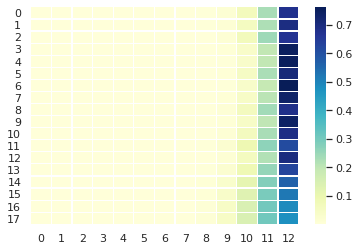

source:  with annual test any irregular or abnormal areas can be found out and it can be known whether there is a tumor or not 
actual:  <sos> वार्षिक जाँच से अवश्य पुरस्थ ग्रंथी में अनियमित या असामान्य सख्त क्षेत्र का पता लग सकता है और जाना जा सकता है कि यहाँ ट्यूमर है या नहीं ।
predicted:  वर्ष में में पहले में पहले में किसी पहले में में में में जाँच में में वर्ष में वर्ष में वर्ष में अधिक अधिक अधिक अधिक में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


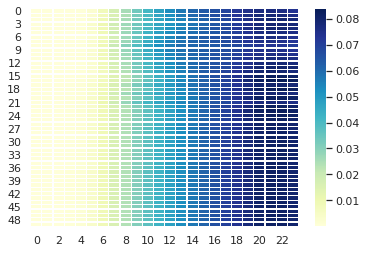

source:  testicular gland cancer could be found out by most of the men themselves 
actual:  <sos> अण्ड ग्रंथीय कैंसर का पता अधिकतर आदमी स्वंय कर सकता है ।
predicted:  प्रजनन में दिनों पहले पहले परीक्षण का कैंसर में कैंसर में में वर्ष में वर्ष की लिए अवधि में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में अधिक कैंसर में कैंसर में अधिक कैंसर में कैंसर में अधिक कैंसर में कैंसर में अधिक कैंसर में कैंसर में अधिक
BLEU Score:  0


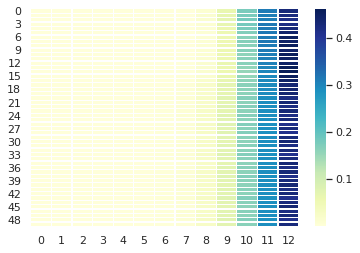

source:  men can find out any changes in the testicular gland by testing themselves every month 
actual:  <sos> प्रत्येक मास स्वंय जाँच करके पुरूष अपनी अण्ड ग्रंथियों में परिवर्तन का पता लगा सकते हैं ।
predicted:  वर्ष में में पहले में पहले में अन्तराष्ट्रीय में कैंसर में में अवधि में वर्ष में अधिक अधिक अधिक अवधि में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


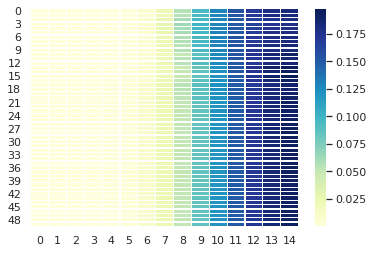

source:  the best time to test it is during the time of bathing with hot water or after  when the testicle is flaccid  as in this situation any changes can be easily figured out 
actual:  <sos> गरम जल से स्नान करते समय या उसके बाद  जब अण्डकोष शिथिल होता है  इसकी जाँच का सबसे अच्छा समय होता है  क्योंकि इस स्थिति में किसी भी परिवर्तन का सुगमता से पता लगाया जा सकता है ।
predicted:  वर्ष में में पहले में पहले में महिला में कैंसर में कैंसर में वर्ष के लिए अवधि की अवधि के लिए अवधि की अवधि में वर्ष में वर्ष में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


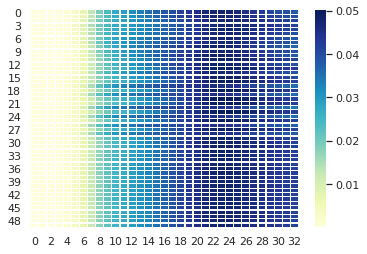

source:  while testing the testicular gland by oneself  if one finds a swelling  cyst or any other kind of defect  particularly an abnormal pain on touching the testicular gland  pain or heaviness  then the doctor should consulted 
actual:  <sos> अण्ड ग्रंथी के स्वंय परीक्षण से यदि सूजन  गाँठ या किसी अन्य प्रकार के दोष का  खासकर अण्ड ग्रंथी को छूने से असामान्य दर्द  या भारीपन का पता चलता है तो डॉक्टर को दिखलाना चाहिए ।
predicted:  वर्ष में में पहले में पहले में अन्तराष्ट्रीय में में क्षति के सभी में में में अवधि के लिए अवधि के लिए अवधि है है <eos>
BLEU Score:  0


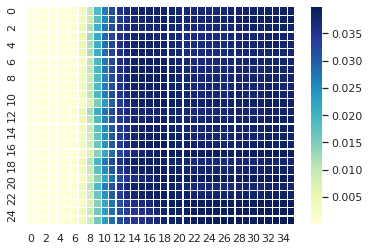

source:  testicular gland test should also be a part of the regular annual medical test of the humans by the doctors 
actual:  <sos> डॉक्टर द्वारा अण्ड ग्रंथियों की जाँच भी मनुष्य की नियमित वार्षिक डॉक्टरी जाँच का अंग होना चाहिए ।
predicted:  एक जाँच जाँच के कारण भी के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण
BLEU Score:  0


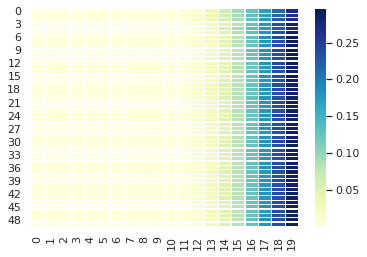

source:  regular test of mouth is required for the signs of mouth cancer 
actual:  <sos> मुख के कैंसर के चिन्हों के लिए मुख की नियमित रूप से जाँच आवश्यक है ।
predicted:  एक जाँच के कारण व्यक्ति के कारण व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति जाँच हो है । <eos>
BLEU Score:  0.18690518620528904


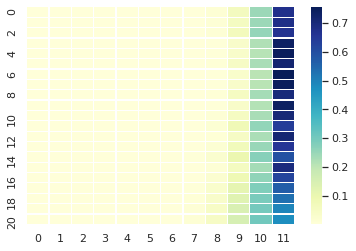

source:  change of tissues of mouth can be the initial stage of cancer 
actual:  <sos> मुख के ऊतकों का परिवर्तन कैंसर की आरम्भिक स्थिति हो सकती है ।
predicted:  खुराक कैंसर के लिए व्यक्ति से रूप में जन्म हो है । <eos>
BLEU Score:  0.19112328397109352


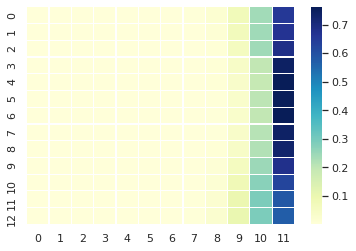

source:  change of tissues of mouth can be easily seen and experienced 
actual:  <sos> मुख के ऊतकों के परिवर्तन को आसानी से देखा और अनुभव किया जा सकता है ।
predicted:  खुराक शरीर के लिए व्यक्ति से रूप में जन्म हो है । <eos>
BLEU Score:  0.18690518620528904


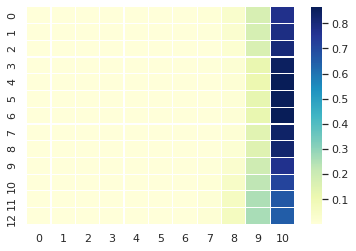

source:  a dentist should test the mouth of every patient in every form 
actual:  <sos> दंत चिकित्सक को चाहिए कि वह हर रूप से हर रोगी की मुख की पूरी जाँच करें ।
predicted:  एक जाँच के कारण व्यक्ति के कारण व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति व्यक्ति हो है । <eos>
BLEU Score:  0.18429333166740366


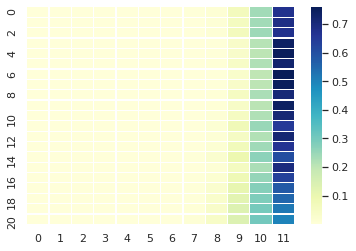

source:  changes occurring in gum  lips and cheek should be paid attention 
actual:  <sos> मसूड़ों  होठों और गालों के रंग में होने वाले परिवर्तन पर ध्यान दिया जाना चाहिए ।
predicted:  प्रजनन से पहले परीक्षण का परीक्षण में कैंसर में क्षेत्र में में संख्या है है और वर्ष वर्ष है । <eos>
BLEU Score:  0.18557819854739144


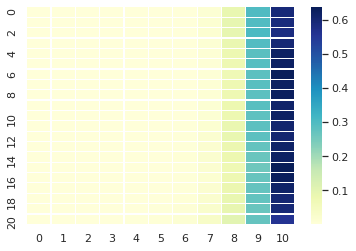

source:  scab cracks  swelling  bleeding or cyst or tumor in any part of the mouth should be paid special attention 
actual:  <sos> खुरण्ड  पपड़ी  दरार  सूजन  रक्त स्राव या मुख के किसी भी भाग में गाँठ अथवा गिलटी के बारे में विशेष ध्यान दिया जाना चाहिए ।
predicted:  वर्ष में में पहले में पहले में अन्तराष्ट्रीय में में क्षति के लिए अवधि के लिए अवधि के लिए अवधि के लिए अवधि के लिए पहले में में कैंसर में कैंसर में अधिक अधिक अधिक में में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


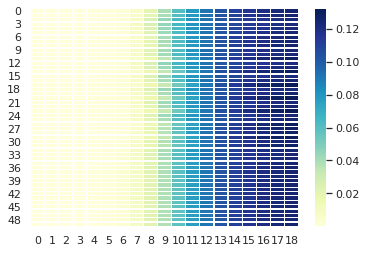

source:  you must get tested by a doctor or a dentist 
actual:  <sos> चिकित्सक या दंतचिकित्सक के पास जाकर जाँच अवश्य करवा लें ।
predicted:  में ग्रंथी में बाद लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए जाँच है <eos>
BLEU Score:  0


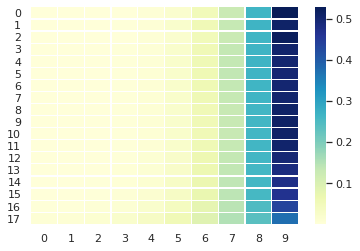

source:  if you are eating tobacco  betel  pan masala or zarda then the test is even more essential 
actual:  <sos> यदि आप तम्बाकू  पान  पानमसाला या जर्दे का सेवन करते हैं तो जाँच करवाना और भी आवश्यक है ।
predicted:  में में प्रजनन में पहले में अन्तराष्ट्रीय में में पहले में में अवधि में वर्ष में अधिक अधिक अधिक में में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


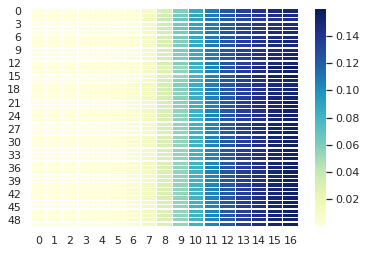

source:  you can also view your mouth in the mirror and in case of any changes  you can take advice of the doctor 
actual:  <sos> आप स्वंय भी शीशे में अपना मुख देख सकते हैं और कोई परिवर्तन दिखाई देने पर डॉक्टर की सलाह ले सकते हैं ।
predicted:  वर्ष में में पहले में पहले में में कैंसर में में क्षति में में संख्या है है और वर्ष के लिए अवधि की अवधि के लिए अवधि के लिए अवधि के लिए अवधि के लिए अवधि के लिए अवधि के लिए अवधि के लिए अवधि के लिए अवधि के लिए
BLEU Score:  0


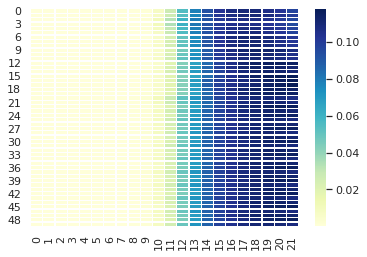

source:  all the women should know how to test their own breasts and each month they should test their breasts themselves 
actual:  <sos> सभी महिलाओं को स्तन के स्वंय परीक्षण का ढंग जान लेना चाहिए और हर महिने अपने स्तनों का स्वंय परीक्षण कर लेना चाहिए ।
predicted:  वर्ष प्रजनन से पहले परीक्षण का परीक्षण में कैंसर में कैंसर में में वर्ष में वर्ष की वर्ष में वर्ष की कैंसर में कैंसर में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष
BLEU Score:  0


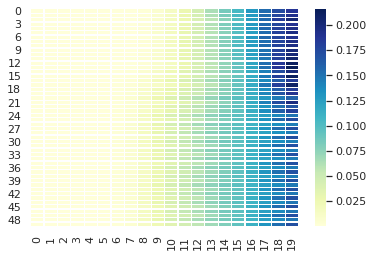

source:  it is good to test the breasts a few days after the menstruation period when there is no possibility of breasts becoming large or any pains at all 
actual:  <sos> रजोधर्म अवधि के कुछ दिनों बाद स्तनों का परीक्षण करना ठीक होता है जब स्तनों के बड़े होने या दर्द होने की संभावना बिल्कुल नहीं होती ।
predicted:  वर्ष में में पहले में पहले में महिला में कैंसर में वर्ष में वर्ष के लिए अवधि की अवधि की अवधि में वर्ष में वर्ष में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


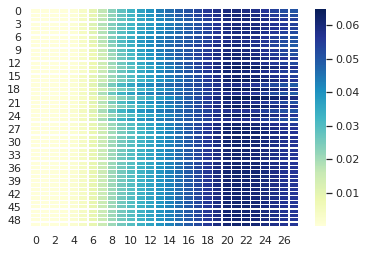

source:  even if the menstruation period has stopped  women should appoint a day lrb whenever rrb each month for test 
actual:  <sos> मासिक धर्म बंद हो जाने पर भी महिलाओं को हर महिने स्वंय परीक्षण के लिए एक दिन  कभी भी  नियुक्त कर लेना चाहिए ।
predicted:  वर्ष प्रजनन से पहले परीक्षण का परीक्षण में कैंसर में क्षेत्र में में यह में यह यह यह यह यह यह यह यह कैंसर में वर्ष की कैंसर में कैंसर में वर्ष की कैंसर में कैंसर में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष
BLEU Score:  0


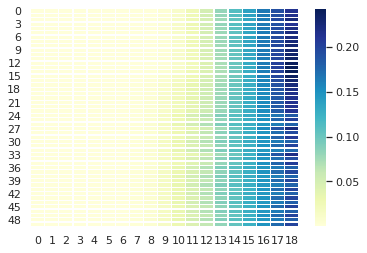

source:  this test is specially important for women above the age of  years 
actual:  <sos>  वर्ष से अधिक आयु की महिलाओं के लिए यह परीक्षण विशेष रूप से महत्वपूर्ण होता है ।
predicted:  एक जाँच के कारण व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति जाँच हो है । <eos>
BLEU Score:  0.18429333166740366


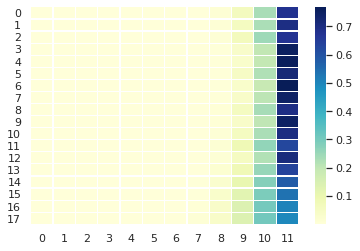

source:  the danger of breast cancer increases in age above  years 
actual:  <sos>  वर्ष से अधिक आयु में स्तन कैंसर का खतरा बढ़ जाता है ।
predicted:  जाँच के लिए व्यक्ति से रूप में जन्म हो है । <eos>
BLEU Score:  0.18968126713037053


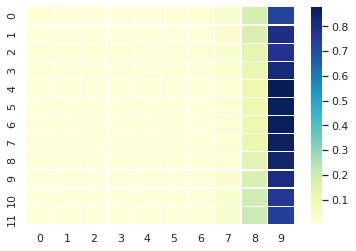

source:  if a woman feels a cyst or any kind of change in the breasts she should consult a doctor 
actual:  <sos> यदि किसी महिला के स्तन में गाँठ या किसी प्रकार के परिवर्तन का आभास होता है तो उसे चिकित्सक से सम्पर्क करना चाहिए ।
predicted:  वर्ष एक जाँच के कारण परीक्षण के कारण परीक्षण के कारण परीक्षण के कारण क्षेत्र के कारण जाँच के कारण क्षेत्र के कारण जाँच के कारण जाँच के कारण क्षेत्र क्षेत्र के कारण क्षेत्र से क्षेत्र क्षेत्र के लिए जाँच से क्षेत्र से कैंसर से कैंसर से कैंसर से कैंसर
BLEU Score:  0


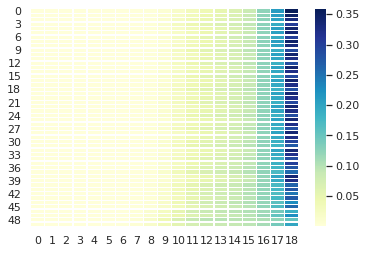

source:  about  percent of the cysts of the breasts are not cancer but only a doctor can correctly find it out 
actual:  <sos> स्तन की लगभग  प्रतिशत गाँठें कैंसर नही होती परन्तु एक चिकित्सक ही इसकी सही पहचान कर सकता है ।
predicted:  एक एक जाँच के कारण एक व्यक्ति के कारण एक व्यक्ति के व्यक्ति जाँच के व्यक्ति जाँच के व्यक्ति जाँच के लिए जाँच के लिए जाँच के कारण जाँच के कारण जाँच के व्यक्ति जाँच के व्यक्ति जाँच के लिए जाँच के लिए जाँच के कारण जाँच के कारण जाँच
BLEU Score:  0


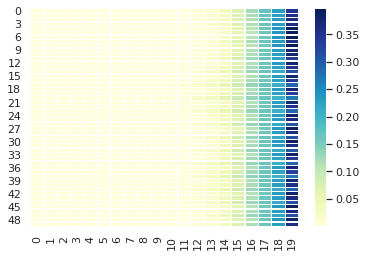

source:  any abnormal situations like cyst in the breasts or breasts becoming very large must be tested during the medical test of women 
actual:  <sos> महिला की डॉक्टरी जाँच करते समय स्तन में गाँठ या स्तनों के बहुत बड़े हो जाने जैसे किसी असामान्य परिवर्तन की जाँच अवश्य की जानी चाहिए ।
predicted:  वर्ष एक जाँच से परीक्षण का परीक्षण के कारण कैंसर के कारण क्षेत्र का क्षेत्र क्षेत्र से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कम से कम की कैंसर से कैंसर से कम से कम की कैंसर से कैंसर
BLEU Score:  0


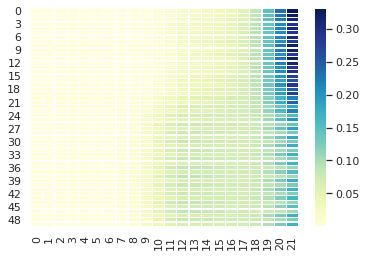

source:  after the age of  years every women must get mammogram done in  to  years 
actual:  <sos>  साल की आयु के बाद हर महिला को  से  वर्ष में मैमोग्राम करवाना चाहिए ।
predicted:  एक जाँच के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति व्यक्ति के लिए जाँच के लिए जाँच के लिए व्यक्ति के कारण व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति व्यक्ति के लिए व्यक्ति के लिए व्यक्ति के लिए व्यक्ति के कारण व्यक्ति
BLEU Score:  0


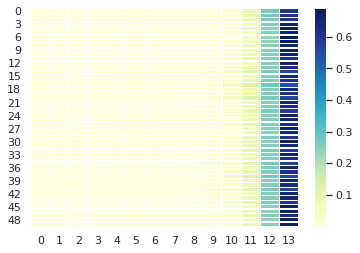

source:  if the age of women goes up to  years then mammogram should be done every year 
actual:  <sos> महिला की उम्र  वर्ष हो जाय तो प्रत्येक वर्ष मैमोग्राम करवाना आवश्यक है ।
predicted:  एक जाँच के कारण जाँच के कारण एक जाँच के कारण जाँच के व्यक्ति जाँच के व्यक्ति जाँच के कारण जाँच के लिए जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण
BLEU Score:  0


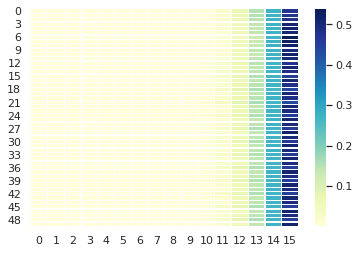

source:  the women whose mothers  sister  blood aunts etc  have cancer should start getting mammography done since  years 
actual:  <sos> जिन महिलाओं की माताओं  बहनों  मौसियों आदि को कैंसर है उन्हें  वर्ष की आयु से ही वार्षिक स्तन जाँच तथा मैमोग्राफी करवानी चाहिये ।
predicted:  वर्ष में में पहले में परीक्षण में कैंसर में कैंसर में में वर्ष में वर्ष में वर्ष में वर्ष में कैंसर में कैंसर में अधिक कैंसर में अधिक कैंसर में अधिक अधिक कैंसर में में अधिक कैंसर में में अधिक कैंसर में में अधिक कैंसर में में अधिक कैंसर में
BLEU Score:  0


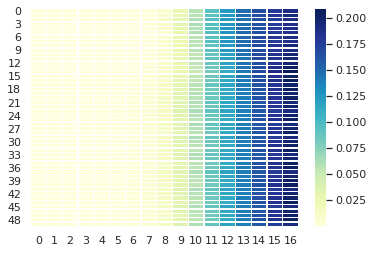

source:  cancer is tested through pathology 
actual:  <sos> कैंसर की जाँच पैथोलोजी परीक्षण के द्वारा की जाती है ।
predicted:  समय इन लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए बुखार । <eos>
BLEU Score:  0.1940679506664638


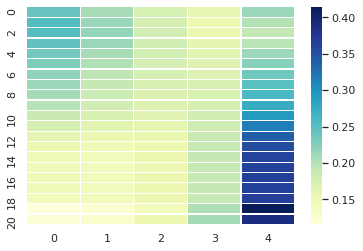

source:  it is seen in microscope 
actual:  <sos> एफएनएसी  बायोप्सी के द्वारा इन कोशिकाओं को सूक्ष्मदर्शी में देखा जाता है ।
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए सुरक्षा लगना । <eos>
BLEU Score:  0.18968126713037053


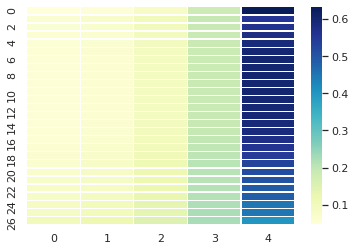

source:  cancer can be found out through other tests like xray    scan     ultrasound also 
actual:  <sos> अन्य जाँच से भी कैंसर का पता लगाया जा सकता है जैसे  सीटी स्केन  एमएमआर  अल्ट्रासाउंड ।
predicted:  एक जाँच के कारण व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति जाँच हो है । <eos>
BLEU Score:  0.18184804078107475


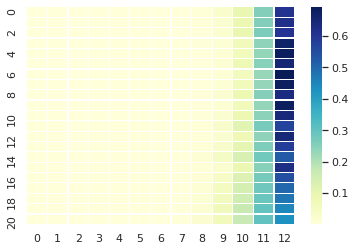

source:  list of training test centres where cancer can be tested 
actual:  <sos> प्रशिक्षण जाँच केन्द्र की सूची जहाँ कैंसर का परीक्षण कराया जा सकता है ।rdpunc
predicted:  जाँच के लिए व्यक्ति के लिए व्यक्ति के लिए व्यक्ति जाँच की व्यक्ति की व्यक्ति हो है । <eos>
BLEU Score:  0


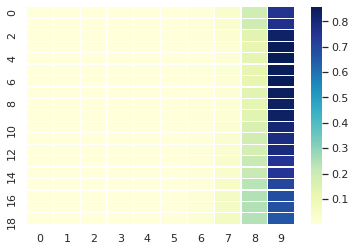

source:  surgery depends on the stage of the cancer 
actual:  <sos> शल्यचिकित्सा कैंसर के चरण पर निर्भर करता है ।
predicted:  जाँच के लिए लिए व्यक्ति के लिए लिए लिए जाँच की लिए जाँच की लिए जाँच हो । <eos>
BLEU Score:  0.1969244213551724


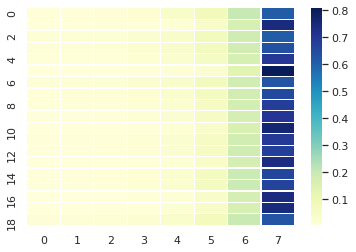

source:  if cancer is in a limited area and in initial stage then along with the affected area some normal areas are also extracted 
actual:  <sos> अगर कैंसर सीमित क्षेत्र में और प्रारम्भिक चरण में है तो प्रभावित क्षेत्र के साथसाथ कुछ सामान्य क्षेत्र में भी हटाये जाते हैं ।
predicted:  वर्ष एक जाँच के कारण जाँच का परीक्षण के कारण जाँच के कारण क्षेत्र से क्षेत्र क्षेत्र से कैंसर से कैंसर से कैंसर से कम से कम से कम से कम से कम की कैंसर से कम से कम की कम से कम की कम से कम की कम से
BLEU Score:  0


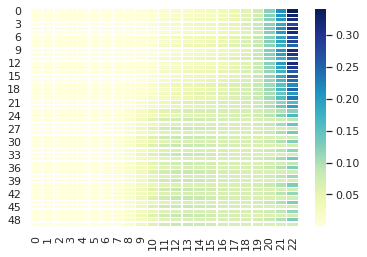

source:  it is attempted that no particle of cancer is left out 
actual:  <sos> कोशिश की जाती है कि कैंसर का कोई भी कण न रह जाए ।
predicted:  जाँच के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के व्यक्ति व्यक्ति के लिए व्यक्ति की व्यक्ति की व्यक्ति की जाँच की जाँच हो है । <eos>
BLEU Score:  0.18968126713037053


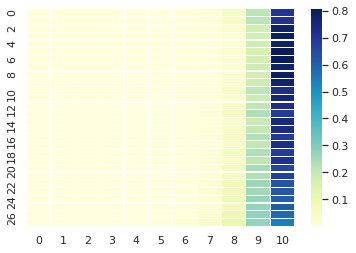

source:  if cancer has also entered other areas then surgery is done to lessen the size of the cancer 
actual:  <sos> अगर कैंसर अन्य क्षेत्र में भी प्रवेश कर चुका है तो कैंसर का आकार कम करने के लिए उससे उत्पन्न होने वाली कठिनाई को कम करने के लिए शल्यचिकित्सा की जाती है ।
predicted:  एक जाँच से जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के
BLEU Score:  0


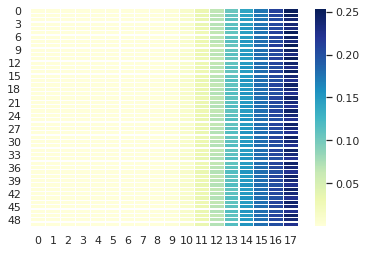

source:  cancer cells are burnt through laser 
actual:  <sos> विकिरण द्वारा कैंसर कोशिकाओं को जलाया जाता है ।
predicted:  समय इन लिए लिए बचाव का कुर्ता का सेवन हैं <eos>
BLEU Score:  0


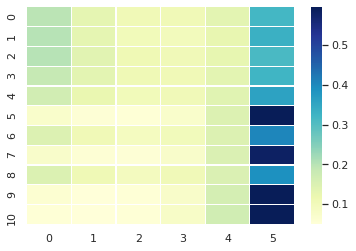

source:  before laser  calculation of area of cancer  spread  capacity of the patient  time of laser based on the cancer  stage  area strength is done 
actual:  <sos> रेडियोधर्मी से पहले कैंसर का क्षेत्र  फैलाव  रोगी की क्षमता  कैंसर के आधार पर विकिरण का समय  चरण  क्षेत्र शक्ति का आंकलन किया जाता है ।
predicted:  कैंसर एक जाँच के कारण जाँच के कारण परीक्षण के कारण जाँच के कारण जाँच के जाँच क्षेत्र के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण
BLEU Score:  0


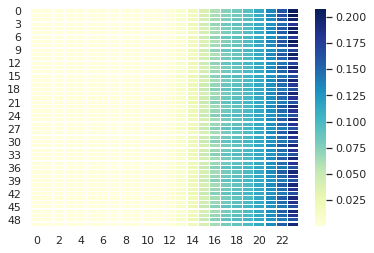

source:  then a mark applied on the skin 
actual:  <sos> फिर त्वचा पर निशान लगाया जाता है ।
predicted:  जाँच के लिए लिए कारण जाँच के लिए लिए लिए जाँच से जाँच से लिए लिए जाँच हो । <eos>
BLEU Score:  0.19817632389021378


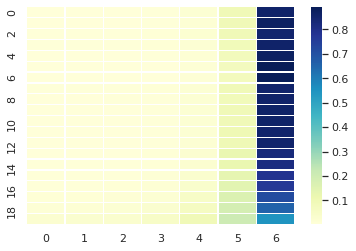

source:  entry for any other person is prohibited in that room during the laser 
actual:  <sos> विकिरण के दौरान किसी दूसरे व्यक्ति का उस कमरे में प्रवेश वर्जित होता है ।
predicted:  एक जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच
BLEU Score:  0


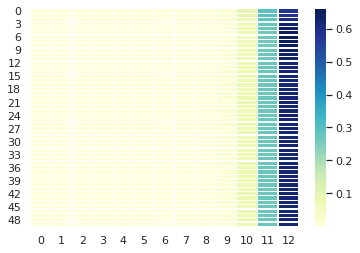

source:  there is no pain in radioactive rays 
actual:  <sos> रेडियोधर्मी विकिरण से किसी प्रकार की कोई तकलीफ नही होती ।
predicted:  में पहले पहले पहले बाद सभी लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए जाँच है <eos>
BLEU Score:  0


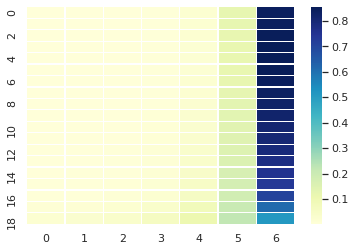

source:  sometimes the skin may become red or patient may feel like vomiting 
actual:  <sos> कभीकभी त्वचा लाल हो सकती है या रोगी को उल्टी आ सकती है ।
predicted:  पहले जाँच का परीक्षण का परीक्षण के कारण जाँच के कारण जाँच से क्षेत्र से जाँच से कैंसर से जाँच से जाँच से कम से कम से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर
BLEU Score:  0


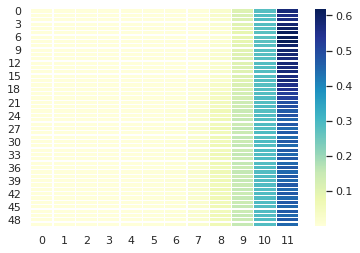

source:  some cancers like blood cancer and the cancer of the cysts can be fully treated with medicine 
actual:  <sos> दवाओं द्वारा कुछ कैंसर को पूरी तरह से ठीक किया जा सकता है जैसे रक्त कैंसर और गाँठों का कैंसर ।
predicted:  कैंसर कैंसर के लिए व्यक्ति के लिए व्यक्ति के लिए व्यक्ति की व्यक्ति की व्यक्ति की जाँच हो है । <eos>
BLEU Score:  0.18068537884315472


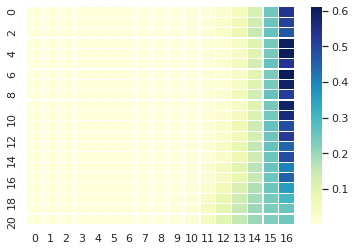

source:  these medicines destroy the cancer cells 
actual:  <sos> ये दवाईयाँ कैंसर कोशिकाओं को समाप्त कर देती हैं ।
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए सुरक्षा । <eos>
BLEU Score:  0.19552795980276136


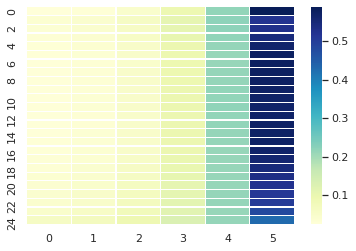

source:  general cells may also be affected with these medicines 
actual:  <sos> सामान्य कोशिकायें भी इन दवाओं से प्रभावित हो सकती हैं ।
predicted:  जाँच के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के लिए जाँच जाँच के लिए जाँच से जाँच से जाँच से लिए जाँच हो है <eos>
BLEU Score:  0


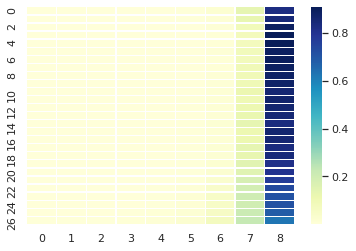

source:  nails may fall 
actual:  <sos> कोशिकाओं के प्रभावित होने की वजह से रोगी के बाल  नाखून  गिर सकते हैं ।
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए बुखार । <eos>
BLEU Score:  0.18557819854739144


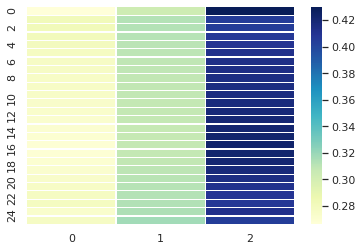

source:  there might occur a decrement in blood which may cause tiredness 
actual:  <sos> खून में कमी आ सकती है जिसकी वजह से थकान लगती है ।
predicted:  जाँच के कारण व्यक्ति के कारण व्यक्ति के लिए व्यक्ति की व्यक्ति की व्यक्ति की जाँच की जाँच हो है । <eos>
BLEU Score:  0.19112328397109352


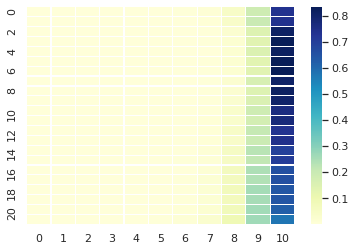

source:  if the patient takes medicine in regular cycle and eats healthy food he can recover fully 
actual:  <sos> अगर रोगी नियमित साइकल से  सही मात्रा में दवाई ले और स्वस्थ भोजन खाये तो बिल्कुल ठीक हो जाता है ।
predicted:  वर्ष में में पहले में परीक्षण में कैंसर में कैंसर में में वर्ष में वर्ष में वर्ष में कैंसर में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


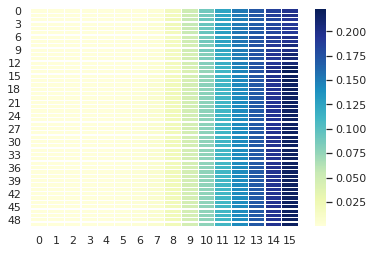

source:  during the treatment blood should be tested regularly  one should have clean water and clean food 
actual:  <sos> इलाज के दौरान निरन्तर खून की जाँच करनी चाहिए  साफ पानी व साफ खाना लेना चाहिए ।
predicted:  वर्ष में से पहले परीक्षण का परीक्षण में कैंसर में क्षेत्र में में वर्ष में वर्ष की कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर
BLEU Score:  0.18305025818318518


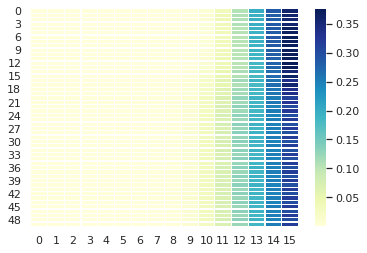

source:  one should not sit with a sick person because the immune strength gets very lessened with medicines 
actual:  <sos> किसी बीमार व्यक्ति के साथ नहीं बैठना चाहिये क्योंकि दवाओं से प्रतिरोधक शक्ति काफी कम हो जाती है ।
predicted:  कारण जाँच के कारण जाँच के कारण भी परीक्षण के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण
BLEU Score:  0


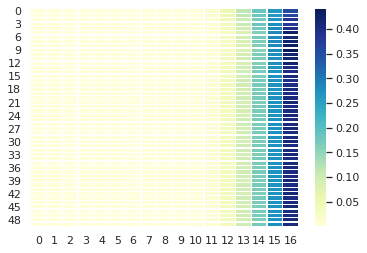

source:  incurable cancer patients are kept in palliative care so that their physical  mental pain could be lessened 
actual:  <sos> कैंसर के लाईलाज रोगियों को पेलियेटिव केयर में रखा जाता है जिससे उनकी शारीरिक  मानसिक  पीड़ा को कम किया जाता है ।
predicted:  वर्ष में में पहले में पहले में अन्तराष्ट्रीय में कैंसर में में अवधि में वर्ष में अधिक अधिक अधिक अवधि में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


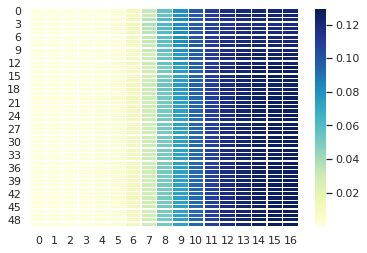

source:  list of hospitals where the treatment of cancer is available 
actual:  <sos> अस्पताल की सूची जहाँ कैंसर के इलाज की सुविधा है ।
predicted:  जाँच के कारण व्यक्ति के लिए व्यक्ति के लिए व्यक्ति जाँच के लिए व्यक्ति की व्यक्ति की जाँच की जाँच हो है । <eos>
BLEU Score:  0.1940679506664638


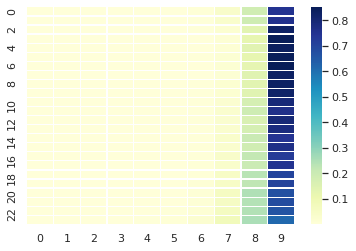

source:  awareness and prevention from cancer 
actual:  <sos> कैंसर से बचाव एवं जागरूकता ।
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए सुरक्षा लगना । <eos>
BLEU Score:  0.1688992412286964


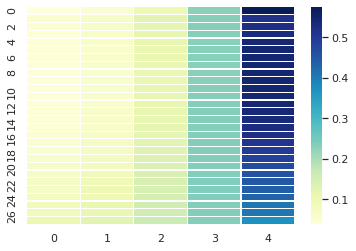

source:  prevention from tobacco and tobacco related products and quitting control 
actual:  <sos> तम्बाकू व तम्बाकूओं से सम्बन्धित वस्तुओं से बचाव व परित्याग प्रदूषण नियत्रंण ।
predicted:  जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के
BLEU Score:  0


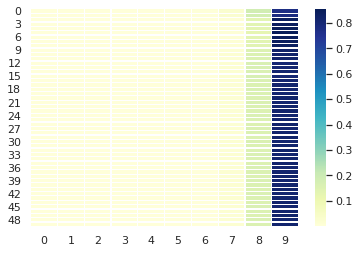

source:  eating fresh fruits and green vegetables  clean normal vegetarian food 
actual:  <sos> स्वच्छ सामान्य शाकाहारी भोजन  प्रत्येक दिन ताजी हरी पत्तीदार सब्जी व ताजे फल का सेवन करना ।
predicted:  धीरे है <eos>
BLEU Score:  0


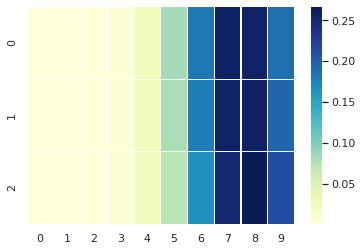

source:  exercise fast for at least half an hour everyday 
actual:  <sos> प्रत्येक दिन कम से कम आधे घन्टे का व्यायाम तेजी से चलना खेलना ।
predicted:  जाँच के कारण व्यक्ति के कारण कारण के लिए कारण जाँच के लिए कारण जाँच के लिए जाँच से जाँच से जाँच से लिए जाँच हो है <eos>
BLEU Score:  0


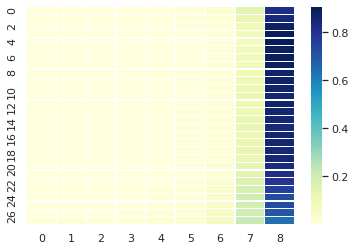

source:  lessening the use of excessive chilly  fried  roasted meat  ghee  wine 
actual:  <sos> अधिक मिर्च  तला  भूना  मांस  घी  मदिरा में कमी करना ।
predicted:  में में पहले ग्रंथी में ग्रंथी में खाली अवधि है <eos>
BLEU Score:  0


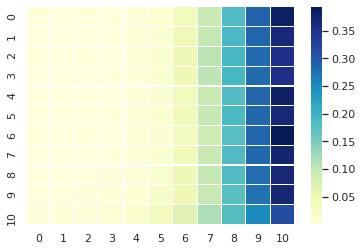

source:  not making any physical relationship before the age of  years 
actual:  <sos>  वर्ष से पहले शारीरिक सम्बन्ध न बनाना ।
predicted:  जाँच के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के लिए व्यक्ति की व्यक्ति की व्यक्ति की लिए जाँच की जाँच हो है । <eos>
BLEU Score:  0.1969244213551724


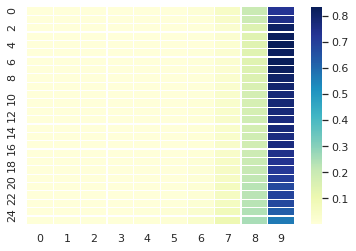

source:  staying faithful to one s partner productive organs clean 
actual:  <sos> अपने साथी के प्रति वफादार रहना जनन अगों को साफ रखना ।
predicted:  में ग्रंथी में पहले पहले ग्रंथी में खाली खाली अवधि है <eos>
BLEU Score:  0


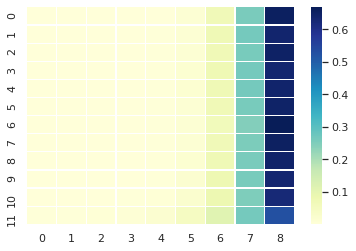

source:  feeding children one s own milk for a long time 
actual:  <sos> बच्चों को लम्बे समय तक अपना दूध पिलाना ।
predicted:  में ग्रंथी में पहले पहले में सभी सभी पहले में अवधि में खाली बोतलों है <eos>
BLEU Score:  0


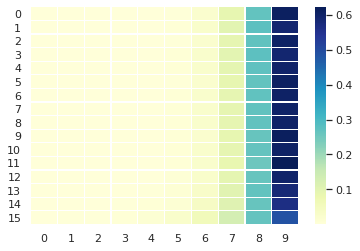

source:  using condoms during the copulation 
actual:  <sos> सम्भोग के दौरान निरोध का इस्तेमाल करना ।
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए सुरक्षा लगना । <eos>
BLEU Score:  0.19817632389021378


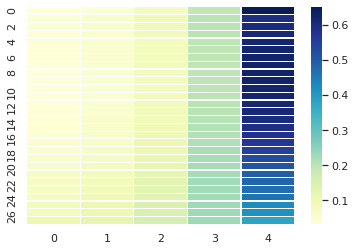

source:  bringing awareness in society 
actual:  <sos> समाज में जागरुकता लाना ।
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए बुखार । <eos>
BLEU Score:  0.19879212680993805


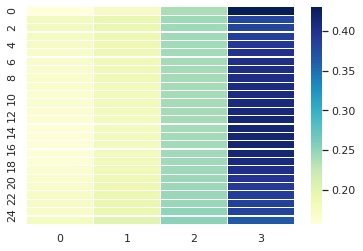

source:  giving information about the harms of smoking and tobacco 
actual:  <sos> धूम्रपान व तम्बाकू से होने वाले नुकसान की जानकारी देना ।
predicted:  जाँच के लिए व्यक्ति से व्यक्ति में जन्म सकता है । <eos>
BLEU Score:  0.2307869877265558


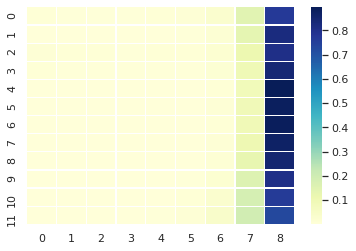

source:  keeping oneself clean and staying away from bad habits 
actual:  <sos> अपने आप को स्वच्छ रखना एवं बुरी आदतों से दूर रहना ।
predicted:  में पहले पहले में पहले बाद सभी सभी सभी सभी जाँच से संख्या है <eos>
BLEU Score:  0


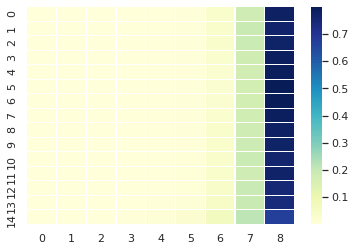

source:  encouraging reforms in rural and urban lifestyle through government and nongovernment department and social organizations 
actual:  <sos> सरकारी व गैरसरकारी विभाग समाजिक संस्थाएँ ग्रामीण व शहरी जीवन शैली को सुधारने के लिए प्रेरित करना ।
predicted:  में में पहले ग्रंथी में पहले में पहले में अवधि के लिए अवधि के लिए अवधि के लिए अवधि के लिए पहले में में अवधि में खाली अधिक अधिक अधिक अवधि में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0.18305025818318518


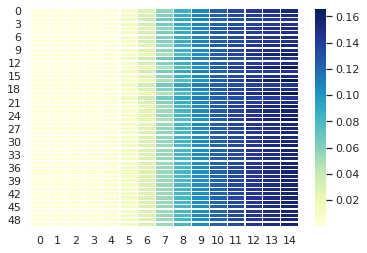

source:  giving information about breasts and mouth tests and getting an annual medical checkup of one s health after  years 
actual:  <sos> स्तन व मुख की जाँच करने की जानकारी देना और  वर्ष के बाद साल में एक बार अपने स्वास्थ्य की पूरी जाँच कराना ।
predicted:  एक एक जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के जाँच जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण
BLEU Score:  0


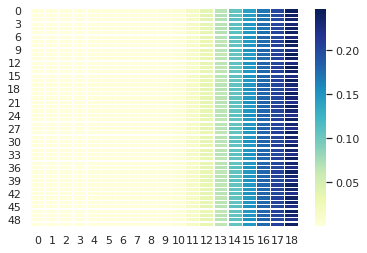

source:  anganwadi workers have been given the information related to cancerous symptoms  selfbreast tests  mouth test and prevention 
actual:  <sos> आंगनवाड़ी कार्यकर्त्ताओं को कैंसर सम्बन्धी लक्षण व स्व स्तन परीक्षण  मुख परीक्षण व बचाव से सम्बन्धित जानकारी दी गयी है ।
predicted:  वर्ष में में पहले में परीक्षण में कैंसर में कैंसर में में वर्ष में वर्ष में वर्ष में वर्ष में कैंसर में कैंसर में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में अधिक कैंसर में अधिक कैंसर में अधिक कैंसर में अधिक कैंसर में
BLEU Score:  0.17847260705223245


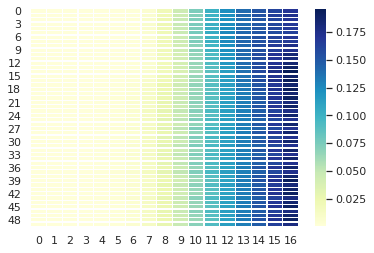

source:  information related to cancer  its symptoms  harms of tobacco  selfbreast test and prevention has been given in junior high schools 
actual:  <sos> जूनियर हाईस्कूल में कैंसर  उसके लक्षण  तम्बाकू से नुकसान  स्व स्तन परीक्षण व बचाव से सम्बन्धित जानकारी दी गयी है ।
predicted:  वर्ष में में पहले में पहले में कैंसर में में कैंसर में में वर्ष में वर्ष में वर्ष में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0.17639910709395284


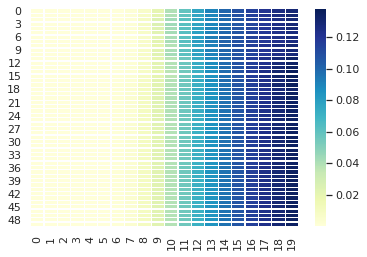

source:  all the hospitals  superintendant base hospital  district hospital  women hospital  medical college and private hospitals in the state have been asked to maintain a cancer register 
actual:  <sos> राज्य के सभी चिकित्सालय अधीक्षक बेस अस्पताल  जिला अस्पताल  महिला अस्पताल  मेडिकल कॉलेज व प्राईवेट अस्पतालों को एक कैंसर रजिस्टर बनाने को कहा गया है ।
predicted:  में में प्रजनन में पहले में पहले में पहले में में अवधि के लिए अवधि के लिए अवधि की अवधि में वर्ष में वर्ष में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0.1717430532243771


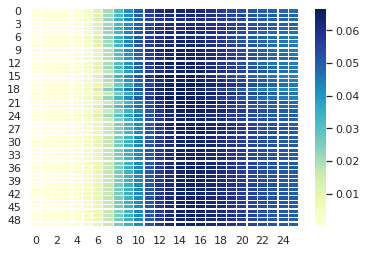

source:  they will register cancer patients coming to their outdoor department and post this report to the directorate every month 
actual:  <sos> कैंसर रजिस्टर में वे अपने बाहरी विभाग मे आये हुये कैंसर रोगियों को रजिस्टर करेगें और प्रत्येक माह यह रिर्पोट महानिदेशालय को प्रेषित करेंगें ।
predicted:  में में प्रजनन में पहले में पहले में पहले में में अवधि में वर्ष में वर्ष में अधिक अधिक अधिक में में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


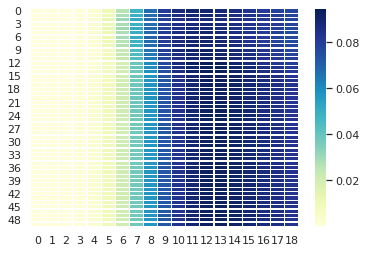

source:  we will find out what is the number of cancer patients in the state and in which area which cancer has been found more 
actual:  <sos> कैंसर रजिस्ट्रर में हमें पता लग जायेगा कि राज्य में कैंसर से पीड़ित व्यक्तियों की संख्या क्या है और किस क्षेत्र मे कौन सा कैंसर अधिक पाया गया है ।
predicted:  वर्ष में में पहले में पहले में महिला में कैंसर में वर्ष में वर्ष के लिए अवधि की अवधि के लिए अवधि की अवधि में वर्ष में वर्ष में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


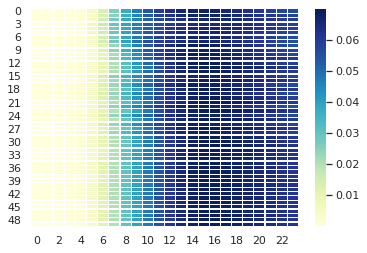

source:  chicken pox lrb varicella rrb 
actual:  <sos> छोटीमाता या चिकनपौक्स  वेरिसिल  ।
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए सुरक्षा लगना । <eos>
BLEU Score:  0.19913749124569236


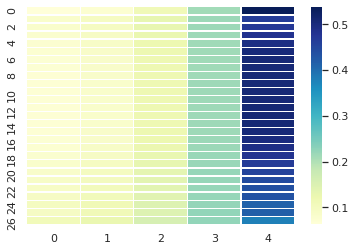

source:  chicken pox is a viral that erupts out of a contact with varicella zoster lrb vzv rrb 
actual:  <sos> छोटीमाता एक वायरल है जो वेरिसिला जोस्टर  वीजेडवी  से प्रथम सम्पर्क के कारण उभरती है ।
predicted:  एक जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच
BLEU Score:  0


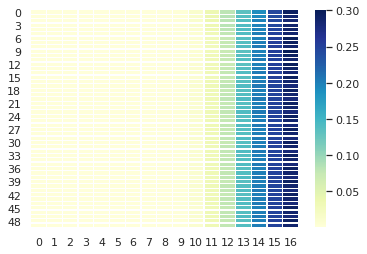

source:  fever and eruption of a special kind of papules is the sign of chicken pox 
actual:  <sos> बुखार और सारे शरीर पर विशिष्ट प्रकार की फुंसियाँ निकलना छोटीमाता रोग की पहचान है ।
predicted:  कारण जाँच के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच
BLEU Score:  0


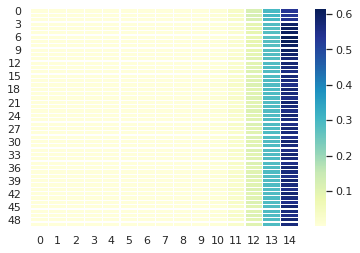

source:  a virus spreads from one person to another person through air born drops 
actual:  <sos> हवा में निहित बूंदों द्वारा आमतौर पर वायरस एक व्यक्ति से दूसरे व्यक्ति तक फैलता है ।
predicted:  पहले जाँच का एक एक जाँच परीक्षण के कारण जाँच के कारण क्षेत्र से क्षेत्र से जाँच से कैंसर से जाँच से कम से कम से कम से कम से कम की कैंसर से कम से कम की कैंसर से कम से कम की कैंसर से कम से कम की
BLEU Score:  0


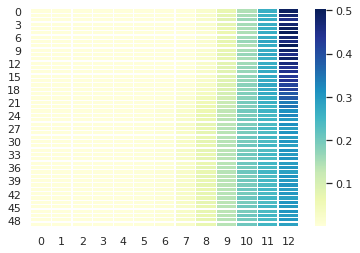

source:  it erupts through the spread of the spray of saliva in the nearby environment on sneezing or coughing of a person infected with chicken pox 
actual:  <sos> छोटीमाता से संक्रमित व्यक्ति के खाँसने या छींकने के कारण आसपास के वातावरण में लार के छींटे फैल जाने से यह उभरता है ।
predicted:  वर्ष पहले से पहले परीक्षण का परीक्षण का कैंसर में कैंसर में क्षेत्र में यह यह यह यह यह यह यह यह यह कैंसर की कैंसर में कैंसर की कैंसर में कैंसर की कैंसर में कैंसर की कैंसर में कैंसर की कैंसर से कैंसर में कैंसर की कैंसर से कैंसर
BLEU Score:  0


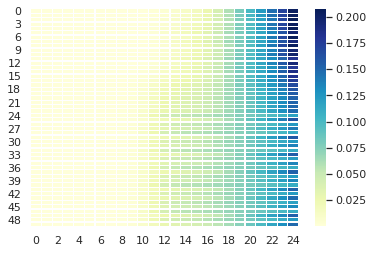

source:  it can also spread through a direct contact with chicken pox or herpes because there is contagious liquid in raw wounds 
actual:  <sos> छोटीमाता या हर्पिस से सीधे सम्पर्क द्वारा भी यह फैल सकता है क्योंकि गीले घावों में संक्रामक द्रव होते हैं ।
predicted:  वर्ष पहले से पहले परीक्षण का परीक्षण का कैंसर में क्षेत्र में क्षेत्र में वर्ष में वर्ष से वर्ष से कैंसर से कैंसर में वर्ष की कैंसर से कैंसर में कैंसर की कैंसर से कैंसर में कैंसर की कैंसर से कैंसर में कैंसर की कैंसर से कैंसर में कैंसर की
BLEU Score:  0


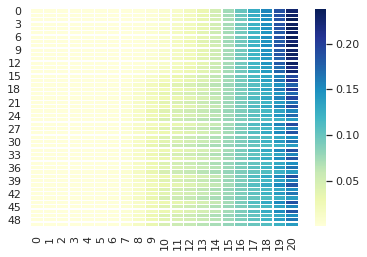

source:  in some cases it can also spread from an infected pregnant mother to the unborn or to a new born baby 
actual:  <sos> कुछ मामलों में यह संक्रमित गर्भवती माँ से उसके अजन्में या नवजात शिशु को भी लग सकता है ।
predicted:  वर्ष में में पहले में पहले में महिला में में कैंसर में में अवधि के लिए अवधि की अवधि के लिए अवधि की अवधि में वर्ष में अधिक अधिक अधिक अधिक में में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


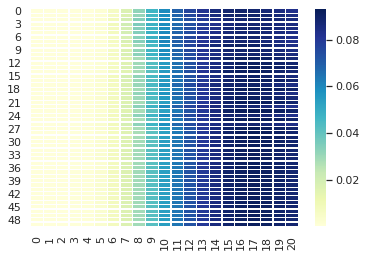

source:  chicken pox is the most contagious a few days before the papules erupt and before the scab spreads over the wounds i   till it dries up which often happens a week after the spots have started 
actual:  <sos> फुन्सियाँ उभरने से कुछ दिनों पहले तक और सारे घावों पर पपड़ी जमने से पहले तक यानी उनके सूख जाने तक छोटीमाता सर्वाधिक स्पर्शजन्य होता है जो अकसर चकत्तों के आरंभ होने के एक सप्ताह बाद होता है ।
predicted:  वर्ष में में पहले में पहले में अन्तराष्ट्रीय में कैंसर में में अवधि में वर्ष में अधिक अधिक अधिक में में में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


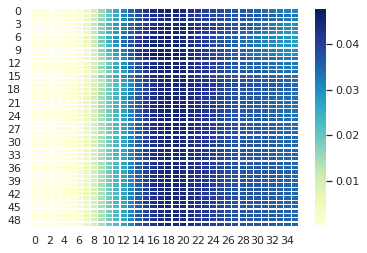

source:  fever  shivering  nausea and vomiting are the most clear and famous symptoms  eruption of blisters and extreme itching freckles 
actual:  <sos> बुखार  कंपकंपी  उबकाई और उल्टी सबसे साफ और सुविख्यात लक्षण हैं  फुन्सी और अत्यंत खुजलाहट भरी चकत्तियों का उभरना ।
predicted:  में में पहले ग्रंथी में पहले में पहले में अवधि के लिए अवधि है <eos>
BLEU Score:  0


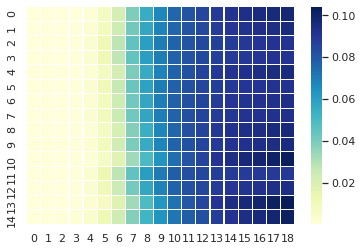

source:  in most of the children  blisters erupt that later become scabs 
actual:  <sos> अधिकांश बच्चों को  फुंसियाँ निकलती है जो बाद में पपड़ी या परत बन जाती हैं ।
predicted:  में ग्रंथी से पहले परीक्षण में कैंसर में कैंसर में में संख्या है <eos>
BLEU Score:  0


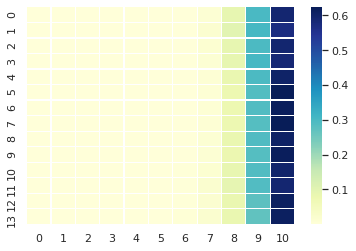

source:  chicken pox can attack both young and adult  men and women 
actual:  <sos> छोटीमाता बच्चों और बड़ों  पुरूषों और महिलाओं दोनों को हो सकती है ।
predicted:  एक जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच
BLEU Score:  0


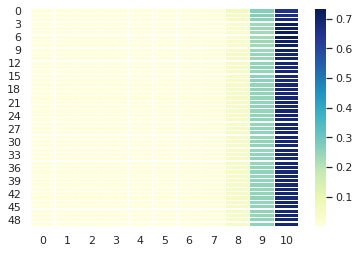

source:  most of the people become victim of chicken pox one time or the other in their childhood or adolescence 
actual:  <sos> अधिकांश लोग बचपन या किशोरावस्था के दौरान कभी न कभी छोटीमाता का शिकार होते हैं ।
predicted:  वर्ष में में पहले में पहले में कैंसर में में कैंसर में में वर्ष में वर्ष में वर्ष में अधिक अधिक अधिक अधिक में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


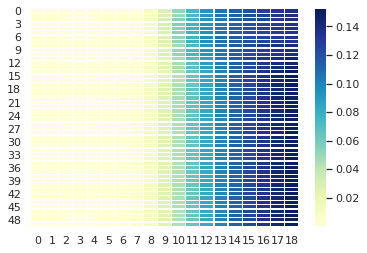

source:  but if adults who had never been a victim of chicken pox come into contact with such a case  they are in danger of contraction and they may suffer from chicken pox in adulthood 
actual:  <sos> लेकिन पहले कभी छोटीमाता का शिकार नहीं हुए वयस्क यदि कभी ऐसे मामले के सम्पर्क में आते हैं तो उन्हें संक्रमण का खतरा होता है और वयस्क अवस्था में उन्हें छोटीमाता हो सकती है ।
predicted:  वर्ष में में पहले में पहले में कैंसर में कैंसर में कैंसर में वर्ष में वर्ष में वर्ष में अधिक अधिक अधिक अधिक में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


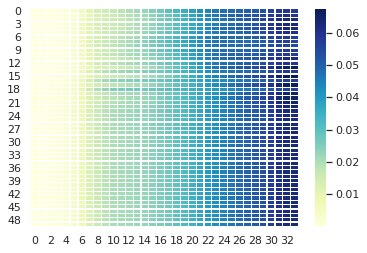

source:  chicken pox is more serious in adolescents and adults in comparison with children 
actual:  <sos> बच्चों की तुलना मे छोटीमाता किशोरों और वयस्कों में अधिक गंभीर होती है ।
predicted:  एक जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच
BLEU Score:  0


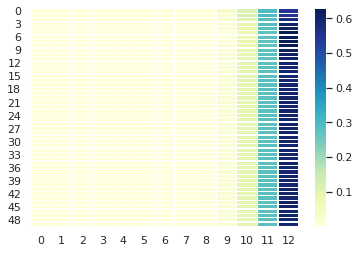

source:  fever stays for a longer time 
actual:  <sos> बुखार ज्यादा लंबे समय तक रहता है ।
predicted:  में लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए सुरक्षा लगना । <eos>
BLEU Score:  0.19817632389021378


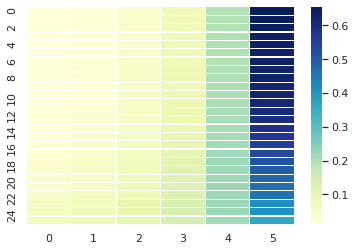

source:  keeping infected persons away from school or work helps in decreasing the spread of the virus but vaccination is an effective solution to escape the pain of chicken pox 
actual:  <sos> संक्रमित व्यक्तियों को स्कूल या काम से दूर रखने से वायरस का प्रसार कम करने में मदद मिलती है लेकिन टीकाकरण छोटीमाता की पीड़ा से बचने का एक प्रभावी उपाय है ।
predicted:  वर्ष में में पहले में पहले में महिला में में कैंसर में में अवधि के लिए अवधि की अवधि के लिए अवधि की अवधि में अधिक अधिक अधिक अधिक में में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


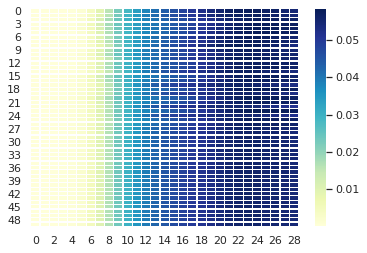

source:  fever is estimated with symptoms like high fever  acute body pain  headache  joint pain  eye pain and finding of papules on body 
actual:  <sos> तेज बुखार  तेज बदन दर्द  सिर दर्द  जोड़ों मे दर्द  आँख में दर्द तथा शरीर पर दाने का पाया जाना आदि लक्षणों से बुखार का अनुमान लगाया जाता है ।
predicted:  में में प्रजनन में पहले में पहले में पहले में में अवधि के लिए अवधि के लिए अवधि के लिए अवधि के लिए अवधि के लिए अवधि के लिए अवधि के लिए अवधि के लिए अवधि के लिए अवधि के लिए अवधि के लिए अवधि के लिए अवधि के लिए
BLEU Score:  0


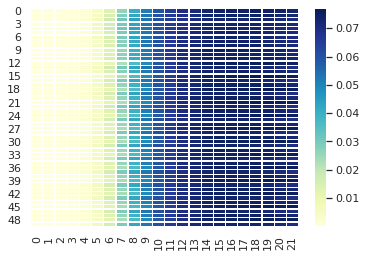

source:  besides the above general symptoms  complaints of bleeding from teeth  mouth or nose also occur in serious patients of chicken pox 
actual:  <sos> छोटीमाता से ग्रसित गंभीर रोगियों में उपरोक्त सामान्य लक्षणों के अलावा दाँत से  मुँह से या नाक से खून आने की शिकायत हो जाती है ।
predicted:  वर्ष में में पहले में परीक्षण का कैंसर में कैंसर में में वर्ष में वर्ष में वर्ष में वर्ष में कैंसर में कैंसर में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में अधिक अधिक कैंसर में में अधिक कैंसर में
BLEU Score:  0


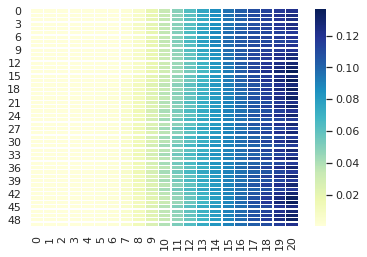

source:  tourniquet test comes positive in chicken pox patients and platelet count is found less than  lac on blood test 
actual:  <sos> छोटीमाता के रोगियों मे टारनीक्वेट टेस्ट धनात्मक आता है तथा खून की जाँच कराने पर प्लेटलेट काउन्ट  लाख से कम पाया जाता है ।
predicted:  वर्ष में में पहले में पहले में महिला में में कैंसर में में अवधि में वर्ष में वर्ष में अधिक अधिक अधिक अधिक में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


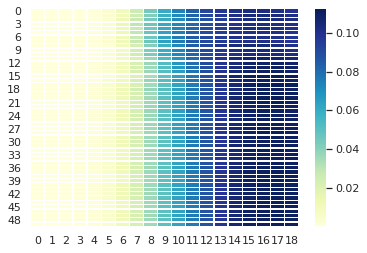

source:  dengue fever occurs after a sting of aedes aegypti 
actual:  <sos> डेंगू बुखार एडिस एजिप्टाई मच्छर के काटने के पश्‍चात होता है ।
predicted:  धीरे धीरे लेकिन खाली मुँह चिकित्सालय थी <eos>
BLEU Score:  0


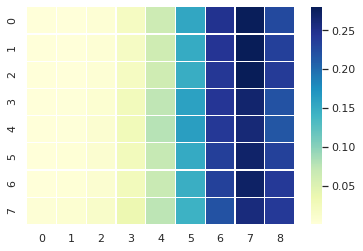

source:  aedes aegypti is also known by the name of tiger mosquito and it stings during the day time 
actual:  <sos> एडिस एजिप्टाई मच्छर को टाइगर मौसक्विटो  टाइगर मच्छर  के नाम से भी जाना जाता है और यह दिन के समय काटता है ।
predicted:  वर्ष में में पहले में पहले में अन्तराष्ट्रीय में में क्षति के लिए अवधि के लिए अवधि के लिए अवधि के लिए पहले में में कैंसर में कैंसर में अधिक अधिक अधिक में में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


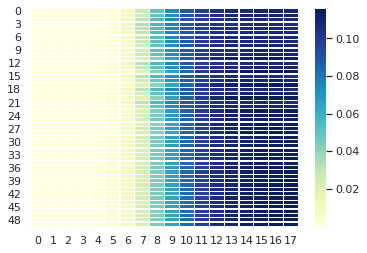

source:  do not keep water collected at home in coolers  in tanks on root  empty disused tin cans  in tyres  in flower pots  in empty bottles  money plants  bottles and cisterns 
actual:  <sos> घर में  कूलर में  छत पर खुली टंकियों में  बेकार टीन के खाली डिब्बों में  टायर में  फूलदान में  खाली बोतलों  मनीप्लान्ट के पौधों में  बोतलों और सिस्टर्नों में पानी को एकत्र न रखें ।
predicted:  में में प्रजनन में पहले में पहले में पहले में में में में अवधि के लिए अवधि के लिए अवधि की अवधि में वर्ष में अधिक अधिक अधिक अधिक में में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0.16161242898241945


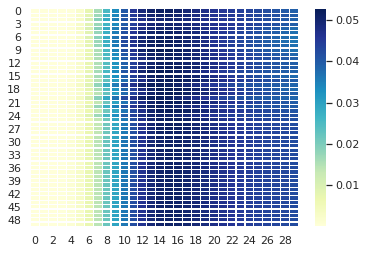

source:  keep the water in coolers  tubs  pitchers at home changing twice a week 
actual:  <sos> घर में कूलर  बाल्टी  घड़े के पानी को प्रति दिन सप्ताह में दो बार बदलते रहें ।
predicted:  में में पहले में पहले में अन्तराष्ट्रीय में सभी लैन्स में में अवधि में वर्ष में अधिक अधिक अधिक अवधि में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


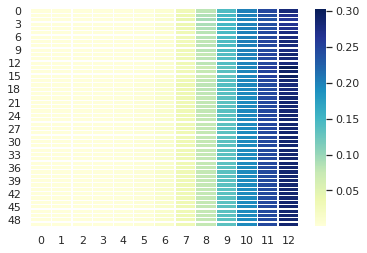

source:  do not let water collect near home 
actual:  <sos> घर के आसपास पानी न इकट्ठा होने दें ।
predicted:  कैंसर के लिए लिए लिए लिए लिए लिए लिए लिए लिए जाँच हो । <eos>
BLEU Score:  0.1969244213551724


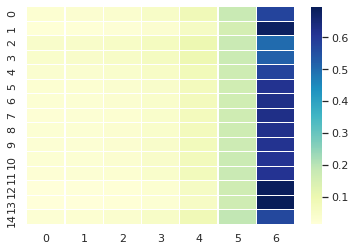

source:  fill the ditches with soil 
actual:  <sos> गड्ढों को मिट्टी डाल कर पाट दें ।
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए बुखार । <eos>
BLEU Score:  0.19817632389021378


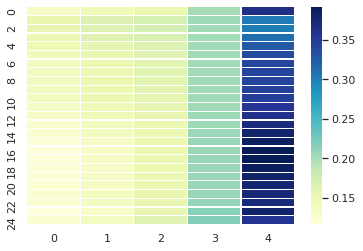

source:  if filling with soil is not possible  spray kerosene oil etc  in the ditch 
actual:  <sos> मिट्टी डालना संभव न हो सके तो उस गड्ढे में मिट्टी का तेल आदि छिड़क दें ।
predicted:  पहले जाँच से परीक्षण का परीक्षण का कैंसर का कैंसर से बचाव से कैंसर से कैंसर से जाँच से कम से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर
BLEU Score:  0


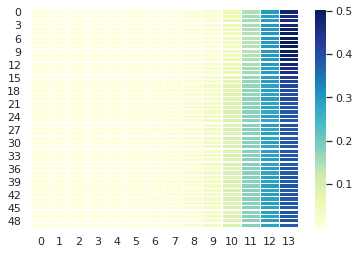

source:  use neem oil or mustard oil over body 
actual:  <sos> शरीर पर नीम का तेल या सरसों के तेल का उपयोग करें ।
predicted:  दौरान ग्रसित रंग में चलाया । <eos>
BLEU Score:  0.19112328397109352


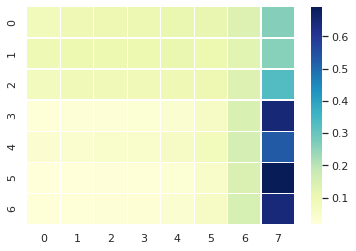

source:  use full sleeve shirts and socks 
actual:  <sos> पूरी आस्तीन की कमीज तथा मोजे आदि का प्रयोग करें ।
predicted:  में लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए बुखार । <eos>
BLEU Score:  0.1940679506664638


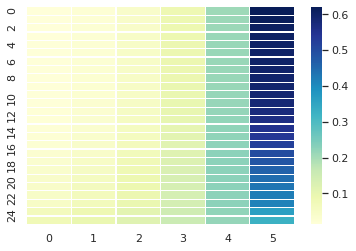

source:  you must get boys wear full sleeve clothes and socks when they are going to school 
actual:  <sos> बालक बालिकाओं को स्कूल जाते समय पूरी आस्तीन का कपड़ा  मोजे अवश्य पहनायें ।
predicted:  धीरे है <eos>
BLEU Score:  0


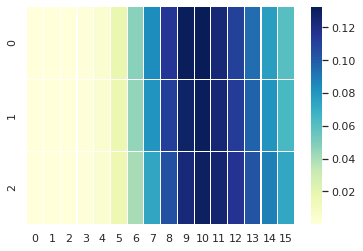

source:  get insecticides sprayed at home 
actual:  <sos> घर में कीटनाशक दवाओं का छिड़काव करवायें ।
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए बुखार । <eos>
BLEU Score:  0.19817632389021378


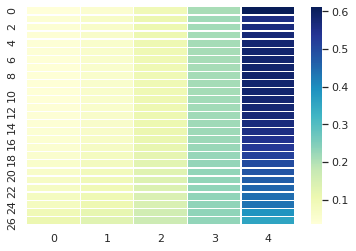

source:  keep the environment clean at home and nearby 
actual:  <sos> घर तथा आसपास वातावरण को स्वच्छ रखें ।
predicted:  में पहले पहले पहले बाद बाद सभी सभी सभी सभी जाँच से लिए लिए लिए जाँच है <eos>
BLEU Score:  0


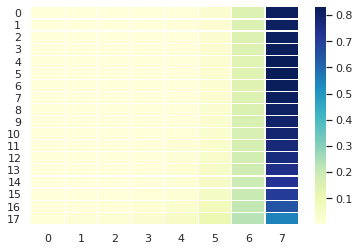

source:  get treatment during the disease outburst  on coming of fever at the government hospital health center 
actual:  <sos> रोग प्रकोप के समय  ज्वर होने पर नजदीक के सरकारी अस्पताल प्रा०स्वा०केन्द्र में उपचार लें ।
predicted:  में में पहले ग्रंथी में पहले में पहले में अवधि के लिए अवधि है <eos>
BLEU Score:  0


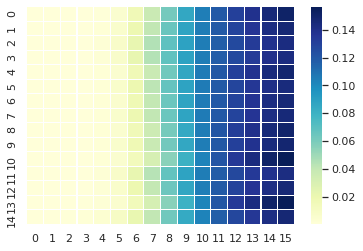

source:  you must use mosquito nets or antimosquito incense sticks while sleeping 
actual:  <sos> सोते समय मच्छरदानी अथवा मच्छररोधी अगरबत्ती का प्रयोग अवश्य करें ।
predicted:  विधि विधि कैपस्यूल कैपस्यूल हेतु है <eos>
BLEU Score:  0


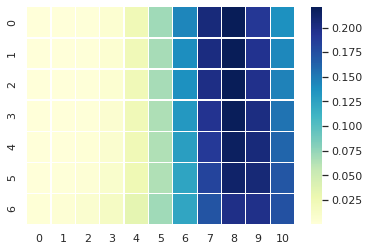

source:  you must install nets on windows  doors and clerestorys 
actual:  <sos> घरों की खिड़कियों दरवाजों एवं रोशन दानों पर जाली अवश्य लगायें ।
predicted:  धीरे धीरे लेकिन खाली संख्या है <eos>
BLEU Score:  0


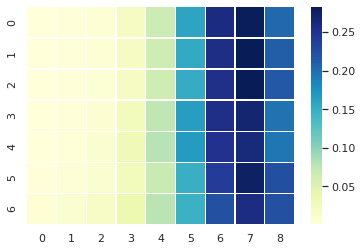

source:  nonsteroidal drugs should not be taken in dengue fever 
actual:  <sos> डेंगू बुखार में कास्टायड दवाइयाँ न ली जायें ।
predicted:  धीरे धीरे लेकिन खाली लिए अवधि बढ़ता <eos>
BLEU Score:  0.1969244213551724


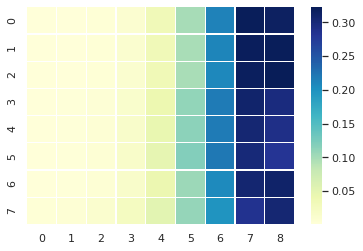

source:  diabetes is such a kind of disease as a result of which sugar becomes very high in blood 
actual:  <sos> डायबिटीज एक ऐसी बीमारी है जिसके परिणामस्वरूप रक्त में बहुत अधिक शर्करा ग्लूकोज हो जाती है ।
predicted:  एक जाँच की जाँच के कारण व्यक्ति के कारण व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति जाँच के लिए जाँच के लिए जाँच के लिए जाँच के लिए व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति जाँच के व्यक्ति जाँच के लिए जाँच से जाँच के लिए जाँच से जाँच
BLEU Score:  0


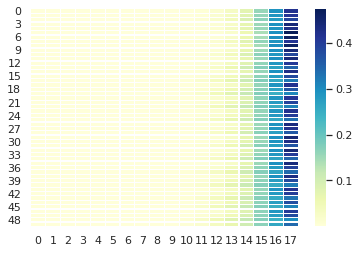

source:  diabetes is a serious disease which  if not controlled  can be killing 
actual:  <sos> डायबिटीज एक गंभीर बीमारी है  जिसे यदि नियंत्रित न किया गया तो जानलेवा हो सकती है ।
predicted:  एक जाँच के लिए व्यक्ति के लिए व्यक्ति के लिए व्यक्ति की व्यक्ति की व्यक्ति की व्यक्ति की जाँच हो है । <eos>
BLEU Score:  0.18429333166740366


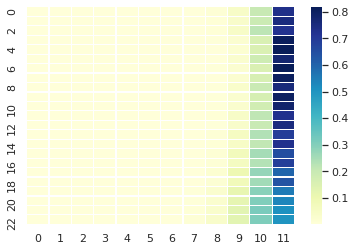

source:  on being under attack of diabetes our body forms insulin which helps in lessening sugar 
actual:  <sos> डायबिटीज रोग से ग्रसित होने पर हमारा शरीर इन्सुलिन बनाता है  जिससे शर्करा कम करने में मदद मिलती है ।
predicted:  एक जाँच के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति व्यक्ति के लिए जाँच के लिए जाँच के लिए व्यक्ति के लिए व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति व्यक्ति के लिए व्यक्ति के लिए व्यक्ति के लिए व्यक्ति
BLEU Score:  0


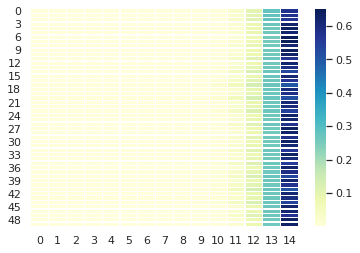

source:  sugar increases in the blood with lack of insulin 
actual:  <sos> इन्सुलिन की कमी से रक्त में शर्करा बढ़ जाती है ।
predicted:  जाँच के लिए व्यक्ति से व्यक्ति में जन्म सकता है । <eos>
BLEU Score:  0.1940679506664638


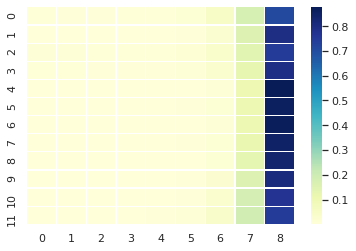

source:  if you have the following symptoms then you may have diabetes 
actual:  <sos> यदि आपमें निम्नलिखित लक्षण मौजूद हैं तो आपको डायबिटीज हो सकती है ।
predicted:  में में पहले ग्रंथी में अन्तराष्ट्रीय में सभी पहले में अवधि में अवधि में कैंसर में अधिक अधिक सुरक्षा में ऊपर में ऊपर में ऊपर में ऊपर में ऊपर में ऊपर में ऊपर में ऊपर में ऊपर में ऊपर में ऊपर में ऊपर में ऊपर में ऊपर में ऊपर में
BLEU Score:  0


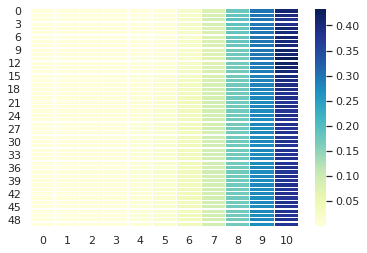

source:  frequent feeling of urination 
actual:  <sos> बारबार पेशाब आना ।
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए बुखार । <eos>
BLEU Score:  0.19564209772076444


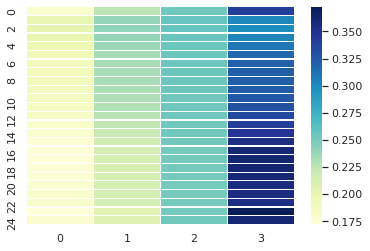

source:  feeling more thirsty and dim vision 
actual:  <sos> अधिक प्यास लगना  घुंधला दिखाई देना ।
predicted:  कैंसर के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए कम । <eos>
BLEU Score:  0.19817632389021378


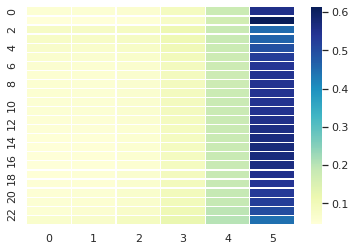

source:  physical inability in sexual activities 
actual:  <sos> सेक्स संबंधी क्रियाओं में शारीरिक असमर्थता ।
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए सुरक्षा लगना । <eos>
BLEU Score:  0.19913749124569236


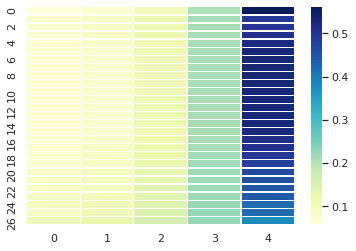

source:  numbness in feet or paralysing feeling in them 
actual:  <sos> पैरों का सुन्न हो जाना या उनमें झुनझनाहट होना ।
predicted:  में जाँच के कारण कारण परीक्षण के लिए लिए कारण जाँच से जाँच से लिए लिए जाँच से जाँच से लिए जाँच के लिए जाँच है <eos>
BLEU Score:  0


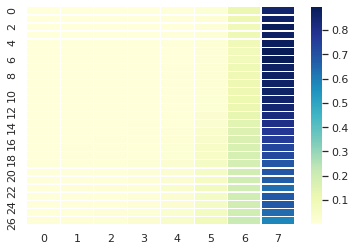

source:  problems occurring from diabetes 
actual:  <sos> डायबिटीज से होने वाली समस्याएँ ।
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए बुखार । <eos>
BLEU Score:  0.19953087735062713


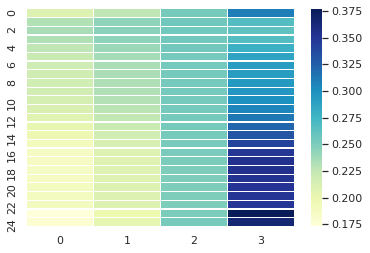

source:  the following problems and complexities can emerge from diabetes 
actual:  <sos> डायबिटीज से निम्न समस्याएँ एवं जटिलताएँ उत्पन्न हो सकती हैं ।
predicted:  जाँच के लिए लिए व्यक्ति के लिए लिए व्यक्ति की व्यक्ति की जाँच की जाँच हो है <eos>
BLEU Score:  0


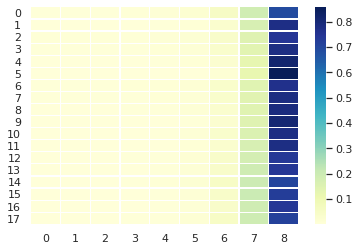

source:  excess of sugar in blood  long term complexities 
actual:  <sos> रक्त में शर्करा की अधिकता  दीर्घकालीन जटिलताएँ ।
predicted:  समय के लिए लिए बचाव का अधिक अधिक महीन सहयोग करें । <eos>
BLEU Score:  0.1969244213551724


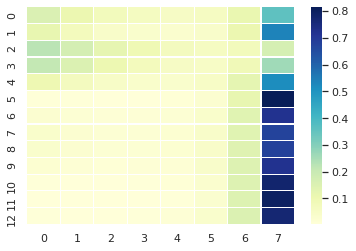

source:  damage to tendons or neuropathy 
actual:  <sos> स्नायुओं को क्षति या न्यूरोपैथी ।
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए बुखार । <eos>
BLEU Score:  0.19953087735062713


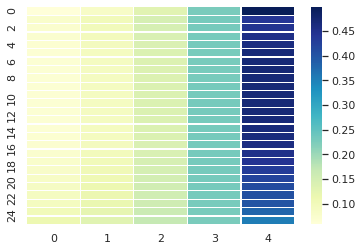

source:  damage to kidney or nephropathy 
actual:  <sos> गुर्दो को क्षति या नेफरोपैथी ।
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए सुरक्षा लगना । <eos>
BLEU Score:  0.1688992412286964


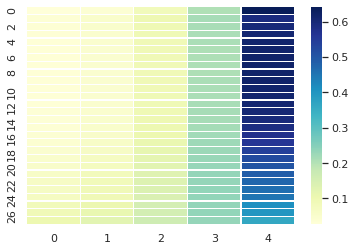

source:  damage to eyes or retinopathy 
actual:  <sos> आँखों को क्षति या रेटिनोपैथी ।
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए बुखार । <eos>
BLEU Score:  0.19953087735062713


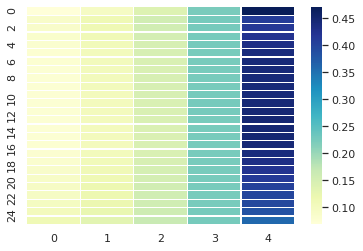

source:  disease and contraction of heart and blood vessels 
actual:  <sos> ह्दय और रक्त वाहिनी की बीमारी एवं संक्रमण ।
predicted:  जाँच के लिए लिए व्यक्ति के लिए लिए व्यक्ति की व्यक्ति की लिए जाँच हो है <eos>
BLEU Score:  0


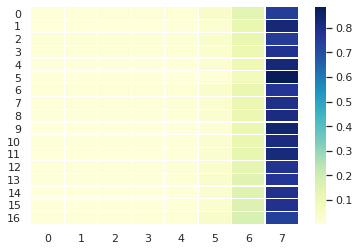

source:  long term complexities of diabetes 
actual:  <sos> डायबिटीज की दीर्घ कालिक जटिलताएँ ।
predicted:  समय इन लिए लिए लिए नाखून का ताजे सेवन । <eos>
BLEU Score:  0.19953087735062713


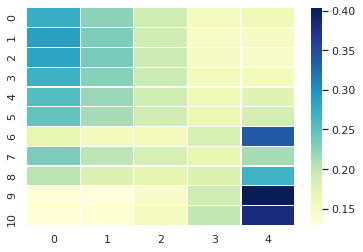

source:  damage to tendons  diabetes damages the tendons of feet and hands 
actual:  <sos> स्नायुओं को क्षति डायबिटीज पैरों और हाथों की स्नायुओं को क्षति पहुँचाती है ।
predicted:  कारण कैंसर के कारण व्यक्ति के लिए व्यक्ति के लिए व्यक्ति व्यक्ति के लिए व्यक्ति की व्यक्ति की जाँच की जाँच हो है । <eos>
BLEU Score:  0.18968126713037053


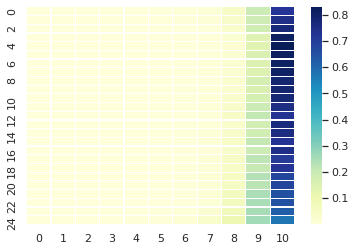

source:  shivering  numbness  inflammation or pain may occur due to damage to the tendons which often starts from the tip of the fingers of your feet or hands and increases gradually upwards 
actual:  <sos> स्नायुओं को क्षति होने से झुनझुनाहट  सुन्न पड़ना  जलन या दर्द हो सकता है  जो अक्सर आप हाथ पैर की अंगुलियों के छोर से शुरू हो कर धीरेधीरे ऊपर की ओर बढ़ता है ।
predicted:  निश्‍चित में में पहले में पहले में में बाद में में में में में में में में होने में बोतलों में अधिक अधिक अधिक में में में में में में में में में में में में में में में में में में में में में में में में में में
BLEU Score:  0


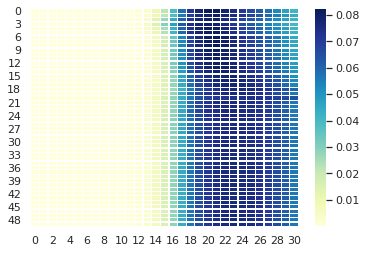

source:  if treatment is not done then you can lose the power of feeling in the affected organs 
actual:  <sos> यदि इलाज न किया गया तो आप प्रभावित अंगों में महसूस करने की शक्ति गवां सकते हैं ।
predicted:  वर्ष में में पहले में परीक्षण में में कैंसर में में में में में में अवधि में वर्ष में अधिक अधिक अधिक में में में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


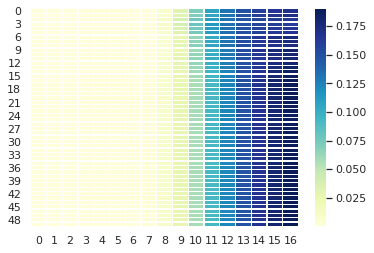

source:  damage to kidney  delicate filtering system present in the kidney may be damaged with diabetes by which kidneys may stop working and dialysis or kidney transplantation may be required 
actual:  <sos> गुर्दों को क्षति डायबिटीज से गुर्दों मे मौजूद नाजुक छनन संस्थान को क्षति पहुँच सकती है  जिससे गुर्दे काम करना बन्द कर सकते हैं और डायलासिस या गुर्दा प्रतिरोपण जरूरी हो सकता है ।
predicted:  वर्ष में में पहले में पहले में अन्तराष्ट्रीय में में क्षति के लिए अवधि के लिए अवधि के लिए अवधि के लिए पहले में में कैंसर में कैंसर में अधिक अधिक अधिक में में में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


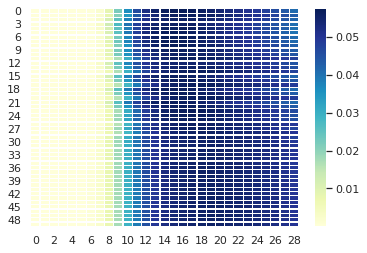

source:  diabetes may damage the retina of your eyes which may cause blindness 
actual:  <sos> डायबिटीज आपकी आँखों की रेटिना को क्षति पहुँचा सकती है  जिससे अंधापन हो सकता है ।
predicted:  एक जाँच के कारण व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति व्यक्ति हो है । <eos>
BLEU Score:  0.18557819854739144


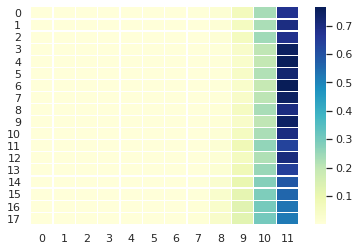

source:  disease of heart and blood vessels  the main complexity of diabetes is the damage of heart and blood vessels by which heart attack  paralysis and defect in blood circulation may occur 
actual:  <sos> हृदय और रक्त वाहिनी की बीमारी डायबिटीज की प्रमुख जटिलता है  हृदय और रक्त वाहिनियों की क्षति  जिससे दिल का दौरा  पक्षाघात और रक्त संचारण में खराबी हो सकती है ।
predicted:  वर्ष में में पहले में पहले में किसी पहले में में में में जाँच में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


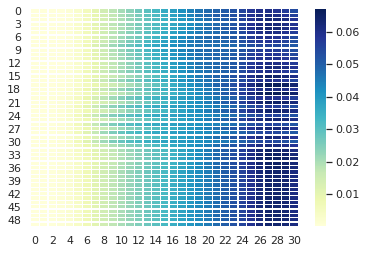

source:  studies have proved that dangers of heart attack and paralysis is more among the people with diabetes than those who do not have diabetes 
actual:  <sos> अध्ययनों ने यह प्रमाणित कर दिया है कि दिल का दौरा और पक्षाघात का खतरा डायबिटीज वाले लोगों में  उन लोगों की अपेक्षा अधिक होता है जिन्हें डायबिटीज नहीं है ।
predicted:  वर्ष में में पहले में पहले में महिला में कैंसर में कैंसर में वर्ष के लिए अवधि की अवधि के लिए अवधि की अवधि में वर्ष में वर्ष में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


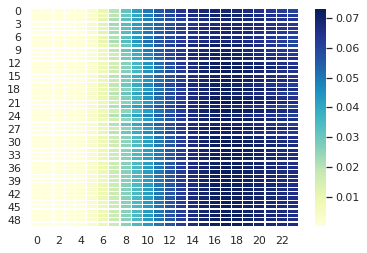

source:  excess of sugar in the infected blood decreases your immune strength and the danger of infection increases by this 
actual:  <sos> संक्रमण रक्त में शर्करा की अधिकता आपकी रोग प्रतिरोधक शक्ति को कम कर देती है और इससे संक्रमण होने का खतरा बढ़ जाता है ।
predicted:  एक जाँच कैंसर के कारण एक व्यक्ति के कारण एक व्यक्ति के व्यक्ति जाँच के व्यक्ति जाँच के लिए जाँच के लिए जाँच के लिए जाँच के कारण जाँच के व्यक्ति एक जाँच के व्यक्ति जाँच के व्यक्ति एक जाँच के व्यक्ति जाँच के व्यक्ति एक जाँच के लिए जाँच
BLEU Score:  0


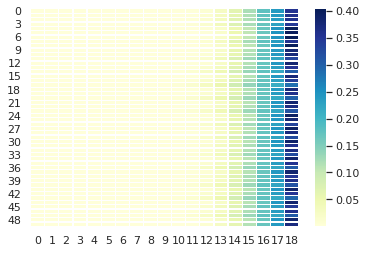

source:  your mouth  gums  lungs  skin  feet  kidney  bladder and the areas of reproductive organs  all of them can be easily affected with contagion 
actual:  <sos> आपके मुँह  मसूड़े  फेफड़े  त्वचा  पैर  गुर्दे  मूत्राशय और जननेन्द्रियों के क्षेत्र  सभी के सभी संक्रमण से आसानी से प्रभावित हो सकते हैं ।
predicted:  वर्ष में में पहले में पहले में अन्तराष्ट्रीय में में क्षति के लिए अवधि के लिए अवधि के लिए अवधि के लिए पहले में में कैंसर में कैंसर में अधिक अधिक अधिक में में में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


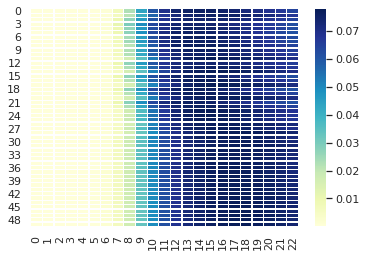

source:  dangers of diabetes related complexities can be decreased to a great extent with the control of sugar in the blood and adopting healthy lifestyle 
actual:  <sos> डायबिटीज से सम्बद्ध जटिलताओं का खतरा  रक्त मे शर्करा  ग्लूकोज  के सही नियंत्रण से और स्वस्थ्य जीवन शैली अपना कर  काफी कम किया जा सकता है ।
predicted:  कैंसर एक जाँच के कारण जाँच के कारण परीक्षण के कारण जाँच के कारण जाँच के जाँच जाँच के जाँच एक जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के
BLEU Score:  0


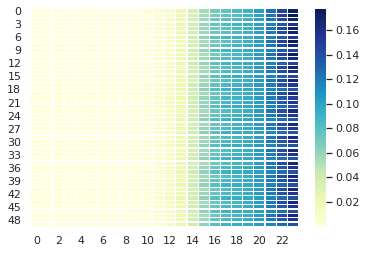

source:  the chances of bringing the situation back to the predamage stage or minimizing it increases by finding out the complexities early through regular medical tests 
actual:  <sos> नियमित डॉक्टरी जाँच द्वारा जटिलताओं का शीघ्र पता लगा कर नुकसान को पूर्व ठीक स्थिति में लौटाने या कम से कम करने के अवसर बढ़ जाते हैं ।
predicted:  एक एक जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के जाँच एक जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के
BLEU Score:  0


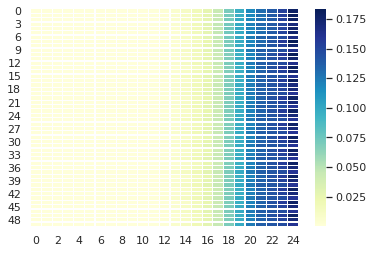

source:  every disease occurs due to a type of virus 
actual:  <sos> हर रोग एक प्रकार के विषाणु  वायरस  से होता है ।
predicted:  जाँच के लिए व्यक्ति के लिए व्यक्ति की व्यक्ति की व्यक्ति की व्यक्ति की जाँच हो है । <eos>
BLEU Score:  0.19112328397109352


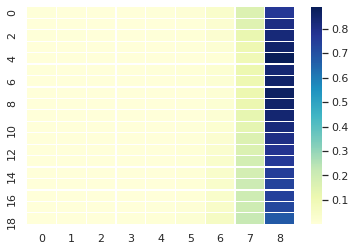

source:  virus is so small that they can not be seen through common microscope 
actual:  <sos> विषाणु इतने सूक्ष्म होते हैं कि साधारण सूक्ष्मदर्शी  माइक्रोस्कोप  से भी नहीं देखे जा सकते हैं ।
predicted:  में में पहले में पहले में अन्तराष्ट्रीय में लैन्स में में क्षति है <eos>
BLEU Score:  0


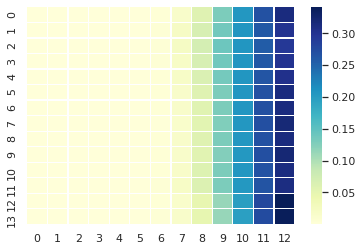

source:  if polluted mosquito bites a person then the virus enters into the body of that person 
actual:  <sos> दूषित मच्छर किसी स्वस्थ व्यक्ति को काटता है तो विषाणु उस व्यक्ति के शरीर में प्रवेश कर जाते हैं ।
predicted:  एक जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच
BLEU Score:  0


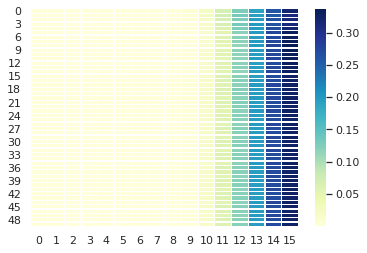

source:  after about  to  days the symptoms of disease start appearing in that person 
actual:  <sos> लगभग  से  दिन के बाद उस स्वस्थ व्यक्ति में बीमारी के लक्षण दिखायी देने लगते हैं ।
predicted:  पहले से जाँच का परीक्षण का परीक्षण के कारण जाँच से क्षेत्र से कैंसर से कैंसर से जाँच से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर
BLEU Score:  0


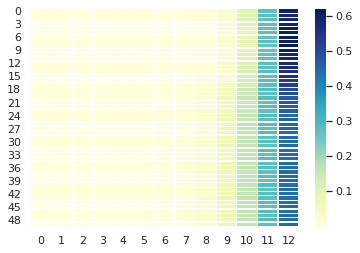

source:  usually the following symptoms are found in the patients of diabetes 
actual:  <sos> डायबिटीज रोग से ग्रसित रोगी में प्रायः निम्न लक्षण पाये जाते हैं 
predicted:  प्रजनन में दिनों पहले पहले परीक्षण में में कैंसर में में संख्या है है <eos>
BLEU Score:  0


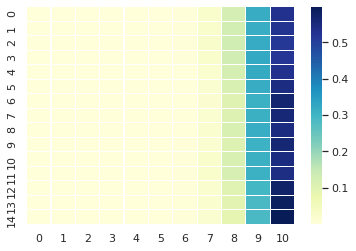

source:  high fever 
actual:  <sos> तेज बुखार ।
predicted:  है <eos>
BLEU Score:  0


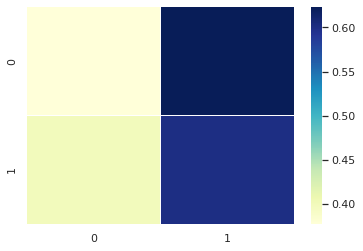

source:  acute pain 
actual:  <sos> भयानक सरदर्द ।
predicted:  है <eos>
BLEU Score:  0


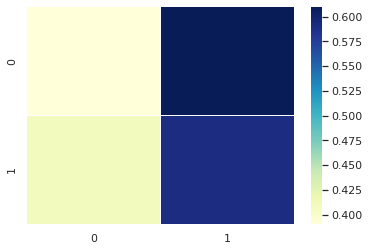

source:  stiffness in neck 
actual:  <sos> गर्दन में अकड़न ।
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए बुखार । <eos>
BLEU Score:  0.19564209772076444


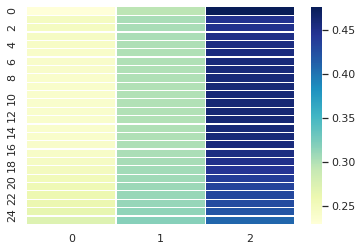

source:  stiffness in body 
actual:  <sos> शरीर में अकड़न ।
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए बुखार । <eos>
BLEU Score:  0.19564209772076444


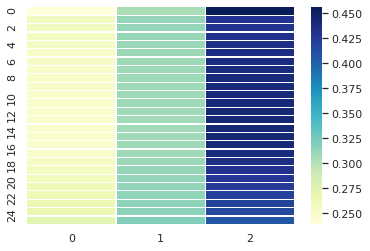

source:  strokes in body 
actual:  <sos> शरीर में झटके लगना ।
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए बुखार । <eos>
BLEU Score:  0.19879212680993805


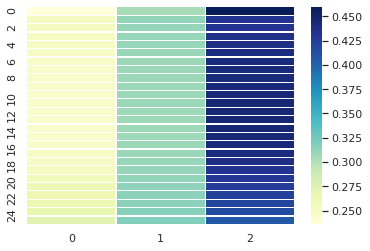

source:  nausea and vomiting 
actual:  <sos> मितली व उल्टी आना ।
predicted:  की लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए बुखार । <eos>
BLEU Score:  0.19879212680993805


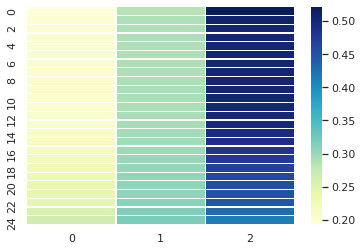

source:  fainting or total nervousness 
actual:  <sos> अर्द्ध अथवा पूर्ण बेहोशी आना ।
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए बुखार । <eos>
BLEU Score:  0.19953087735062713


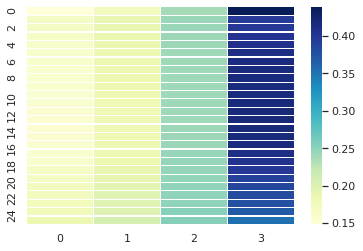

source:  as soon as the above mentioned symptoms appear the patient should immediately be admitted for treatment at the nearby primary health center  subdivisional government hospital or district hospital 
actual:  <sos> रोगी में उपर्युक्त लक्षण दिखाई देते ही उसे तुरन्त नजदीक के प्राथमिक स्वास्थ्य केन्द्र  तहसील स्तरीय राजकीय चिकित्सालय अथवा जिला चिकित्सालय में चिकित्सा हेतु भर्ती करवा देना चाहिये ।
predicted:  में में प्रजनन में पहले में पहले में पहले में में अवधि के लिए अवधि के लिए अवधि की अवधि में वर्ष में अधिक अधिक अधिक अधिक में में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


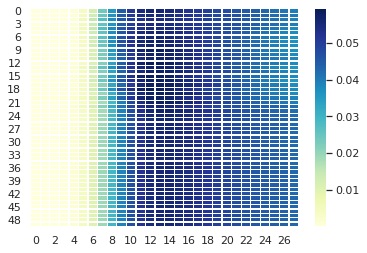

source:  malaria spreads through mosquitoes therefore it is necessary that the number of mosquitoes be decreased in community 
actual:  <sos> मलेरिया रोग मच्छरों द्वारा फैलता है  इसलिये यह आवश्यक है कि समुदाय में मच्छरों की संख्या को घटाया जाए ।
predicted:  में में प्रजनन में पहले में अन्तराष्ट्रीय में पहले में में अवधि में में अवधि में अधिक अधिक अधिक अवधि में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


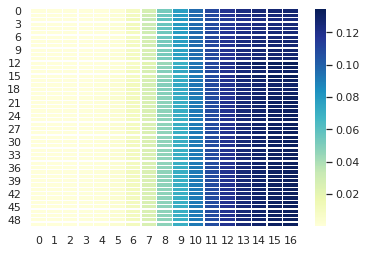

source:  disease carrying mosquitoes mainly reside outside home in paddy fields  ponds and ditches filled with water 
actual:  <sos> रोगवाहक मच्छर मुख्य रूप से घरों से बाहर धान के खेतों  पोखरों एवं पानी से भरे गड्ढों में रहते हैं ।
predicted:  वर्ष में में पहले में पहले में अन्तराष्ट्रीय में में क्षति के लिए अवधि के लिए अवधि के लिए अवधि के लिए पहले में में कैंसर में कैंसर में वर्ष में अधिक अधिक अधिक अधिक में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


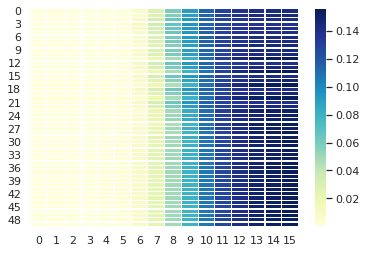

source:  pay special attention towards cleanliness at home and outside 
actual:  <sos> घर तथा बाहर की स्वच्छता पर विशेष ध्यान रखें ।
predicted:  में पहले से पहले परीक्षण का पता के लिए सभी जाँच से जाँच से लिए लिए जाँच से जाँच से लिए जाँच से कैंसर से कैंसर में सुरक्षा से कैंसर में सुरक्षा से कैंसर में सुरक्षा से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर
BLEU Score:  0


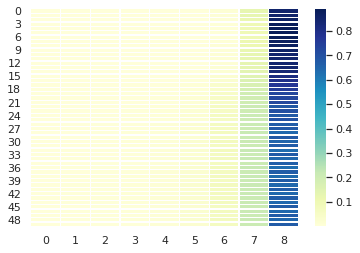

source:  fill the ditches  cut tall grass and bushes 
actual:  <sos> गड्ढों को पाट दें  बड़ीबड़ी घास व झाड़ियों को काट दें ।
predicted:  ऊतकों है <eos>
BLEU Score:  0


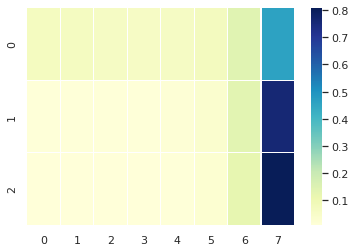

source:  wear pants  pyjama  dhoti  socks  full sleeved kurta or shirt in the evening 
actual:  <sos> शाम के समय पैन्ट  पैजामा  धोती  मोजे  पूरी बाँह का कुर्ता या कमीज पहनें ।
predicted:  धीरे धीरे लेकिन खाली संख्या है <eos>
BLEU Score:  0


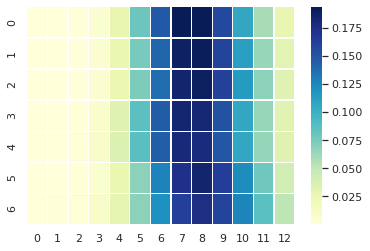

source:  use mosquito nets while sleeping wherever possible 
actual:  <sos> सोते समय जहाँ तक संभव हो मच्छरदानी का प्रयोग करें ।
predicted:  में सभी लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए सुरक्षा लगना । <eos>
BLEU Score:  0.1940679506664638


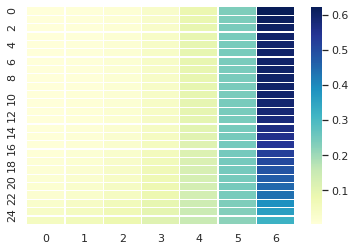

source:  do not let rain water collect near the ditches nearby house 
actual:  <sos> जहाँ तक संभव हो बरसाती पानी को घर के आसपास गड्ढों में इकट्ठा न होने दें ।
predicted:  कारण कैंसर के कारण व्यक्ति के कारण व्यक्ति के लिए व्यक्ति की व्यक्ति की व्यक्ति की जाँच हो है । <eos>
BLEU Score:  0.18557819854739144


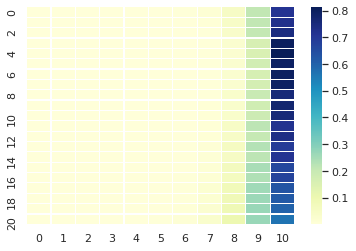

source:  cooperate with the health staffs in sprinkling insecticides and fogging 
actual:  <sos> कीटनाशक दवाओं के छिड़काव तथा फॉगिंग  धुआँ छोड़ने  में स्वास्थ्य कर्मचारियों का सहयोग प्रदान करें ।
predicted:  में ग्रंथी में पहले ग्रंथी में अवधि में लिए लिए अवधि है <eos>
BLEU Score:  0


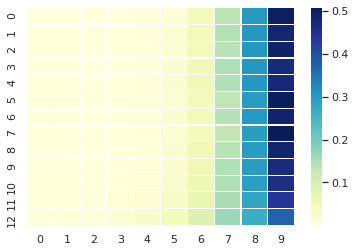

source:  use fine nets to stop mosquitoes enter the pigsties 
actual:  <sos> सुअर के बाड़ों में मच्छरों को जाने से रोकने के लिये महीन जाली का प्रयोग करें ।
predicted:  में पहले पहले पहले बाद बाद सभी सभी सभी सभी जाँच से लिए लिए लिए जाँच है <eos>
BLEU Score:  0


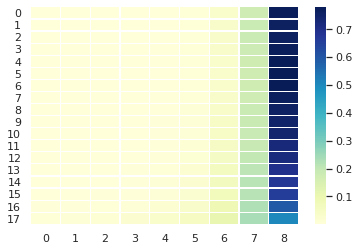

source:  get the vaccine of encephalitis administered in time 
actual:  <sos> समय से एन्सेफलाइटिस का टीका लगवाएँ ।
predicted:  कैंसर के लिए लिए लिए व्यक्ति के लिए लिए लिए जाँच की लिए लिए जाँच हो । <eos>
BLEU Score:  0.19913749124569236


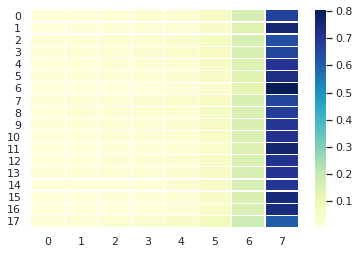

source:  hepatitisa is one of the most widespread disease spreading in the whole world 
actual:  <sos> हेपेटाइटिसए विश्‍व भर में फैलने वाली एक सर्वाधिक व्यापक बीमारी है ।
predicted:  पहले जाँच का परीक्षण के कारण भी परीक्षण के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच
BLEU Score:  0


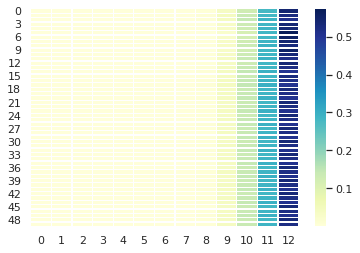

source:  this occurs due to hepatitisa virus and it is common at places with bad level of cleanliness 
actual:  <sos> यह हेपेटाइटिसए वायरस के कारण होती है और साफ सफाई के खराब स्तर वाले स्थानों पर यह आम है ।
predicted:  एक जाँच से जाँच के कारण परीक्षण के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के
BLEU Score:  0


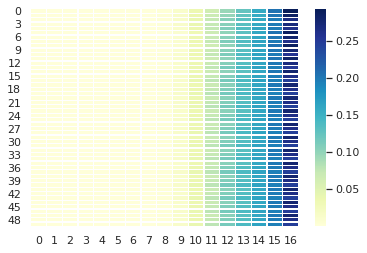

source:  virus attacks lever and causes diseases of different intensity to emerge in the patients 
actual:  <sos> वायरस यकृत  लीवर  पर हमला करता है और मरीजों मे भिन्न तीव्रता की बीमारी उभारता है ।
predicted:  प्रजनन में में पहले में परीक्षण में में कैंसर में में में में अवधि में होता है । <eos>
BLEU Score:  0.18305025818318518


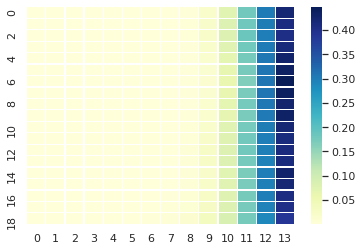

source:  hepatitisa viral spreads in the faeces and at first it spreads through the anal passage 
actual:  <sos> हेपेटाइटिसए वायरल मल मे फैलता है और प्रथमतः गुदामुख मार्ग द्वारा प्रसार करता है ।
predicted:  वर्ष में में पहले में पहले में अन्तराष्ट्रीय में में पहले में में अवधि में वर्ष में अधिक अधिक अधिक अधिक में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


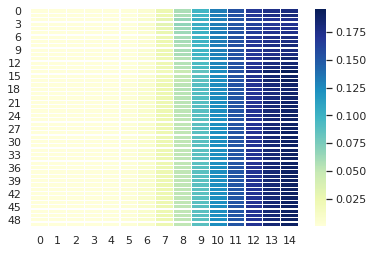

source:  the virus comparatively takes long time to show symptoms and is contagious 
actual:  <sos> वायरस तुलनात्मक रूप से लक्षण प्रकट करने में लंबा समय लेता है और संक्रामक होता है ।
predicted:  पहले से पहले परीक्षण का परीक्षण में कैंसर में क्षेत्र में में यह जाँच से वर्ष से कैंसर से कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर
BLEU Score:  0


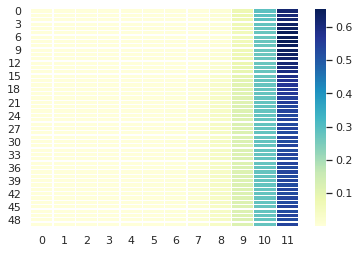

source:  therefore the infected person can spread the disease to other people even before it develops 
actual:  <sos> अतः संक्रमित व्यक्ति विकसित होने से पूर्व ही बीमारी अन्य लोगों तक फैला सकता है ।
predicted:  वर्ष में में पहले में प्रजनन में कैंसर में में क्षति में में वर्ष में वर्ष में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


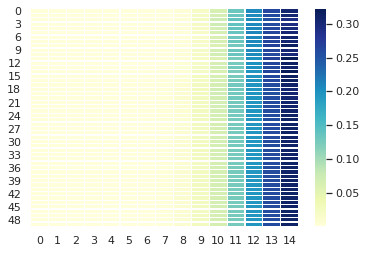

source:  nausea  jaundice  purge  light colored faeces  stomach ache  weakness  tiredness  fever  shivering  not feeling hungry  neck pain etc 
actual:  <sos> उबकाई उल्टी  पीलिया  आँखों  त्वचा व मूत्र का पीलापन  जुलाब  फीके रंग की शौच  पेट दर्द  कमजोरी  थकान  बुखार  कपकपी  भूख न लगना  गले में दर्द इत्यादि ।
predicted:  में में प्रजनन में पहले में पहले में पहले में अवधि के लिए अवधि के लिए अवधि की अवधि में वर्ष में अधिक अधिक अधिक अधिक में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0.1944387569440379


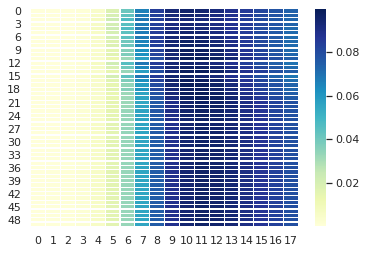

source:  symptoms are dependent on the frequency of emergence 
actual:  <sos> लक्षणों के उभरने की बारंबारता तीव्रता व्यक्ति की आयु पर निर्भर है ।
predicted:  से पहले पहले परीक्षण का क्षमता में सभी सभी जाँच से संख्या है <eos>
BLEU Score:  0


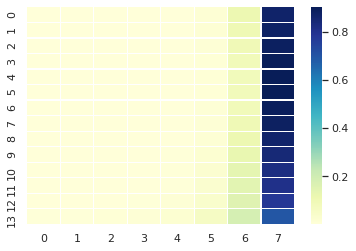

source:  hepatitisa and v are two different kinds of viral hepatitis that occur due to different kinds of viruses 
actual:  <sos> हेपेटाइटिसए और बी दो भिन्न प्रकार के वायरल हेपेटाइटिस हैं जो अलगअलग वायरसों के कारण होते हैं ।
predicted:  वर्ष में जाँच का परीक्षण का परीक्षण में कैंसर का कैंसर में में में में से जाँच से जाँच से कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में
BLEU Score:  0


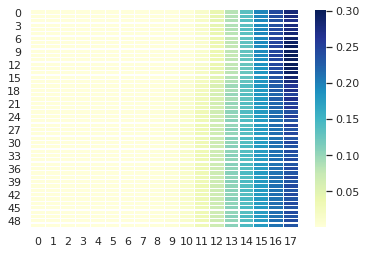

source:  every type of hepatitis is different 
actual:  <sos> हर प्रकार का हेपेटाइटिस अलग है ।
predicted:  समय इन लिए लिए बचाव का नाखून का सेवन हैं <eos>
BLEU Score:  0


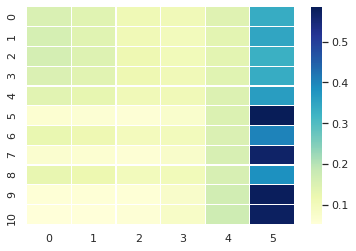

source:  hepatitisa can not be avoided with the vaccination of hepatitisb 
actual:  <sos> हेपेटाइटिसबी के प्रति टीकाकरण से हेपेटाइटिसए से बचाव नहीं होता ।
predicted:  जाँच के कारण व्यक्ति के कारण व्यक्ति के लिए व्यक्ति व्यक्ति के लिए व्यक्ति की व्यक्ति की लिए जाँच हो है । <eos>
BLEU Score:  0.1940679506664638


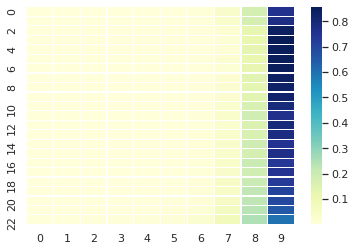

source:  similarly  hepatitisb can not be avoided with the vaccination of hepatitisa 
actual:  <sos> इसी तरह हेपेटाइटिसए के टीके से हेपेटाइटिसबी से बचाव नहीं होता ।
predicted:  पहले से पहले परीक्षण का परीक्षण में कैंसर में में बचाव से संख्या है । <eos>
BLEU Score:  0.19259074009082888


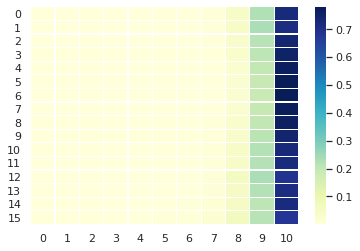

source:  the vaccine is available now and is the most practical solution against hepatitisa 
actual:  <sos> अब टीका उपलब्ध है और हेपेटाइटिसए के खिलाफ सुरक्षा का सर्वाधिक व्यवहार्य उपाय है ।
predicted:  पहले से जाँच का परीक्षण का परीक्षण का कैंसर का कैंसर से यह जाँच से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर में कैंसर की कैंसर से कैंसर में कैंसर की कैंसर से कैंसर में कैंसर की कैंसर से कैंसर में कैंसर से कैंसर से कैंसर
BLEU Score:  0


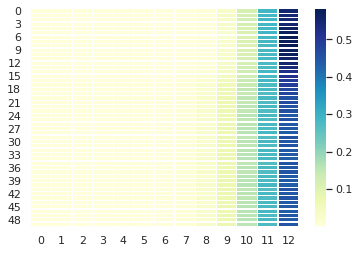

source:  primary vaccination keeps a person safe for a year and the booster dose administered after six months gives safety for about  years 
actual:  <sos> प्राथमिक टीकाकरण व्यक्ति को एक वर्ष तक सुरक्षित रखता है और  माह बाद दिया जाने वाला बूस्टर डोज अनुमानतः कम से कम  वर्ष सुरक्षा देता है ।
predicted:  वर्ष में में पहले में परीक्षण का कैंसर में कैंसर में में वर्ष में वर्ष में वर्ष में वर्ष में कैंसर में कैंसर में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में वर्ष में
BLEU Score:  0


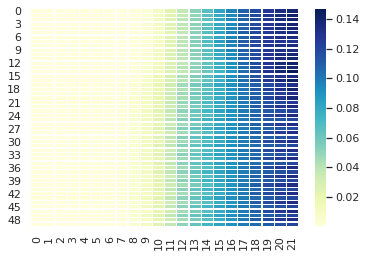

source:  a combined vaccine is available from glaxosmithkline which provides safety from  both hepatitisa and hepatitisb through a single safety order administered at    months 
actual:  <sos> ग्लेक्सोम्थिक्लाइन द्वारा एक संयुक्त टीका उपलब्ध है जो      महीनों पर दिए जाने वाले एकल बचाव क्रम द्वारा हेपेटाइटिसए और हेपेटाइटिसबी दोनों से सुरक्षा प्रदान करता है ।
predicted:  वर्ष प्रजनन से पहले परीक्षण का परीक्षण का कैंसर में कैंसर में में यह में यह यह यह यह यह वर्ष की वर्ष में वर्ष की कैंसर में वर्ष में वर्ष की कैंसर में कैंसर में वर्ष की कैंसर में कैंसर में वर्ष की कैंसर में कैंसर में वर्ष में
BLEU Score:  0


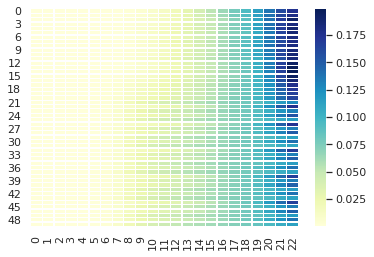

source:  the combined vaccine of hepatitisa and hepatitisb is available in two forms 
actual:  <sos> हेपेटाइटिसए और हेपेटाइटिसबी का संयुक्त टीका दो रूपों मे उपलब्ध है ।
predicted:  एक जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच
BLEU Score:  0


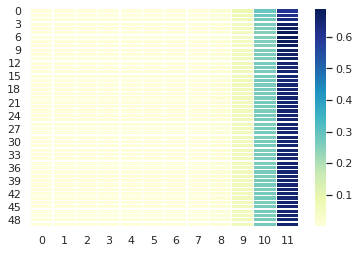

source:  paediatric dose  one dose is of   ml for children and adolescents 
actual:  <sos> पेडियाट्रिक खुराक  बच्चों और  से  वर्ष आयु के किशोरों के लिए  मिली की एक खुराक होती है ।
predicted:  एक जाँच के कारण व्यक्ति के कारण व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति व्यक्ति के लिए व्यक्ति की व्यक्ति की जाँच हो है । <eos>
BLEU Score:  0.17956076853248887


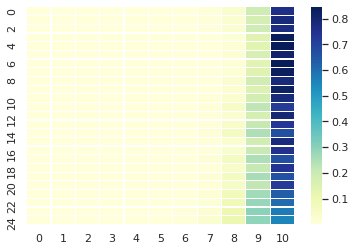

source:  adult dose  the dose is of   ml for adults of the age of  years and above 
actual:  <sos> वयस्क खुराक   वर्ष और अधिक आयु के वयस्कों के लिए  मिली की खुराक होती है ।
predicted:  एक जाँच के कारण व्यक्ति के व्यक्ति एक व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति जाँच की जाँच हो है । <eos>
BLEU Score:  0.18305025818318518


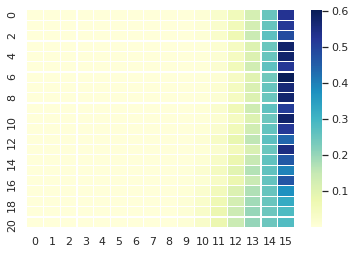

source:  hepatitisb is a worldwide disease which occurs due to hepatitisb virus lrb hbv rrb 
actual:  <sos> हेपेटाइटिसबी विश्‍वव्यापी बीमारी है  जो हेपेटाइटिसबी वायरस  एचबीवी  के कारण होती है ।
predicted:  एक जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच
BLEU Score:  0


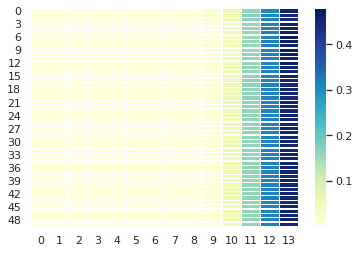

source:  hbv affects mainly liver by which an inflammation occurs 
actual:  <sos> एचबीपी मुख्यतः यकृत को प्रभावित करते हैं जिससे जलन होती है
predicted:  में ग्रंथी में महिला में महिला में सभी सभी जाँच से अवधि से लिए जाँच में ऊपर में ऊपर में ऊपर में ऊपर में ऊपर में ऊपर में ऊपर में ऊपर में ऊपर में ऊपर में ऊपर में ऊपर में ऊपर में ऊपर में ऊपर में ऊपर में ऊपर में
BLEU Score:  0


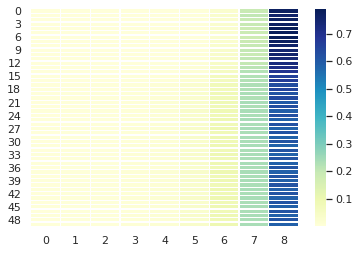

source:  the cells of liver gets destroyed and the function of liver often gets interrupted 
actual:  <sos> यकृत की कोशिकाएँ नष्ट होती हैं और यकृत का कार्य अक्सर बाधित हो जाता है ।
predicted:  एक जाँच के कारण व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति की जाँच की जाँच की जाँच हो है । <eos>
BLEU Score:  0.18690518620528904


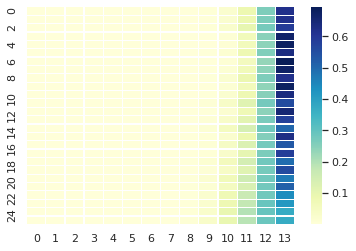

source:  the results of infection are different and unexpected 
actual:  <sos> संक्रमण के परिणाम भिन्नभिन्न और अनापेक्षित होते हैं ।
predicted:  जाँच के लिए लिए कारण के लिए लिए लिए जाँच से जाँच होती । <eos>
BLEU Score:  0.1969244213551724


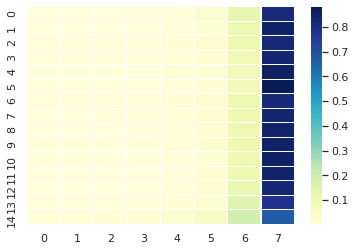

source:  the results of infection are dependent on the age of patient and state of the capacity of the immune system 
actual:  <sos> संक्रमण के परिणाम मरीज की आयु और प्रतिकारक क्षमता की स्थिति पर आधारित होते हैं ।
predicted:  एक जाँच जाँच के कारण भी के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण
BLEU Score:  0


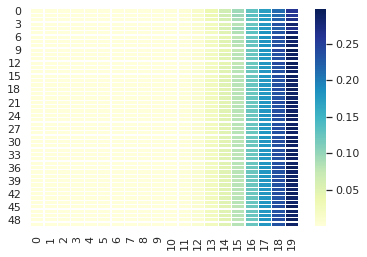

source:  hepatitisb is extremely contagious and it is thought to be  times more contagious than the hiv 
actual:  <sos> हेपेटाइटिसबी अत्यंत संक्रामक है  इसे एड्स पैदा करने वाले एचआईवी की तुलना में  गुना ज्यादा संक्रामक माना जाता है ।
predicted:  वर्ष में में पहले में पहले में अन्तराष्ट्रीय में में क्षति में में संख्या है है और वर्ष के लिए अवधि की अवधि की अवधि में अधिक अधिक अधिक अधिक में में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


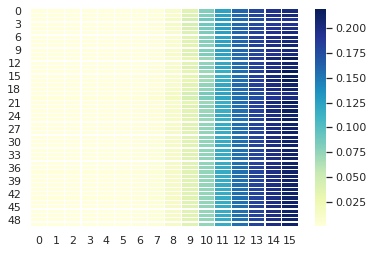

source:  in comparison with aids  hepatitisb victimises more people to death in the whole year 
actual:  <sos> हैपेटाइटिसबी पूरे वर्ष भर में प्रतिदिन एड्स की तुलना में ज्यादा लोगों को मौत का शिकार बनाता है ।
predicted:  वर्ष में में पहले में पहले में कैंसर में में क्षति में में संख्या है है और वर्ष के लिए अवधि की अवधि की अवधि में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


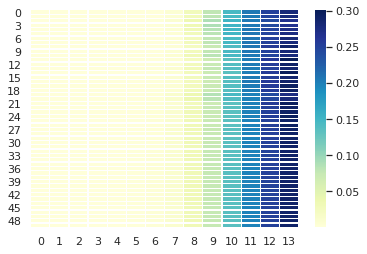

source:  blood is the most important vehicle in the spread of hepatitisb disease but it can also spread through other body fluids in which sperm  vaginal fluids and saliva are included 
actual:  <sos> हैपेटाइटिसबी रोग के प्रसार में रक्त सर्वाधिक महत्वपूर्ण साधन हैं लेकिन ये अन्य शारीरिक द्रव्यों के माध्यम से भी फैल सकता है जिसमें शामिल हैं वीर्य  योनिमार्ग से स्त्राव और लार ।
predicted:  वर्ष में में पहले में पहले में महिला में कैंसर में वर्ष में वर्ष के लिए अवधि की अवधि की अवधि में वर्ष में वर्ष में वर्ष में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


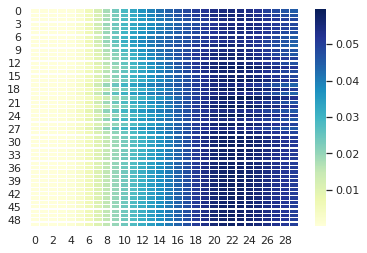

source:  hbv spreads in three ways  from mother to child  at birth time and from person to person 
actual:  <sos> एचबीवी तीन माध्यमों से फैलता है  माँ से बच्चे में  जन्म पर और व्यक्ति से व्यक्ति में ।
predicted:  कारण जाँच के कारण जाँच के कारण भी कभी स्तर के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के लिए जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के
BLEU Score:  0


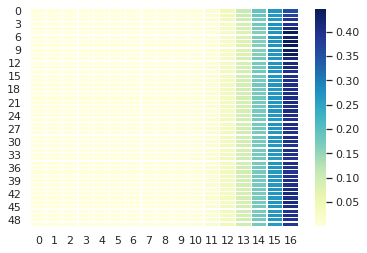

source:  the most effective and convenient solution for safety from hepatitisb and its resultant chronic carrier state or liver cancer is vaccination 
actual:  <sos> हैपेटाइटिसबी बीमारी तथा उसके परिणामस्वरूप होने वाले क्रानिक कैरियर स्टेट या लीवर कैंसर से बचाव का सर्वाधिक प्रभावी और सुविधाजनक उपाय है  टीकाकरण ।
predicted:  वर्ष में में पहले में पहले में अन्तराष्ट्रीय में में क्षति के लिए अवधि के लिए अवधि के लिए अवधि के लिए अवधि के लिए पहले में में अवधि के लिए अवधि के लिए अवधि की अवधि में वर्ष में अधिक अधिक अधिक में में में अधिक अधिक अधिक अधिक
BLEU Score:  0


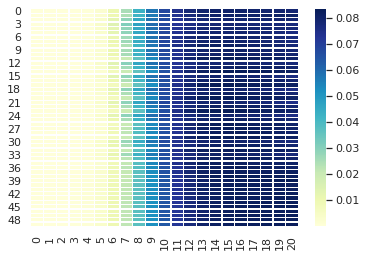

source:  after vaccination people who have developed protective antibacterial reactions can get total safety from intense and old contraction along with diseases 
actual:  <sos> टीकाकरण के बाद सुरक्षात्मक प्रतिजैविक प्रतिक्रया विकसित कर चुके व्यक्तियों को तीव्र और पुराने संक्रमण तथा साथ ही बीमारियों से संपूर्ण सुरक्षा मिल सकती है ।
predicted:  में में प्रजनन में पहले में पहले में पहले में में अवधि में वर्ष में वर्ष में अधिक अधिक अधिक में में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


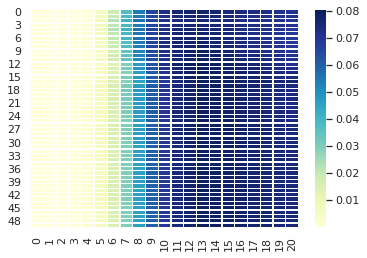

source:  with extensive use of hepatitisb vaccination a remarkable decrease has been seen in hepatitisb infection and the liver cancer arising out of long term hepatitisb 
actual:  <sos> हैपेटाइटिसबी टीके के व्यापक उपयोग से हैपेटाइटिसबी संक्रमण और दीर्घकालीन हैपेटाइटिसबी से उभरे लीवर कैंसर में उल्लेखनीय रूप से कमी दिखी है ।
predicted:  वर्ष में में पहले में पहले में महिला में में कैंसर में में अवधि के लिए अवधि की अवधि के लिए अवधि की अवधि में वर्ष में अधिक अधिक अधिक अधिक में में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


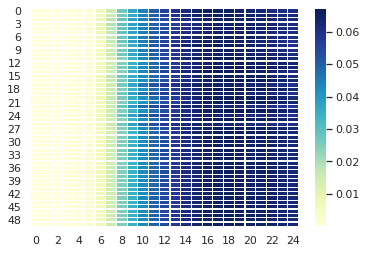

source:  yellow fever is also called yellow jack  black vomit  negro s vomit or american plague 
actual:  <sos> पीतज्वर को पीला जैक  काली उल्टी  नीग्रो की उल्टी या अमेरिकन प्लेग भी कहते हैं ।
predicted:  में में पहले ग्रंथी में पहले में पहले में अवधि के लिए अवधि है <eos>
BLEU Score:  0


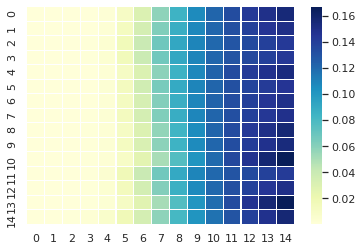

source:  the combined vaccine is made for children and adults 
actual:  <sos> संयुक्त टीका बच्चों और वयस्कों के लिए बना है ।
predicted:  से पहले जाँच का परीक्षण परीक्षण के कारण सभी जाँच से जाँच से लिए लिए जाँच से जाँच से लिए जाँच से जाँच से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से
BLEU Score:  0


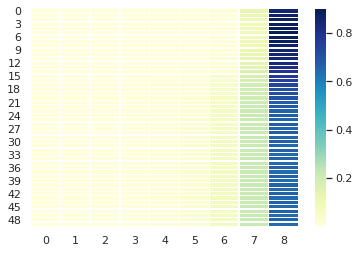

source:  what precautions should be taken after operation so that hernia does not occur again 
actual:  <sos> आपरेशन के बाद हर्निया दुबारा न rpneg हो इस के लिए क्याक्या सावधानियाँ बरतनी चाहिए 
predicted:  में में पहले में पहले में पहले में सभी पहले में में अवधि में बोतलों में अधिक अधिक अधिक अवधि में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


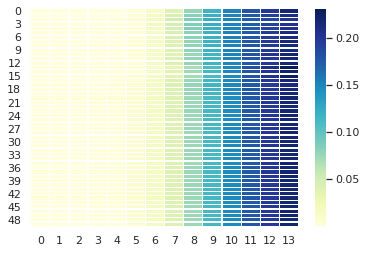

source:  the huge problem of increasing population has stayed in india after independence 
actual:  <sos> स्वतन्त्रता प्राप्ति के पश्‍चात भारतवर्ष में बढ़ती जनसंख्या की विकराल समस्या रही है ।
predicted:  में में पहले ग्रंथी में पहले ग्रंथी में खाली अवधि के लिए अवधि है <eos>
BLEU Score:  0


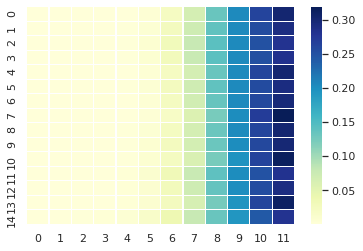

source:  the family welfare program was run at the national level in the year of  
actual:  <sos> वर्ष  में राष्ट्रीय स्तर पर परिवार कल्याण कार्यक्रम चलाया गया ।
predicted:  पहले जाँच से परीक्षण का परीक्षण का कैंसर का कैंसर से क्षेत्र से जाँच से कैंसर से कैंसर से जाँच से कैंसर से कैंसर से कैंसर में कैंसर से कैंसर में कैंसर से कैंसर से कैंसर में कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर
BLEU Score:  0


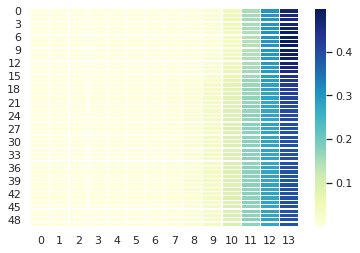

source:  on the subject of population and development it was suggested at an international conference in cairo lrb egypt rrb in the year of  that it would be necessary for human welfare and development to conjugate reproductive health safety along with reforms to family welfare 
actual:  <sos> वर्ष  में केरो  मिश्र  में एक अन्तराष्ट्रीय सम्मेलन में जनसंख्या एवं विकास के विषय में यह सुझाया गया कि प्रजनन स्वास्थ्य सुरक्षा को परिवार कल्याण के साथ सुधार कर जोड़ना मानवहित एवं विकास हेतु आवश्यक होगा ।
predicted:  निश्‍चित में में पहले में पहले में में अन्तराष्ट्रीय में में क्षति के लिए अवधि में में अवधि में अधिक अधिक अधिक में में में में में में में में में में में में में में में में में में में में में में में में में में में में
BLEU Score:  0


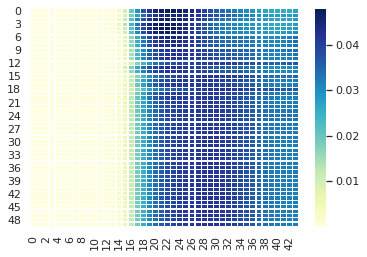

source:  all the reproduction health safety should be kept in the form of a single element within family planning services 
actual:  <sos> समग्र प्रजनन स्वास्थ्य सुरक्षा को एक ही तत्व के रूप में परिवार नियोजन सेवाओं में रखा जाय ।
predicted:  वर्ष एक जाँच से परीक्षण का परीक्षण के कारण पता के बाद जाँच से क्षेत्र से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से
BLEU Score:  0


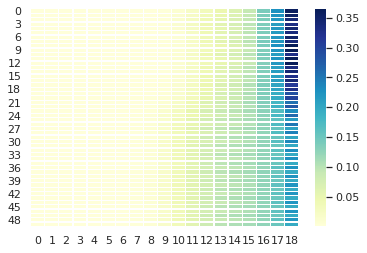

source:  therefore the concept of reproductive and child health programme was born 
actual:  <sos> अतः प्रजनन एवं बाल स्वास्थ्य कार्यक्रम अवधारणा का जन्म हुआ ।
predicted:  में में पहले परीक्षण का परीक्षण में कैंसर में में संख्या है <eos>
BLEU Score:  0


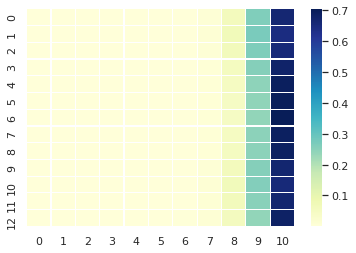

source:  reproductive and child health programme is being run since the year of  in india 
actual:  <sos> भारत वर्ष प्रजनन एवं बाल स्वास्थ्य कार्यक्रम वर्ष  से चलाया जा रहा है ।
predicted:  कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के लिए व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति
BLEU Score:  0


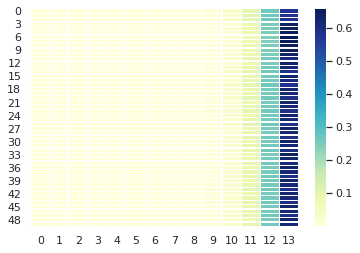

source:  this program has been running in uttarakhand since the constitution of the state 
actual:  <sos> उत्तराखण्ड में यह कार्यक्रम राज्य के गठन से ही चलाया जा रहा है ।
predicted:  कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच
BLEU Score:  0


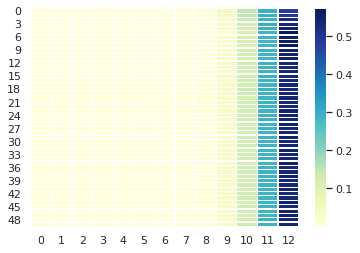

source:  reproduction rate has always been low in uttarakhand in comparison with the original state uttar pradesh 
actual:  <sos> मूल राज्य उत्तरप्रदेश की तुलना में उत्तराखण्ड में प्रजनन दर का स्तर सदैव कम रहा है ।
predicted:  में में पहले में पहले में अन्तराष्ट्रीय में कैंसर में में खाली में अवधि में वर्ष में अधिक अधिक अधिक अधिक में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


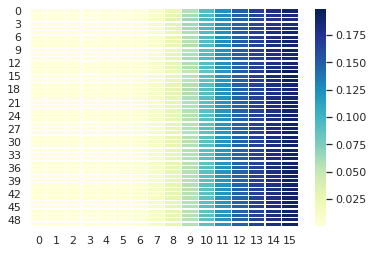

source:  raw birth rate of this state in the period of  was  which decreased to become  in the period of  and during the years of  this rate lowered more and stayed at  only 
actual:  <sos> वर्ष    की अवधि में इस राज्य का अशोधित जन्म दर  था जो कि घटते हुये वर्ष    की अवधि में  हो गया तथा वर्ष    के दौरान यह दर और भी कम होकर मात्र  रह गया ।
predicted:  वर्ष में में पहले में पहले में महिला में कैंसर में कैंसर में वर्ष के लिए अवधि की अवधि के लिए अवधि की अवधि में वर्ष में वर्ष में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


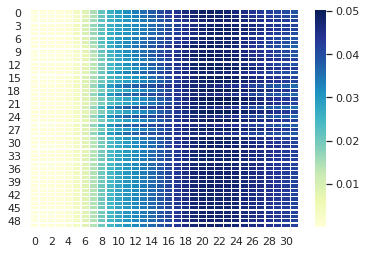

source:  among the districts this rate is the least in paudi while the most in haridwar 
actual:  <sos> जिलों में यह दर सबसे कम पौड़ी में जब कि सबसे अधिक हरिद्वार में है ।
predicted:  एक जाँच के कारण जाँच के कारण परीक्षण के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच
BLEU Score:  0


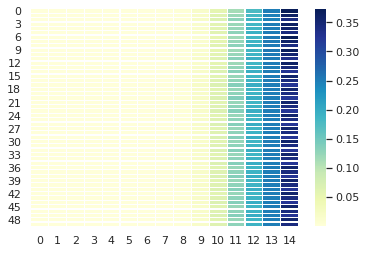

source:  gross reproduction rate lrb the number of infants given birth by a woman in her life time rrb which was estimated to be more than  for the period of   has been continuously decreasing and in the year of  this number was   
actual:  <sos> सकल प्रजनन दर  किसी महिला द्वारा अपने प्रजनन जीवन काल में जन्में गए शिशुओं की संख्या  जो कि  की अवधि के लिए  से अधिक अनुमानित थी  निरन्तर घट रही है तथा वर्ष  में यह संख्या  थी ।
predicted:  वर्ष में में पहले में पहले में में अन्तराष्ट्रीय में में में में में में में अवधि में अधिक अधिक अधिक अधिक में में में में अधिक अधिक में में में में अधिक में में अधिक में में अधिक अधिक में में अधिक अधिक अधिक में में अधिक अधिक अधिक
BLEU Score:  0


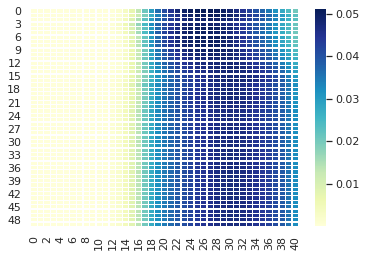

source:  inter district differences has also occurred less during this period 
actual:  <sos> अन्तर जनपदीय विभिन्नताएँ भी इस अवधि में कम हुई हैं ।
predicted:  में ग्रंथी से पहले पहले परीक्षण में में सभी सभी जाँच में में अवधि में अधिक कैंसर में अधिक कैंसर में अधिक कैंसर में अधिक कैंसर में अधिक अधिक कैंसर में अधिक अधिक कैंसर में अधिक अधिक कैंसर में अधिक अधिक कैंसर में अधिक अधिक कैंसर में अधिक अधिक कैंसर
BLEU Score:  0


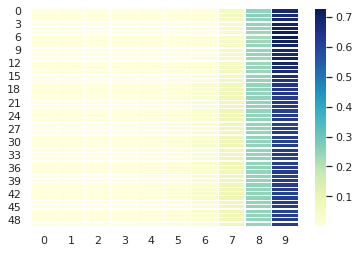

source:  raw birth rate and gross reproduction rate has been different in urban and rural areas 
actual:  <sos> अशोधित जन्मदर तथा सकल प्रजनन दर नगरीय तथा ग्रामीण क्षेत्रों में भिन्नभिन्न रही है ।
predicted:  में में पहले में पहले में पहले में पहले में क्षति है <eos>
BLEU Score:  0


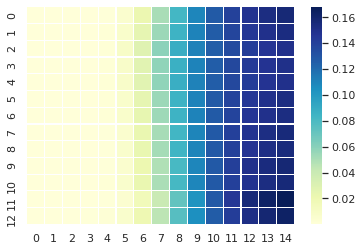

source:  it is the desire of son that will affect the future reproductive level of the state 
actual:  <sos> पुत्र की चाहत ही प्रबल है जो कि राज्य के भावी प्रजनन स्तर को प्रभावित करेगा ।
predicted:  वर्ष में में पहले में प्रजनन में कैंसर में में कैंसर में में वर्ष में वर्ष में वर्ष में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


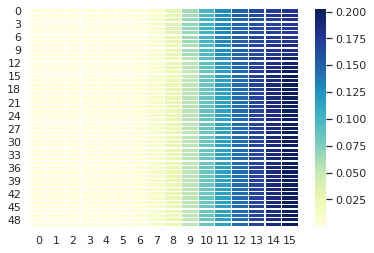

source:  generally  birth rate is lower the hilly areas than in the plain areas 
actual:  <sos> सामान्य रूप से मैदानी क्षेत्रों की तुलना में पर्वतीय क्षेत्रों में जन्मदर कम है ।
predicted:  पहले से पहले परीक्षण का परीक्षण का कैंसर में क्षेत्र में में यह में जाँच से कैंसर से कैंसर से कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में
BLEU Score:  0


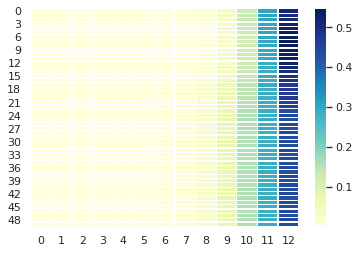

source:  about one fourth of the women give birth to the next child within  months 
actual:  <sos> लगभग एक चौथाई महिलाएँ पहले जन्मे बच्चे के बाद  महिनों के भीतर दूसरे बच्चे को जन्म देती हैं ।
predicted:  पहले में जाँच का परीक्षण का कैंसर में कैंसर का पता में में वर्ष में वर्ष से वर्ष से कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर
BLEU Score:  0


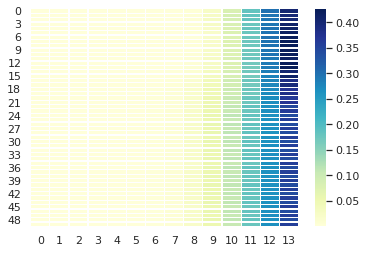

source:  a little less than half of the mothers lrb  percent rrb give birth to more than  kids 
actual:  <sos> आधे से कुछ कम   प्रतिशत  माताएँ  से अधिक बच्चों को जन्म देती हैं ।
predicted:  कैंसर जाँच के कारण व्यक्ति के व्यक्ति के लिए व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति जाँच की जाँच की जाँच हो है । <eos>
BLEU Score:  0.18429333166740366


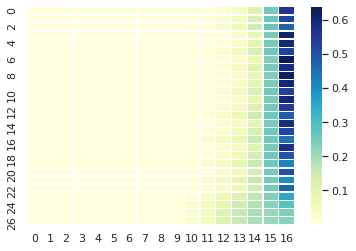

source:  about  percent of the births come in the category of serious danger 
actual:  <sos> लगभग  प्रतिशत जन्म गम्भीर खतरे वाली श्रेणी में आते हैं ।
predicted:  खुराक कैंसर के लिए व्यक्ति के लिए व्यक्ति के लिए व्यक्ति की व्यक्ति की व्यक्ति की जाँच की जाँच हो है । <eos>
BLEU Score:  0.19259074009082888


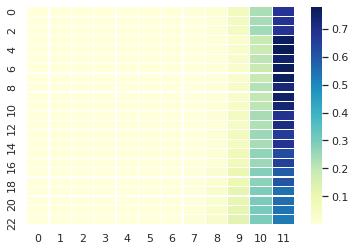

In [169]:
get_prediction(X_test,y_in_test,model)
get_prediction(X_train,y_in_train, model)

In [170]:
_X = pd.read_table('./NLA S20 - Assignment 2 Data/enghin/dev.en', names=['src'])
_Y = pd.read_table('./NLA S20 - Assignment 2 Data/enghin/dev.hi', names=['dest'])
_lines = pd.concat([_X,_Y], axis=1)
print(len(_lines))
_lines.sample(10)

401


src                                               dest
13   There is no better solution but to eat fish fo...  अगर आप मांसाहारी हैं तो आँखों को स्वस्थ बनाए र...
332  The construction of this huge arena was done i...  इस विशाल अखाड़े का निर्माण 80 ईस्वी में हुआ था ...
24   The danger of glaucoma , cataract , and blindn...  विटामिन-सी से भरपूर आहार लेने से ग्लूकोमा , मो...
273  Not only this , in this journey you can give a...  यही नहीं , इस सफर में आप अपनी फेवरिट बुक को बि...
169   Tuberculosis in which medicine does not affect .                 टी.बी. , जिसमें औषधि का असर न हो ।
278  Buying a ticket in advance is cheaper , this i...  वैसे , एडवांस में टिकट खरीदना सस्ता पड़ता है , ...
390  In the first week of December Louis cruise has...  दिसंबर के पहले हफ्ते में कोच्चि से लुई क्रूज न...
91   By smoking cigarette the arteries bringing oxy...  सिगरेट पीने से मस्तिष्क तक आक्सीजन पहुँचाने वा...
236  I remember that night as well when Shabana Azm...  मुझे वो रात भी याद है जब शबाना आजमी ने मुझे तह...
72   Everybody has his own way to remember or learn...  कोई भी चीज याद रखने या सीखने का हर किसी का अपन...

In [0]:
_X, _y = _lines.src.values, _lines.dest.values 

source:  but you will also be safe from eye diseases .
actual:  बल्कि आप नेत्ररोगों से भी बचे रहेंगे ।
predicted:  में ग्रंथी में पहले महिला में सभी सभी सभी जाँच से अवधि से लिए लिए जाँच है <eos>
BLEU Score:  0


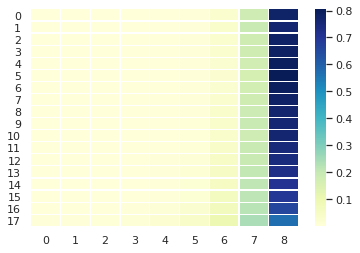

source:  The chairperson of the Department of Ophthalmology of Liverpool University Dr . Ian Greerson says .
actual:  लिवरपूल यूनिवर्सिटी के आप्थैमोलॉजी विभाग के अध्यक्ष व विख्यात नेत्ररोग शोधकर्ता डॉ. इयान ग्रीयरसन कहते हैं ।
predicted:  समय इन लिए लिए बचाव का नाखून का सेवन हैं <eos>
BLEU Score:  0.18557819854739144


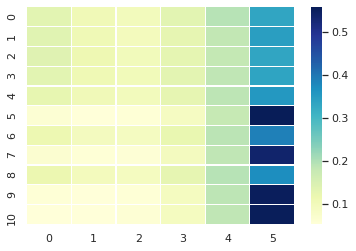

source:  Common blindness causing diseases like cataract and glaucoma can be prevented by increasing the amount of vitamin-C and omega-3 oils and some special plants in diet .
actual:  कि खाने में विटामिन-सी और ओमेगा-3 तेलों व कुछ विशेष पौधों की मात्रा बढ़ाने से आमतौर पर अंधेपन का कारण बनने वाले मोतियाबिंद व ग्लूकोमा जैसे रोगों से बचा जा सकता है ।
predicted:  वर्ष पहले से पहले परीक्षण का परीक्षण का कैंसर में क्षेत्र में क्षेत्र में वर्ष में वर्ष से वर्ष से कैंसर में कैंसर की कैंसर में कैंसर में वर्ष की कैंसर में कैंसर में वर्ष की कैंसर में कैंसर में वर्ष की कैंसर में कैंसर में वर्ष की कैंसर में
BLEU Score:  0.16925661563897607


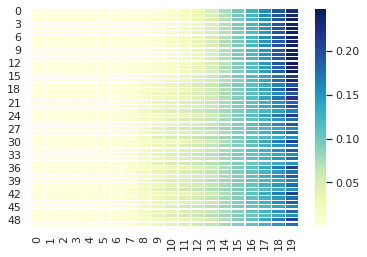

source:  So let us know how your diet should be to keep eyes healthy .
actual:  तो आइए जानते है कि नजर को स्वस्थ बनाए रखने के लिए कैसा हो आपका आहार ।
predicted:  एक जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच
BLEU Score:  0


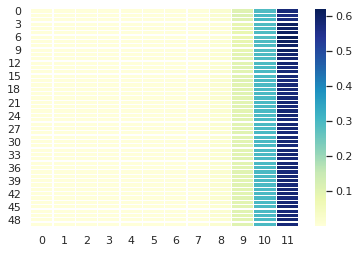

source:  You should include green vegetables in your diet to keep eyes sharp .
actual:  नजर तेज बनी रहे , इसके लिए आपको चाहिए की अपने आहार में आप हरी सब्जियाँ शामिल करें ।
predicted:  धीरे धीरे लेकिन खाली अवधि के लिए लिए बाद दिनों कारण प्रसार है <eos>
BLEU Score:  0


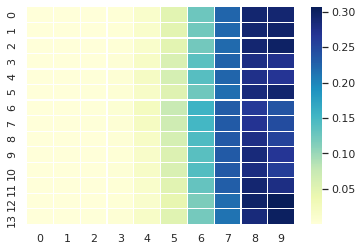

source:  Eating spinach , broccoli , germinated grains may be beneficial in this regard .
actual:  पालक , ब्रोकोली , अंकुरित अनाज खाना इस लिहाज से फायदेमंद साबित हो सकता है ।
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए सुरक्षा है <eos>
BLEU Score:  0


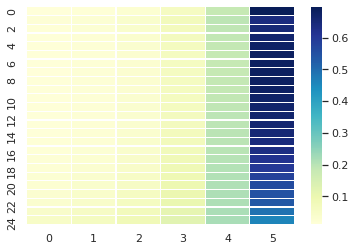

source:  There are two important elements like lutein , zeaxanthin which are responsible to keep vision sharp .
actual:  इसमें ल्यूटिन , जीजेनथिन जैसे दो अहम तत्व होते हैं , जो नजर को तेज बनाए रखने के लिए जिम्मेदार होते हैं ।
predicted:  में जाँच से पहले परीक्षण का कैंसर में कैंसर से संख्या है <eos>
BLEU Score:  0


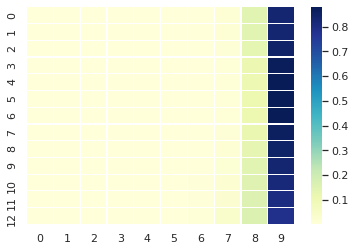

source:  This has been testified in the six-year study by the American National Eye Institute that this element saves old people from blindness .
actual:  अमेरिकी नेशनल आई इंस्टीट्यूट के 6 साल के अध्ययन में यह साबित हुआ है कि यह तत्व बुजुर्गों को अंधेपन से बचाते हैं ।
predicted:  वर्ष पहले से पहले परीक्षण का परीक्षण का कैंसर में क्षेत्र में क्षेत्र में यह यह यह यह यह यह यह यह यह यह यह यह कैंसर में वर्ष की कैंसर में कैंसर में वर्ष की कैंसर से कैंसर में कैंसर की कैंसर से कैंसर में कैंसर की कैंसर से
BLEU Score:  0


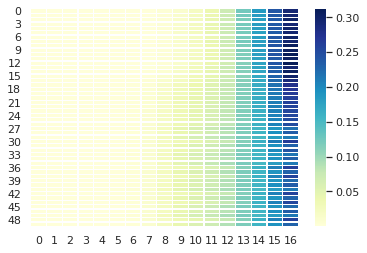

source:  Therefore everybody should eat hundred grams of green vegetables in the form of salad .
actual:  अमेरिकी नेशनल आई इंस्टीट्यूट के 6 साल के अध्ययन में यह साबित हुआ है कि यह तत्व बुजुर्गों को अंधेपन से बचाते हैं ।
predicted:  एक पहले जाँच का परीक्षण का पता के कारण जाँच से क्षेत्र से जाँच से जाँच से जाँच से जाँच से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर से कैंसर
BLEU Score:  0


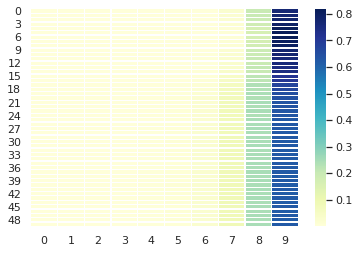

source:  You must eat two or three eggs daily in breakfast .
actual:  नाश्ते में रोज दो या तीन अंडे जरूर खाएँ ।
predicted:  में सभी लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए सुरक्षा लगना । <eos>
BLEU Score:  0.19552795980276136


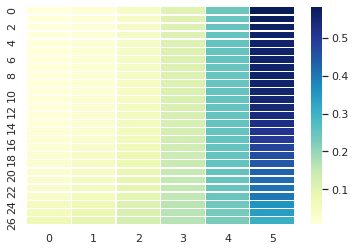

source:  Bilberry or blackberry anthocyanin saves from blindness or cataract .
actual:  बिलबैरी या ब्लैकबैरी एंथोसाइनिन अंधेपन या मोतियाबिंद से बचाती है ।
predicted:  समय इन लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए बुखार । <eos>
BLEU Score:  0.1940679506664638


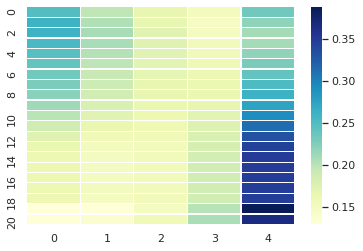

source:  It is also found in the research that it strengthens the cell which brings blood and nutritious elements into the eyes .
actual:  शोध में यह भी पाया गया है कि यह आँखों में खून और पोषक तत्व पहुँचाने वाली कोशिकाओं को मजबूत बनाती हैं ।
predicted:  वर्ष में में पहले में पहले में महिला में में पहले में में अवधि में वर्ष में वर्ष में अधिक अधिक अधिक में में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


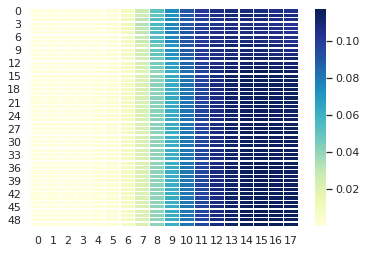

source:  That is why you can also eat bilberry or blackberry in breakfast or with fruit salad .
actual:  इसलिए नाश्ते या फ्रूट सलाद के साथ आप बिलबैरी या ब्लैकबैरी भी खा सकते हैं ।
predicted:  में ग्रंथी से पहले पहले में बाद सभी सभी लैन्स में में जाँच में पाया है । <eos>
BLEU Score:  0.18690518620528904


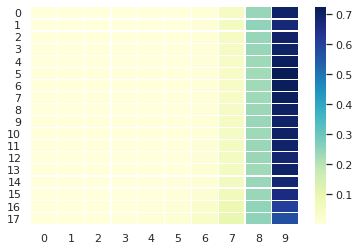

source:  There is no better solution but to eat fish for keeping eyes healthy if you are a non-vegetarian .
actual:  अगर आप मांसाहारी हैं तो आँखों को स्वस्थ बनाए रखने के लिए मछली का सेवन करने से अच्छा कोई उपाय नहीं ।
predicted:  पहले में दिनों पहले परीक्षण का परीक्षण में कैंसर में में यह में में में जाँच से वर्ष में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर में कैंसर
BLEU Score:  0


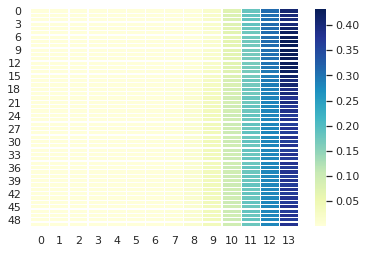

source:  By eating fish not only your skin , hair , brain remain healthy but eyes also sharpen .
actual:  मछली खाने से न केवल आपकी त्वचा , बाल , दिमाग स्वस्थ रहता बल्कि नजर भी तेज होती है ।
predicted:  में में पहले ग्रंथी में पहले ग्रंथी में खाली अवधि के लिए अवधि है <eos>
BLEU Score:  0


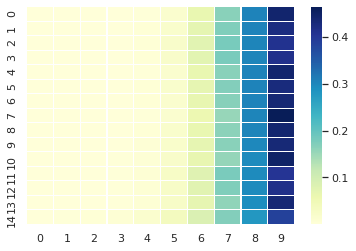

source:  Omega-3 fat found in fish decreases the danger of glaucoma and weak eyes in old age .
actual:  मछली में पाया जाने वाला ओमगा-3 फैट आँखों को ग्लूकोमा और बुढ़ापे में नजर कमजोर होने का खतरा कम करता है ।
predicted:  पहले से पहले परीक्षण का परीक्षण में कैंसर में में संख्या है है <eos>
BLEU Score:  0


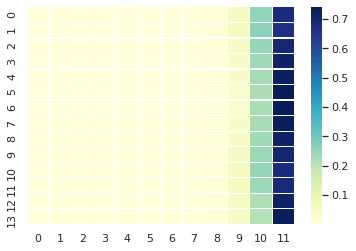

source:  Not only this , it saves you from dry eye syndrome .
actual:  यही नहीं , यह आपको ड्राय आई सिंड्रोम से बचाता है ।
predicted:  कैंसर के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए जाँच हो । <eos>
BLEU Score:  0.19259074009082888


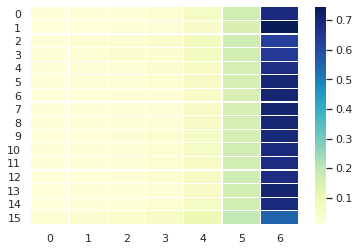

source:  It is stated in another study that women suffering from ophthalmic problems such as dry eye syndrome can decrease this problem up to 68 percent by eating tuna fish .
actual:  एक अन्य अध्ययन में बताया गया है कि ड्राय आई सिंड्रोम जैसे नेत्र समस्या से परेशान महिलाएँ हफ्ते में पाँच बार ट्यूना मछली खाकर , इस तकलीफ को 68 फीसदी कम कर सकती हैं ।
predicted:  वर्ष में में पहले में पहले में कैंसर में में कैंसर में में वर्ष में वर्ष में वर्ष में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


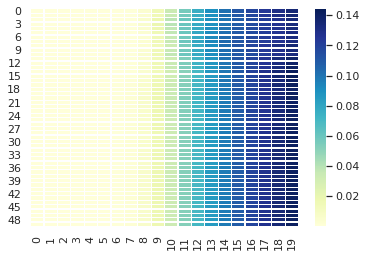

source:  The use of dry fruits etcetera in Indian cuisines has been continuing for centuries .
actual:  भारतीय व्यंजनों में मेवे आदि का इस्तेमाल सदियों से होता आ रहा है ।
predicted:  में पहले जाँच का कारण परीक्षण के लिए लिए जाँच से जाँच से लिए लिए जाँच से लिए लिए जाँच है <eos>
BLEU Score:  0


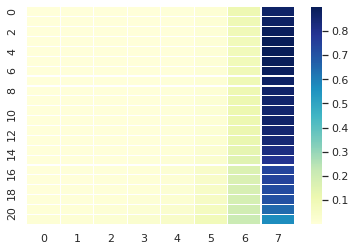

source:  But do you know that all the dry fruits such as almond , cashew nut , walnut , raisins etcetera are also very beneficial for eyes besides being nutritious .
actual:  लेकिन क्या आप जानते हैं कि बादाम , काजू , अखरोट , किशमिश आदि यह सारे मेवे पौष्टिक होने के अलावा आँखों के लिए भी बहुत फायदेमंद होते हैं ।
predicted:  वर्ष में में पहले में पहले में महिला में में कैंसर में में अवधि में वर्ष में अधिक अधिक अधिक अधिक में में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


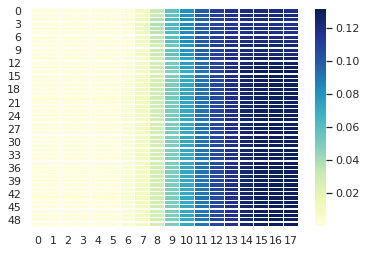

source:  Plenty of vitamin-B is found in these , which not only saves from cataract , many kind of blindness and other eye diseases but also protect eyes from the harms of ultraviolet rays .
actual:  इनमें विटामिन ई प्रचुर मात्रा में पाया जाता है , जो न केवल मोतियाबिंद , कई प्रकार के अंधेपन और अन्य नेत्र रोगों से बचाने के अलावा पराबैंगनी किरणों से पहुँच रहे नुकसान से भी आँखों की रक्षा करता है ।
predicted:  वर्ष में में पहले में पहले में कैंसर में कैंसर में में वर्ष में वर्ष में वर्ष में वर्ष में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


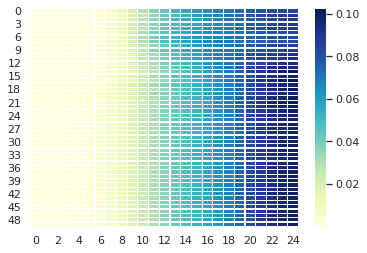

source:  Start eating pieces of dry fruits in sweets daily at the time of breakfast or meals .
actual:  रोज नाश्ते या खाने के समय मीठे में मेवे की कतरन बुरक के खाना शुरू कर दें ।
predicted:  में पहले से पहले परीक्षण का परीक्षण में कैंसर में में संख्या है <eos>
BLEU Score:  0


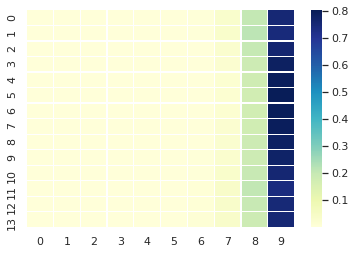

source:  Whether it is about dropping weight or care of skin , the advice of fresh fruits in meals is given in all the cases .
actual:  बात वजन घटाने की हो या त्वचा की देखभाल की , खाने में ताजे फल खाने की सलाह सभी मामलों में दी जाती है ।
predicted:  वर्ष प्रजनन से पहले परीक्षण का परीक्षण का कैंसर में क्षेत्र में में यह में यह यह यह यह यह यह यह यह कैंसर में वर्ष की कैंसर में कैंसर में वर्ष की कैंसर में कैंसर में वर्ष की कैंसर में कैंसर में वर्ष की कैंसर में कैंसर में वर्ष
BLEU Score:  0


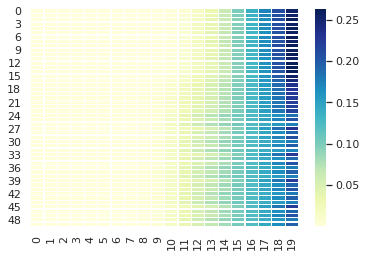

source:  So , why should it be left for eyes .
actual:  तो भला , आँखों के लिए क्यों इन्हें छोड़ा जाए ।
predicted:  जाँच के लिए कारण जाँच के लिए लिए कारण जाँच के लिए लिए जाँच से जाँच से लिए लिए जाँच है <eos>
BLEU Score:  0


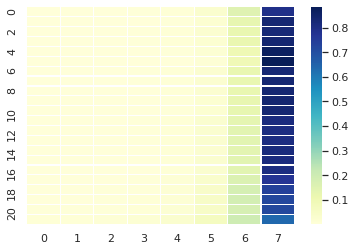

source:  The danger of glaucoma , cataract , and blindness can be decreased to a great extent by taking diet rich in vitamin-C .
actual:  विटामिन-सी से भरपूर आहार लेने से ग्लूकोमा , मोतियाबिंद और अंधेपन का खतरा काफी हद तक कम किया जा सकता है ।
predicted:  एक जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच
BLEU Score:  0


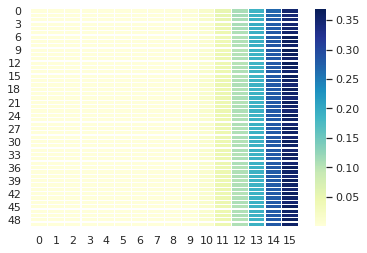

source:  Including fruit , vegetable in meal is enough to maintain the eyes healthy .
actual:  आँखों को स्वस्थ बनाए रखने के लिए आहार में फल सब्जियाँ शामिल करना काफी है ।
predicted:  जाँच के लिए कारण जाँच के कारण कारण जाँच के लिए लिए जाँच से जाँच से लिए लिए जाँच से लिए जाँच है <eos>
BLEU Score:  0


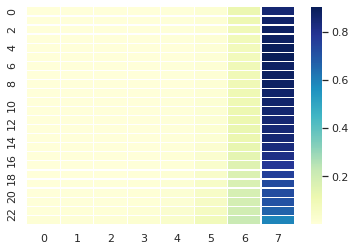

source:  Including these things in your diet you can save your eyes from getting weakened .
actual:  इन्ही चीजों को अपने आहार में शामिल कर आप आँखों को कमजोर होने से बचा सकते हैं ।
predicted:  में में पहले में पहले में अन्तराष्ट्रीय में लैन्स में में क्षति है <eos>
BLEU Score:  0


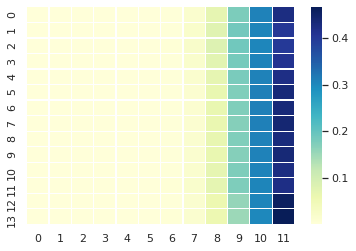

source:  Besides this drinking milk , eating carrot is also proved to be beneficial .
actual:  इसके अलावा दूध पीना , गाजर खाना भी फायदेमंद साबित होता है ।
predicted:  जाँच के लिए व्यक्ति के लिए व्यक्ति की व्यक्ति की व्यक्ति की व्यक्ति हो है <eos>
BLEU Score:  0


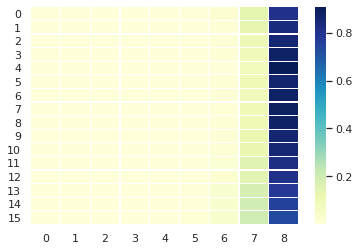

source:  Taking diet rich in vitamin-A can also be helpful in keeping eyes healthy .
actual:  विटामिन-ए से भरपूर आहार लेना भी आँखों को स्वस्थ बनाए रखने में मददगार साबित हो सकता है ।
predicted:  जाँच के कारण जाँच के कारण कारण के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के
BLEU Score:  0


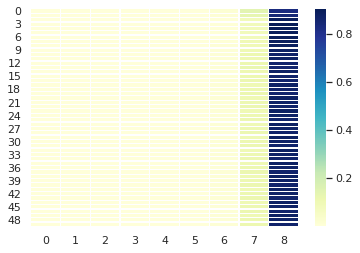

source:  A little care taken in diet may also put new life in your eyes .
actual:  खान-पान में बरती गई थोड़ी सी सावधानी भी आपकी आँखों में नई जान डाल सकती है ।
predicted:  एक जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच
BLEU Score:  0


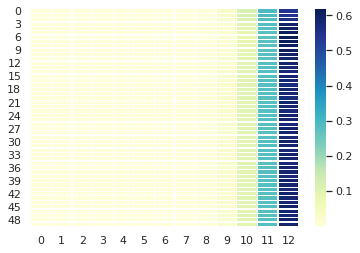

source:  Paralysis may be controlled by yoga .
actual:  योग से काबू हो सकता है लकवा ।
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए बुखार । <eos>
BLEU Score:  0.19817632389021378


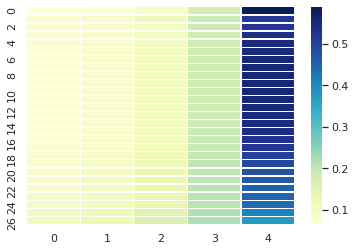

source:  Paralysis - when generally the functionalism , and dynamism of muscles and pulse of the right or left side of the body go less or end this problem is said to be paralysis .
actual:  पक्षाघात - आमतौर पर शरीर के दाएँ या बाएँ भाग की मांसपेशियों व नसों की क्रियाशीलता एवं गतिशीलता कम या समाप्त हो जाती है तो इस समस्या को लकवा या पक्षाघात कहते हैं ।
predicted:  एक एक जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के जाँच जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण
BLEU Score:  0


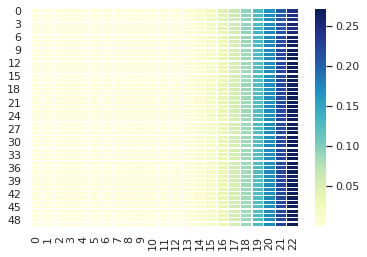

source:  Paralysis is limited to half of the body , whole of the body or only till face .
actual:  पक्षाघात आधे शरीर , संपूर्ण शरीर या केवल चेहरे तक होता है ।
predicted:  कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति व्यक्ति के लिए व्यक्ति के लिए व्यक्ति के लिए व्यक्ति के लिए व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति व्यक्ति के लिए व्यक्ति के लिए व्यक्ति के लिए व्यक्ति
BLEU Score:  0


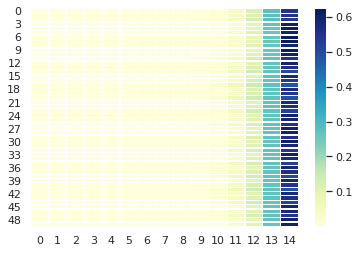

source:  The main reason of this problem is increasing high blood pressure , blood clotting in brain , the situation of extreme happiness or sorrow etc .
actual:  इस समस्या का प्रमुख कारण उच्च रक्तचाप का अधिक बढ़ना , मस्तिष्क में रक्त का थक्का बनना अत्यंत हर्ष या विषाद की स्थिति आदि है ।
predicted:  एक जाँच के कारण जाँच के कारण भी परीक्षण के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण
BLEU Score:  0


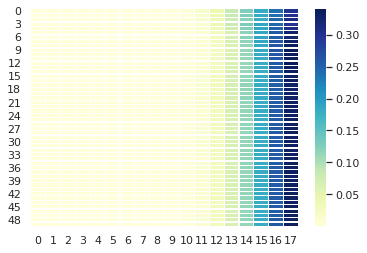

source:  By yogic exercise this disease can be overcome surely .
actual:  यौगिक अभ्यास से इस रोग पर निश्‍चित ही विजय प्राप्त की जा सकती है ।
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए सुरक्षा लगना । <eos>
BLEU Score:  0.18827362913939635


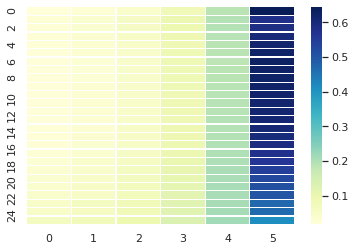

source:  Although yoga solves the problem of paralysis permanently but it takes time and is tough .
actual:  हालांकि योग पक्षाघात की समस्या का स्थायी समाधान करता है , लेकिन यह समय लेता है एवं श्रमसाध्य है ।
predicted:  एक जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच
BLEU Score:  0


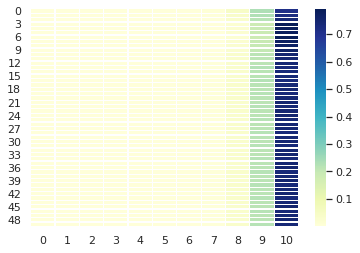

source:  Therefore medicines should be taken in the beginning and yoga exercises should be done along .
actual:  इसलिए शुरू में औषधियों का सेवन किया जाए और साथ में योग का अभ्यास किया जाए ।
predicted:  में में पहले में पहले में अन्तराष्ट्रीय में सभी सभी लैन्स में में अवधि में अधिक अधिक अधिक अवधि में अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक अधिक
BLEU Score:  0


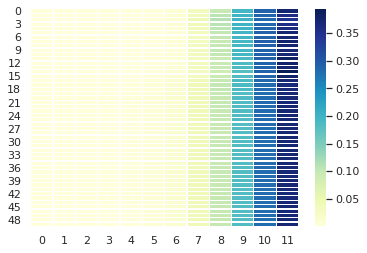

source:  Here the main yogic diagnosis for paralysis are presented .
actual:  यहाँ पर पक्षाघात हेतु प्रमुख यौगिक निदान प्रस्तुत हैं ।
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए सुरक्षा । <eos>
BLEU Score:  0.19552795980276136


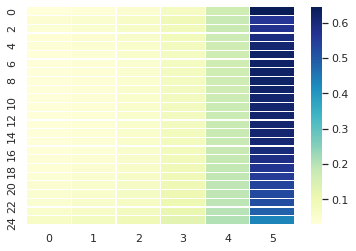

source:  Start with light exercise .
actual:  प्रारंभ सूक्ष्म व्यायाम से करो ।
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए बुखार । <eos>
BLEU Score:  0.19953087735062713


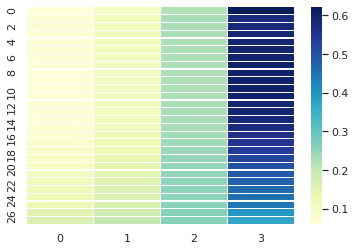

source:  This can be practiced only by lying down .
actual:  इसका अभ्यास लेट कर ही किया जा सकता है ।
predicted:  कैंसर के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए कम । <eos>
BLEU Score:  0.19552795980276136


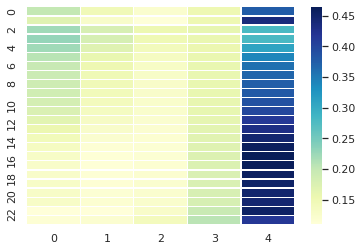

source:  After that as the situation improves , add Pavanmuktasana , Vajrasana , Shashankasana , Makarasana etcetera in practice .
actual:  उसके बाद जैसे-जैसे स्थिति सुधरती जाए , अभ्यास में पवनमुक्तासन , वज्रासन , शशांकासन , मकरासन आदि जोड़ लें ।
predicted:  में लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए सुरक्षा न । <eos>
BLEU Score:  0.18184804078107475


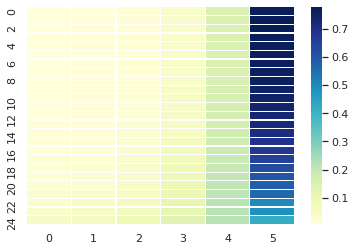

source:  What is onikomysis .
actual:  ओनिकोमाइसिस क्या हैं ?
predicted:  की लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए बुखार । <eos>
BLEU Score:  0


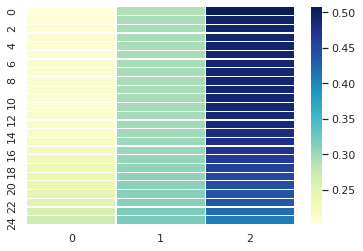

source:  Add Suptvajrasana , Trikonasana , Uttanpadasana , Gomukhasana and Ardhmatsyendrasana etc .
actual:  जब स्थिति और सुधर जाए तो अभ्यास में जानुशिरासन , सुप्तवज्रासन , त्रिकोणासन , उत्तानपादासन , गोमुखासन तथा अर्धमत्स्येंद्रासन आदि को जोड़ लें ।
predicted:  है <eos>
BLEU Score:  0


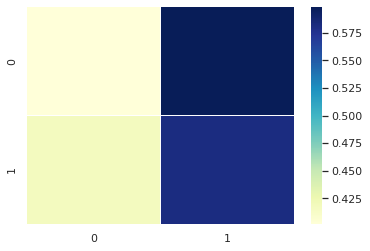

source:  Here the method of practice of Janushirasana is presented - sit stretching both the legs forward .
actual:  यहाँ पर जानुशिरासन के अभ्यास की विधि प्रस्तुत है - दोनों पैरों को सामने की ओर फैलाकर बैठ जाएँ ।
predicted:  कैंसर के लिए लिए व्यक्ति के लिए लिए लिए जाँच की लिए जाँच हो है <eos>
BLEU Score:  0


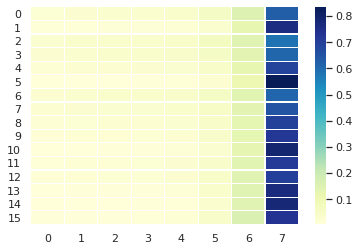

source:  Bending the right leg from the knee touch its sole to the left leg and put the heel below the genitals .
actual:  दाएँ पैर को घुटने से मोड़कर इसके तलवे का बाएँ पैर की जंघा से सटा दें तथा एड़ी जननेंद्रिय के नीचे रखें ।
predicted:  एक जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच
BLEU Score:  0


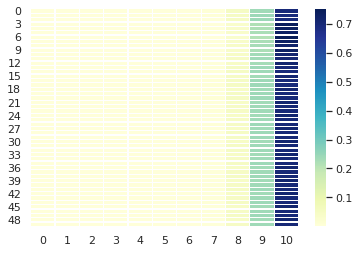

source:  Bringing both the hands to the forefoot of the left leg bend forward so much that the head touches the ground .
actual:  दोनों हाथों को बाएँ पैर के पंजे के पास ले जाते हुए आगे की ओर इतना झुकें कि सिर जमीन को स्पर्श करे ।
predicted:  एक जाँच के कारण जाँच के कारण परीक्षण के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच
BLEU Score:  0


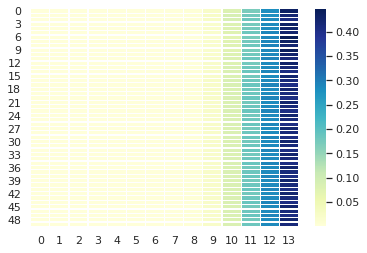

source:  Staying in this position for a comfortable period come back to the previous state .
actual:  इस स्थिति में आरामदायक अवधि तक रखकर वापस पूर्व स्थिति में आएँ ।
predicted:  जाँच के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के लिए व्यक्ति की व्यक्ति के लिए व्यक्ति की व्यक्ति के लिए जाँच की व्यक्ति की व्यक्ति से जाँच हो है । <eos>
BLEU Score:  0.19112328397109352


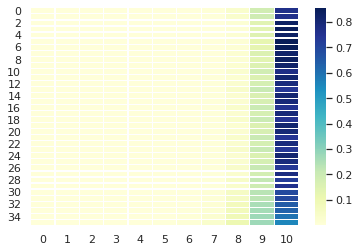

source:  Do the same exercise another side also .
actual:  यही क्रिया दूसरी तरफ भी करें ।
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए सुरक्षा लगना । <eos>
BLEU Score:  0.19913749124569236


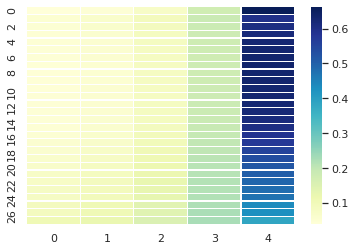

source:  The patients of sciatica and slip disk should avoid its practice .
actual:  साइटिका एवं स्लिप डिस्क के रोगी इसका अभ्यास न करें ।
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए सुरक्षा लगना । <eos>
BLEU Score:  0.2307869877265558


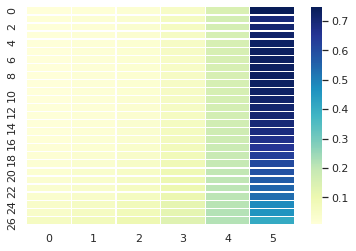

source:  Narishodhan and ujjayi pranayam play the role of panacea to make brain and central nervous system functional and to balance and function to the nervous system .
actual:  मस्तिष्क तथा केन्द्रीय तांत्रिक तंत्र को क्रियाशीलता एवं तंत्रिका तंत्र को क्रियाशील एवं संतुलित करने के लिए नाड़ीशोधन तथा उज्जायी प्राणायाम रामबाण की भूमिका निभाते हैं ।
predicted:  एक जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच के कारण जाँच
BLEU Score:  0


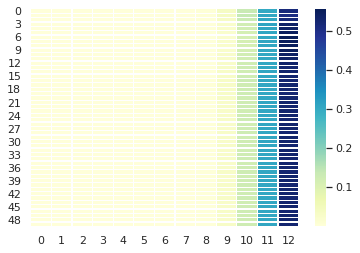

source:  Do its practice under the eligible guide according to your capacity without kumbhak or holding of breath .
actual:  बिनाRP_NEG\ कंभुक के इनका अभ्यास योग्य मार्गदर्शन में अपनी क्षमतानुसार करें ।
predicted:  जाँच के कारण जाँच के कारण कारण परीक्षण के कारण जाँच के लिए जाँच से जाँच से जाँच से लिए जाँच से जाँच से लिए जाँच से जाँच से कम से कम है <eos>
BLEU Score:  0


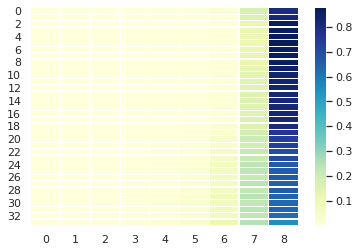

source:  Yoganidra - the main cause of this problem is mental tension and sentimental imbalance .
actual:  योगनिद्रा - इस समस्या का मूल कारण मानसिक तनाव तथा भावनात्मक असंतुलन है ।
predicted:  जाँच के लिए लिए व्यक्ति के लिए लिए व्यक्ति की व्यक्ति की व्यक्ति हो है <eos>
BLEU Score:  0


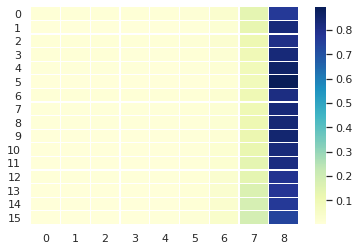

source:  Meditation is the best way to free mind from all worries , sorrows , pains , grief and fears .
actual:  मन को सारी चिंता , दुख , कष्ट तथा शोक एवं भय से मुक्त करने के लिए ध्यान सर्वश्रेष्ठ तकनीक है ।
predicted:  जाँच के लिए लिए व्यक्ति के लिए लिए लिए जाँच की लिए जाँच की लिए जाँच हो । <eos>
BLEU Score:  0.17956076853248887


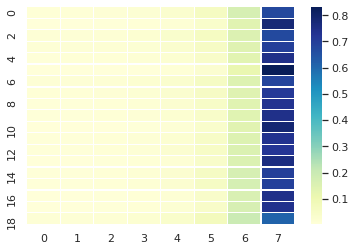

source:  Do practice this daily for ten to twenty minutes .
actual:  प्रतिदिन दस से बीस मिनट तक इसका अभ्यास अवश्य करें ।
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए बुखार । <eos>
BLEU Score:  0.1940679506664638


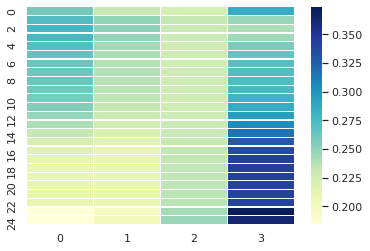

source:  Eat simple , easily digestible , nutritious food , eat bread of braned flour , old rice , porridge , pulse of green lentil , take fruits and green vegetables .
actual:  सादा , सुपाच्य , पौष्टिक आहार खाएँ , चोकरयुक्त आटे की रोटी , पुराना चावल , दलिया , मूंग की दाल खाएँ फल तथा हरी सब्जियों का सेवन करें ।
predicted:  एक जाँच के कारण व्यक्ति के कारण व्यक्ति के कारण व्यक्ति के व्यक्ति व्यक्ति के लिए व्यक्ति के लिए व्यक्ति के लिए व्यक्ति के कारण व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति व्यक्ति के व्यक्ति व्यक्ति के लिए व्यक्ति के लिए व्यक्ति के लिए व्यक्ति के कारण व्यक्ति के व्यक्ति व्यक्ति
BLEU Score:  0


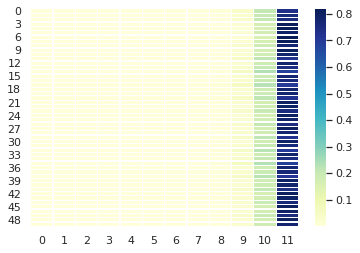

source:  Avoid heavy , hard to digest , tea , coffee , tobacco , intoxicating things and exciting element .
actual:  भारी , गरिष्ठ , चाय , काफी , तंबाकू , नशीले पदार्थ व उत्तेजक पदार्थों से परहेज करें ।
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए सुरक्षा लगना । <eos>
BLEU Score:  0.18305025818318518


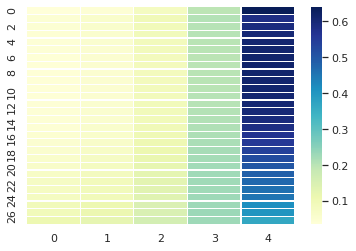

source:  Avoid citrus food item .
actual:  खट्टी चीजों के सेवन से बचें ।
predicted:  । <eos>
BLEU Score:  0.19913749124569236


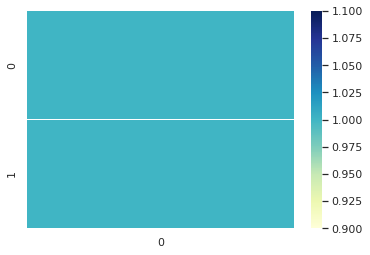

source:  Apply the walnut oil into the nostrils of the nose daily .
actual:  नाक के नथुनों में रोज सुबह-शाम अखरोट का तेल लगाएँ ।
predicted:  परिणाम इन रंग है <eos>
BLEU Score:  0


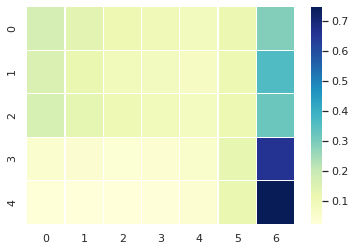

source:  Rub the body from top to bottom with furred towel after bathing .
actual:  स्नान के बाद रोएँदार तौलिये से शरीर को ऊपर से नीचे की ओर रगडें ।
predicted:  कैंसर के लिए लिए लिए लिए लिए लिए लिए लिए लिए जाँच का लिए लिए लिए जाँच है <eos>
BLEU Score:  0


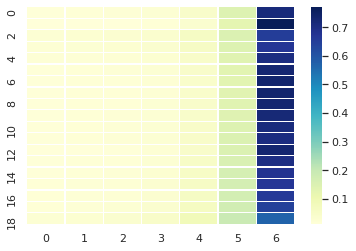

source:  Use warm water for bathing .
actual:  नहाने के लिए गर्म जल का प्रयोग करें ।
predicted:  के लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए लिए बुखार । <eos>
BLEU Score:  0.1969244213551724


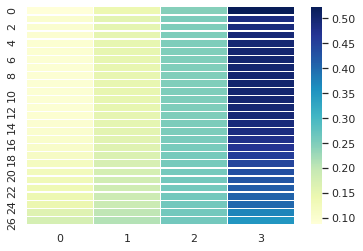

source:  The rising interference of technology in day-to-day life has made us very luxurious .
actual:  रोजमर्रा की जिंदगी में तकनीक के बढ़ते दखल ने हमें बेहद आरामतलब बना दिया है ।
predicted:  कैंसर के लिए लिए लिए व्यक्ति से मिली जाँच चाहिए <eos>
BLEU Score:  0


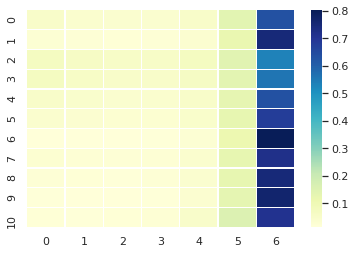

KeyboardInterrupt: ignored

In [172]:
get_prediction(_X,_y,model)

In [0]:
# nameoffile = "q42"
# with open(nameoffile, "wb") as dill_file:
#     dill.dump(model, dill_file)

In [0]:
# model = {}
# with open(nameoffile, "rb") as dill_file:
#   model = dill.load(dill_file)

In [0]:
# print(model['attn_type'])

LuongAttention
